# Bigcontest EDA

# 1. Setting Environment

## 1.1 Load libraries

In [2]:
library(data.table) # Data load
library(dplyr) # Preprocessing
library(stringr) # Preprocessing
library(tidyr) # Preprocessing
library(ggplot2) # Visualization
library(corrplot) # Visualization
library(GGally) # Visualization

## 1.2 Load Data

In [3]:
activity <- fread("data/train_activity.csv", stringsAsFactors = F)
guild    <- fread("data/train_guild_new.csv", stringsAsFactors = F)
label    <- fread("data/train_label.csv", stringsAsFactors = F) %>%
  mutate(label = factor(label, levels = c("retained", "2month", "month", "week")))
payment  <- fread("data/train_payment.csv", stringsAsFactors = F)
trade    <- fread("data/train_trade.csv", stringsAsFactors = F)

Read 440323 rows and 38 (of 38) columns from 0.302 GB file in 00:00:12
Read 10414351 rows and 7 (of 7) columns from 1.656 GB file in 00:00:21


## 1.3 Define functions

In [4]:
label_week_heatmap <- function(df, target, is_normalized, sample_num) {
    df <- as.data.frame(df)
    df_temp <- df[, c("acc_id", "wk", target)]
    
    if (is_normalized == T) {
        df_temp[df_temp[, target] > 1, target] <- 1
    }
    
    df_temp2 <- df_temp %>% spread(key = "wk", value = target) %>%
      left_join(label, by = "acc_id")
    
    if (is_normalized == F) {
        df_temp2[is.na(df_temp2)] <- 0
    }
    names(df_temp2)[2:9] <- paste0("wk", 1:8)
    
    result <- df_temp2 %>% gather(key = "wk", value = target, -acc_id, -label) %>% arrange(label, acc_id, wk)
    
    id_list <- result %>% group_by(label) %>% sample_n(sample_num)
    sample_df <- result %>% filter(acc_id %in% id_list$acc_id)
    
    if (is_normalized == F) {
        p <- ggplot(sample_df, aes(wk, acc_id, fill = target)) + geom_tile() +
          scale_fill_distiller(name = target, palette = "Spectral", tran = "reverse") +
          ylim(unique(sample_df$acc_id)) +
          theme(axis.text.y = element_blank(), plot.title = element_text(hjust = 0.5)) + 
          facet_grid(. ~ label)
    } else {
        p <- ggplot(sample_df, aes(wk, acc_id, fill = target)) + geom_tile() +
          scale_fill_distiller(name = target, palette = "YlOrRd", tran = "reverse") +
          ylim(unique(sample_df$acc_id)) +
          theme(axis.text.y = element_blank(), plot.title = element_text(hjust = 0.5)) + 
          facet_grid(. ~ label)
    }
    
    return(p)
}

## 1.4 ETC Setting

In [5]:
theme_set(theme_bw())
options(repr.plot.width = 10, repr.plot.height = 7)

# 2. EDA - Activity

## 2.1 Correlation

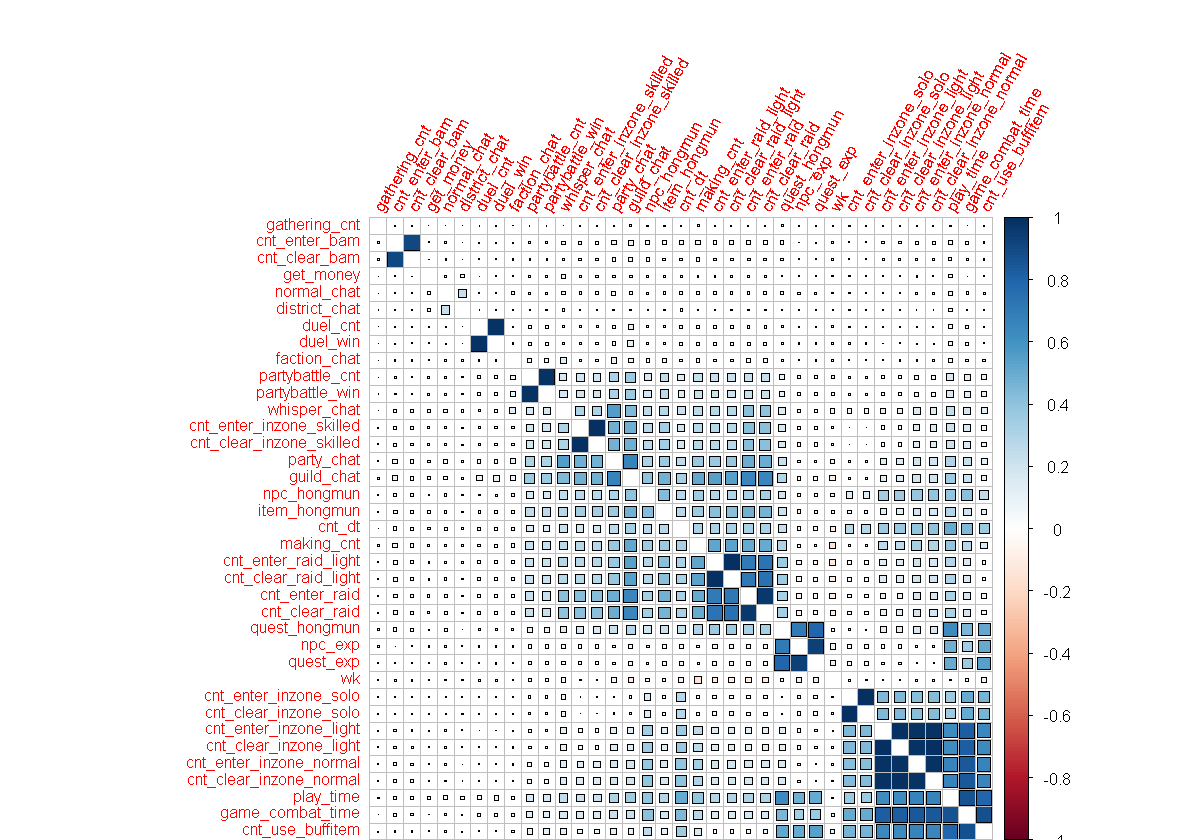

In [7]:
cor.df <- cor(activity %>% select(-acc_id))
corrplot(cor.df, method = "square", order = "hclust", tl.cex = 0.8,
         tl.srt = 60, diag = F, outline = T)

## 2.2 Time variables
* wk
* cnt_dt
* play_time

In [8]:
time_temp <- activity %>% 
  mutate(play_time_new = (play_time - min(play_time))/(max(play_time) - min(play_time))) %>%
  select(acc_id, wk, cnt_dt, play_time, play_time_new)

In [9]:
summary(time_temp %>% select(-acc_id))

       wk            cnt_dt        play_time         play_time_new    
 Min.   :1.000   Min.   :1.000   Min.   :-0.661667   Min.   :0.00000  
 1st Qu.:3.000   1st Qu.:3.000   1st Qu.:-0.655209   1st Qu.:0.00108  
 Median :5.000   Median :5.000   Median :-0.528866   Median :0.02220  
 Mean   :5.155   Mean   :4.421   Mean   :-0.005621   Mean   :0.10967  
 3rd Qu.:7.000   3rd Qu.:6.000   3rd Qu.: 0.339870   3rd Qu.:0.16743  
 Max.   :8.000   Max.   :7.000   Max.   : 5.320199   Max.   :1.00000  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


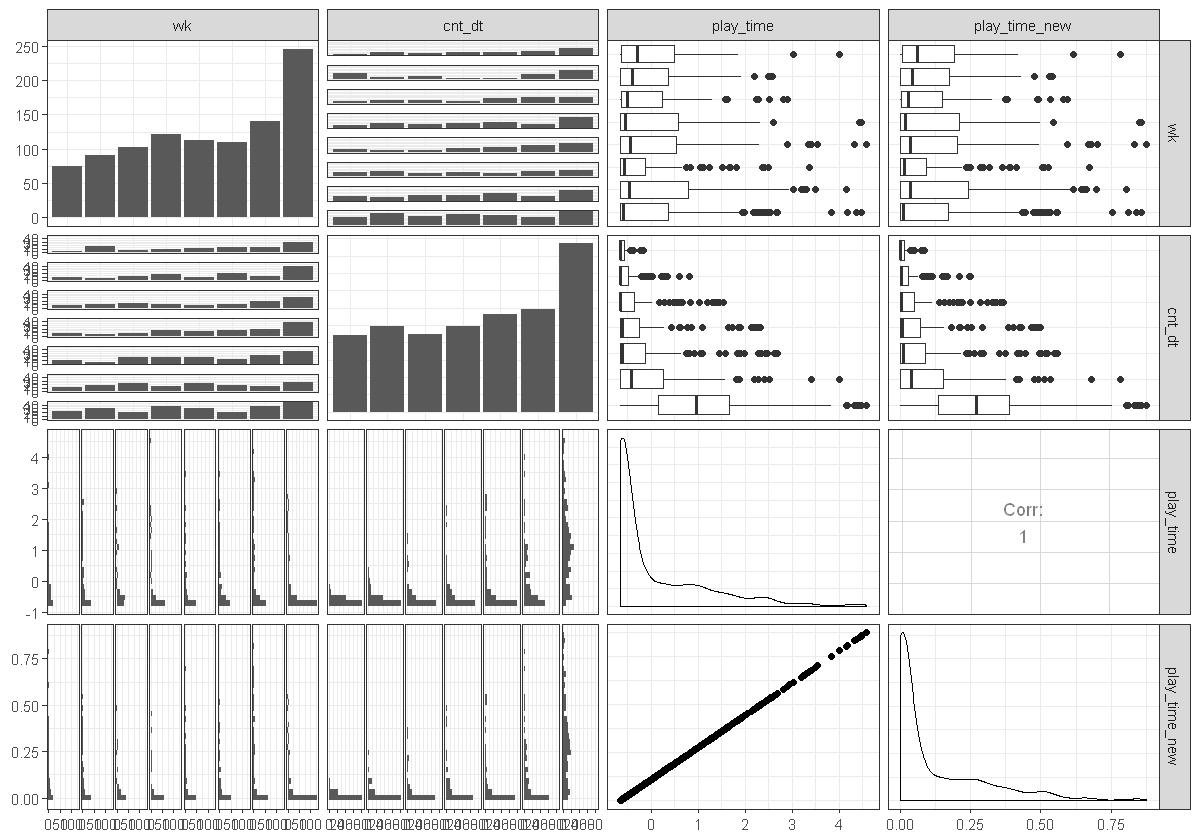

In [10]:
ggpairs(time_temp %>% select(-acc_id) %>% 
          mutate(wk = factor(wk, ordered = T), cnt_dt = factor(cnt_dt, ordered = T)) %>% sample_n(1000))

* 8주차에는 모든 유저가 접속
* 7번 접속한 사람이 플레이 타임이 높음 - 당연한거

In [11]:
time <- time_temp %>% 
  group_by(acc_id) %>%
  summarize(wk_num = n(),
            acc_num = sum(cnt_dt),
            acc_mean = mean(cnt_dt),
            time_sum = sum(play_time_new),
            time_wk_mean = mean(play_time_new)) %>%
  mutate(time_acc_mean = time_sum / acc_num) %>%
  left_join(label, by = "acc_id"); head(time)

acc_id,wk_num,acc_num,acc_mean,time_sum,time_wk_mean,time_acc_mean,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,2,12,6.000000,1.434052579,0.7170262897,1.195044e-01,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,8,25,3.125000,0.001299603,0.0001624504,5.198413e-05,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,5,12,2.400000,0.003850860,0.0007701720,3.209050e-04,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,6,31,5.166667,0.158948413,0.0264914021,5.127368e-03,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2,3,1.500000,0.002157738,0.0010788690,7.192460e-04,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,8,39,4.875000,0.234343585,0.0292929481,6.008810e-03,month


In [12]:
summary(time)

    acc_id              wk_num         acc_num         acc_mean    
 Length:100000      Min.   :1.000   Min.   : 1.00   Min.   :1.000  
 Class :character   1st Qu.:1.000   1st Qu.: 4.00   1st Qu.:2.600  
 Mode  :character   Median :5.000   Median :14.00   Median :4.000  
                    Mean   :4.403   Mean   :19.47   Mean   :3.887  
                    3rd Qu.:7.000   3rd Qu.:30.00   3rd Qu.:5.000  
                    Max.   :8.000   Max.   :56.00   Max.   :7.000  
    time_sum         time_wk_mean       time_acc_mean            label      
 Min.   :0.000002   Min.   :0.0000017   Min.   :1.650e-06   retained:25000  
 1st Qu.:0.003848   1st Qu.:0.0011164   1st Qu.:3.297e-04   2month  :25000  
 Median :0.086428   Median :0.0188056   Median :5.713e-03   month   :25000  
 Mean   :0.482913   Mean   :0.1073895   Mean   :2.462e-02   week    :25000  
 3rd Qu.:0.545754   3rd Qu.:0.1666063   3rd Qu.:4.042e-02                   
 Max.   :7.470863   Max.   :0.9338579   Max.   :1.389e-01     

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


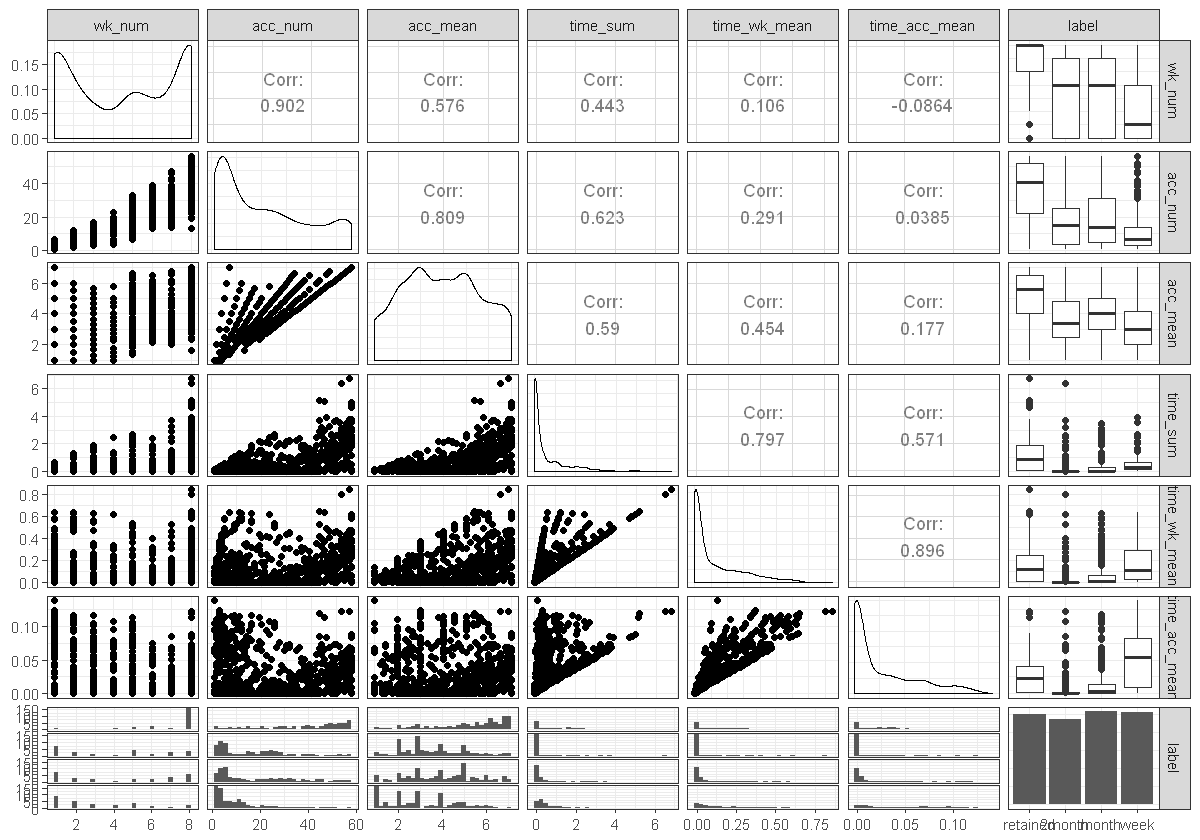

In [13]:
ggpairs(time %>% sample_n(1000) %>% select(-acc_id))

* retained는 churn(week / month / 2month)에 비해 접속한 주 / 접속한 수가 높음
* retained는 churn(week / month / 2month)에 비해 주 당 평균 접속한 횟수가 높음
* retained와 week이 month / 2month에 비해 주 당 평균 플레이타임이 높음
* retained와 week이 month / 2month에 비해 접속 당 평균 플레이타임이 높음

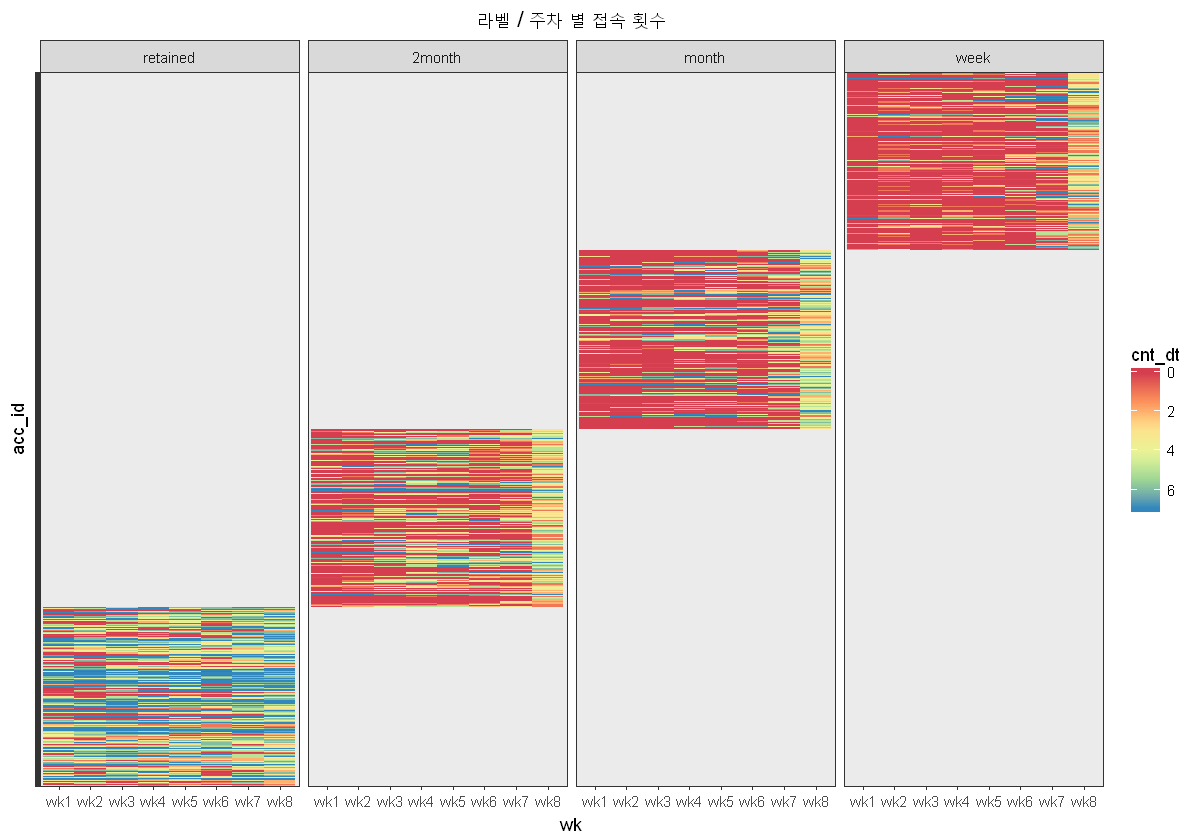

In [14]:
set.seed(1843)
label_week_heatmap(activity, "cnt_dt", is_normalized = F, sample_num = 2500) + labs(title = "라벨 / 주차 별 접속 횟수")

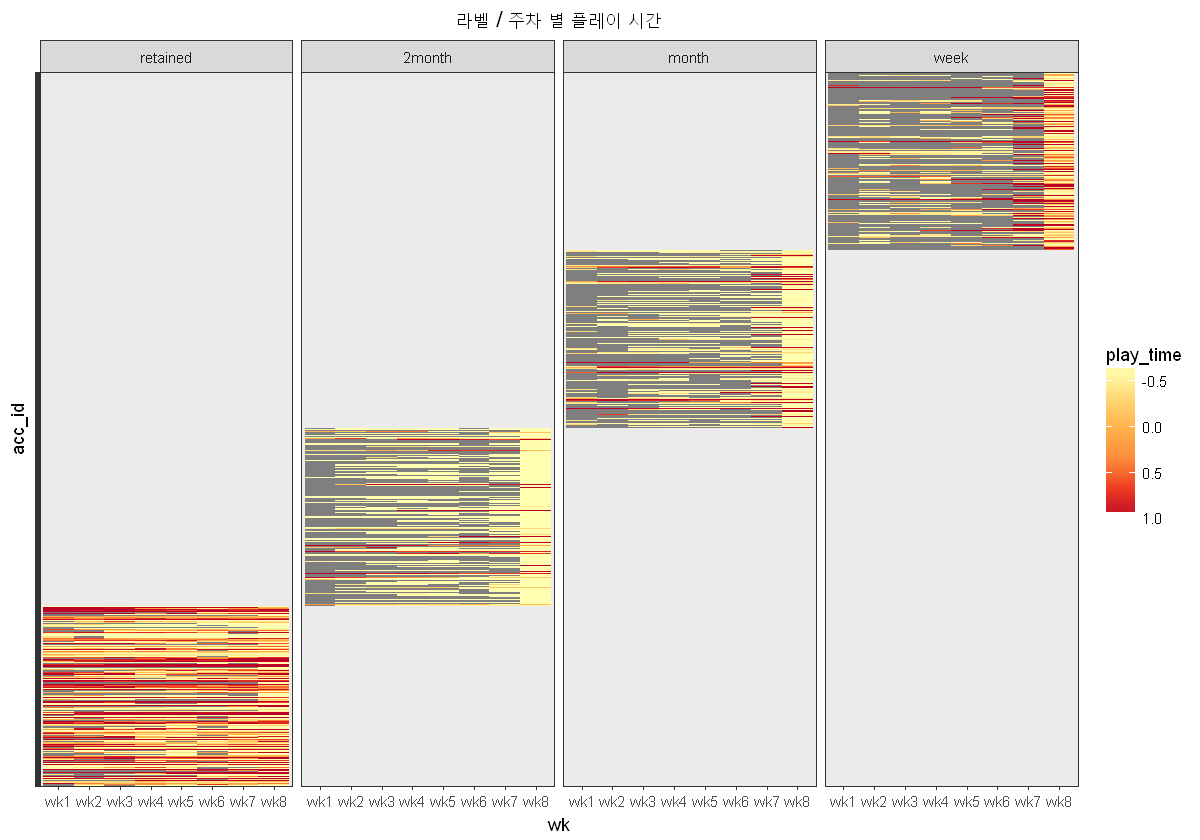

In [15]:
set.seed(8768)
label_week_heatmap(activity, "play_time", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 플레이 시간")

* retained가 play_time이 8주동안 고르게 높고, week은 7주, 8주차에 플레이 타임이 높음

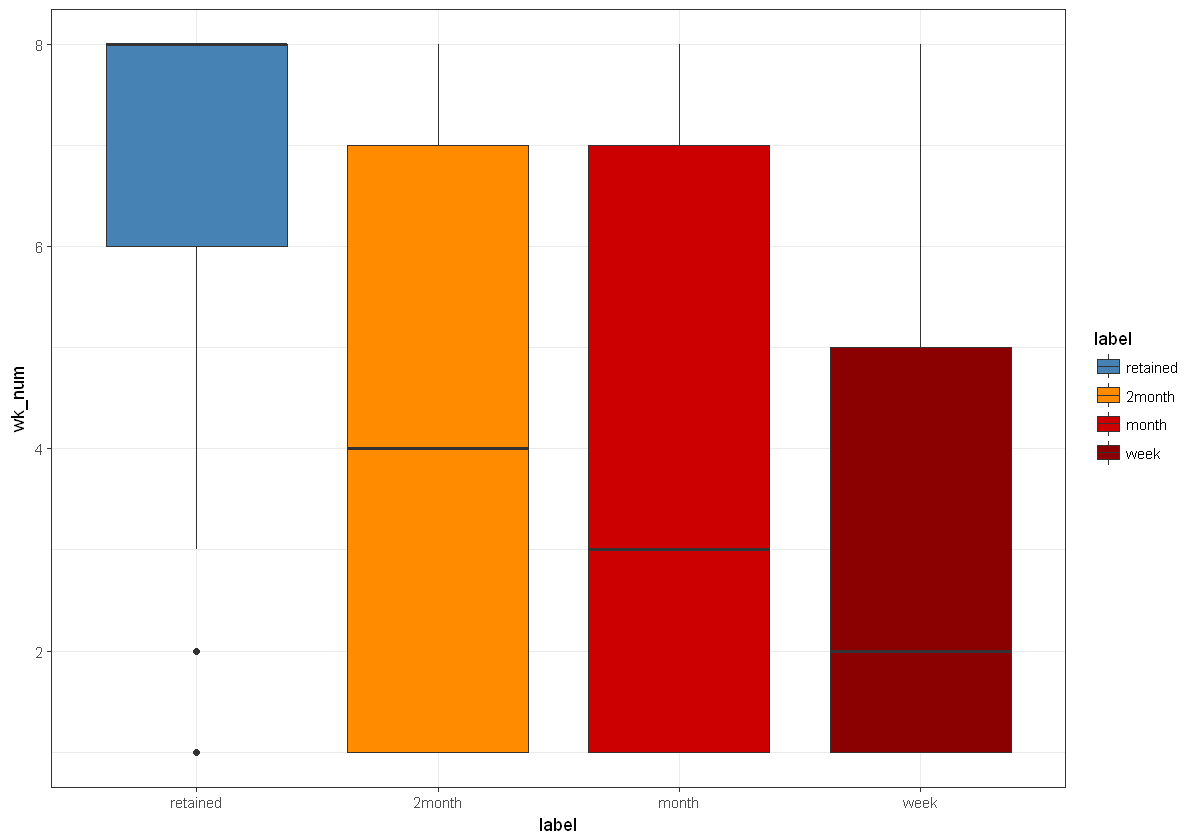

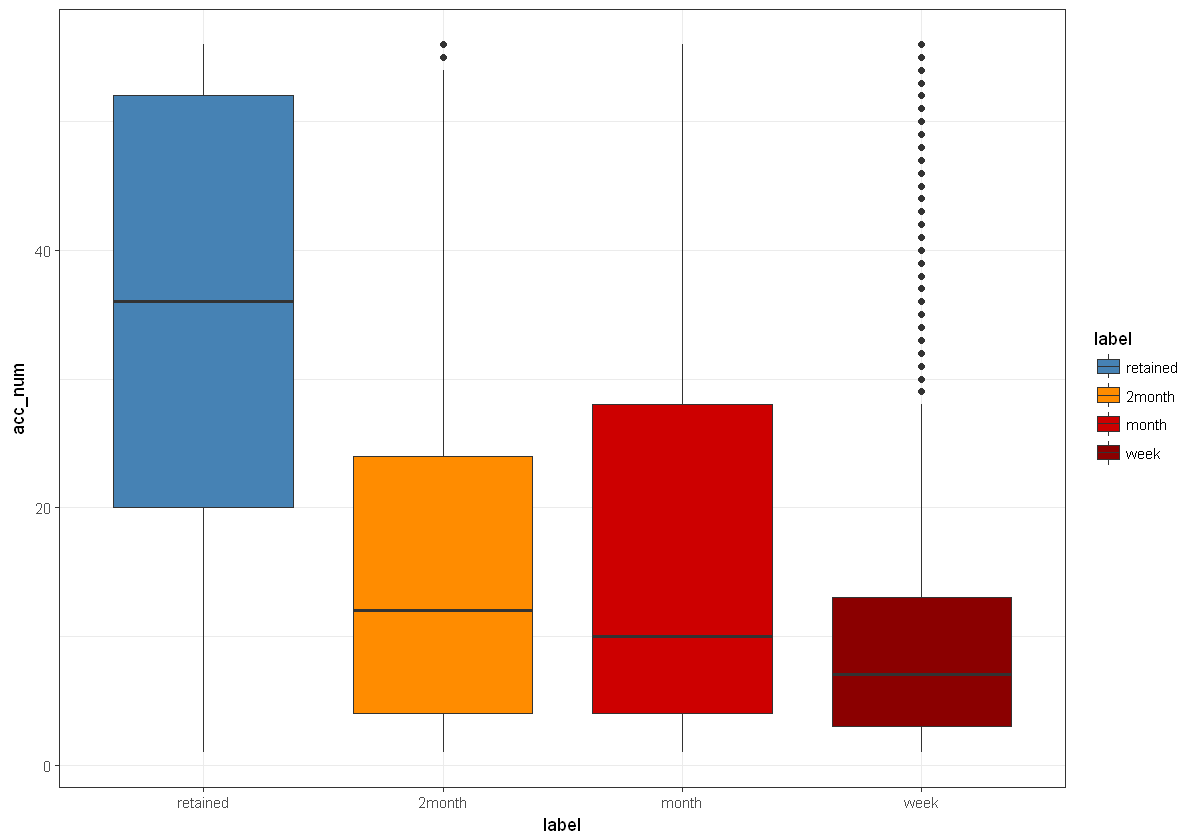

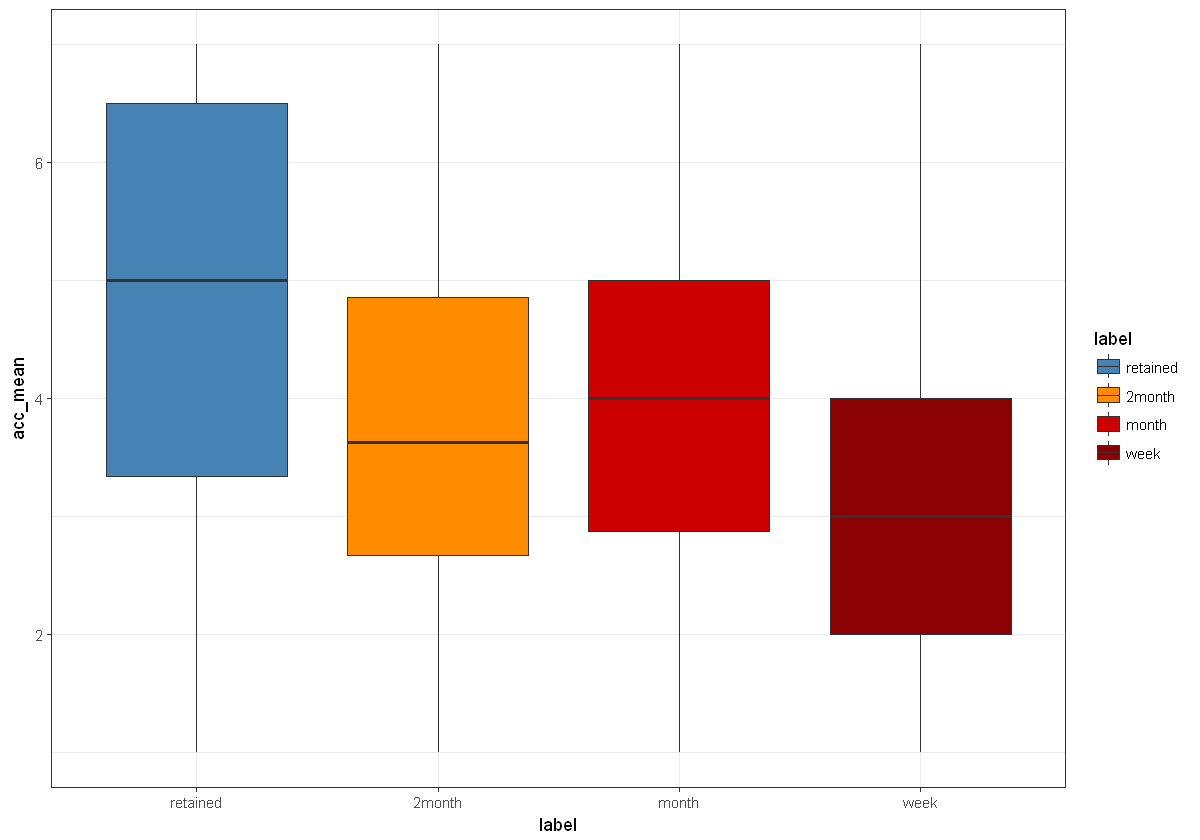

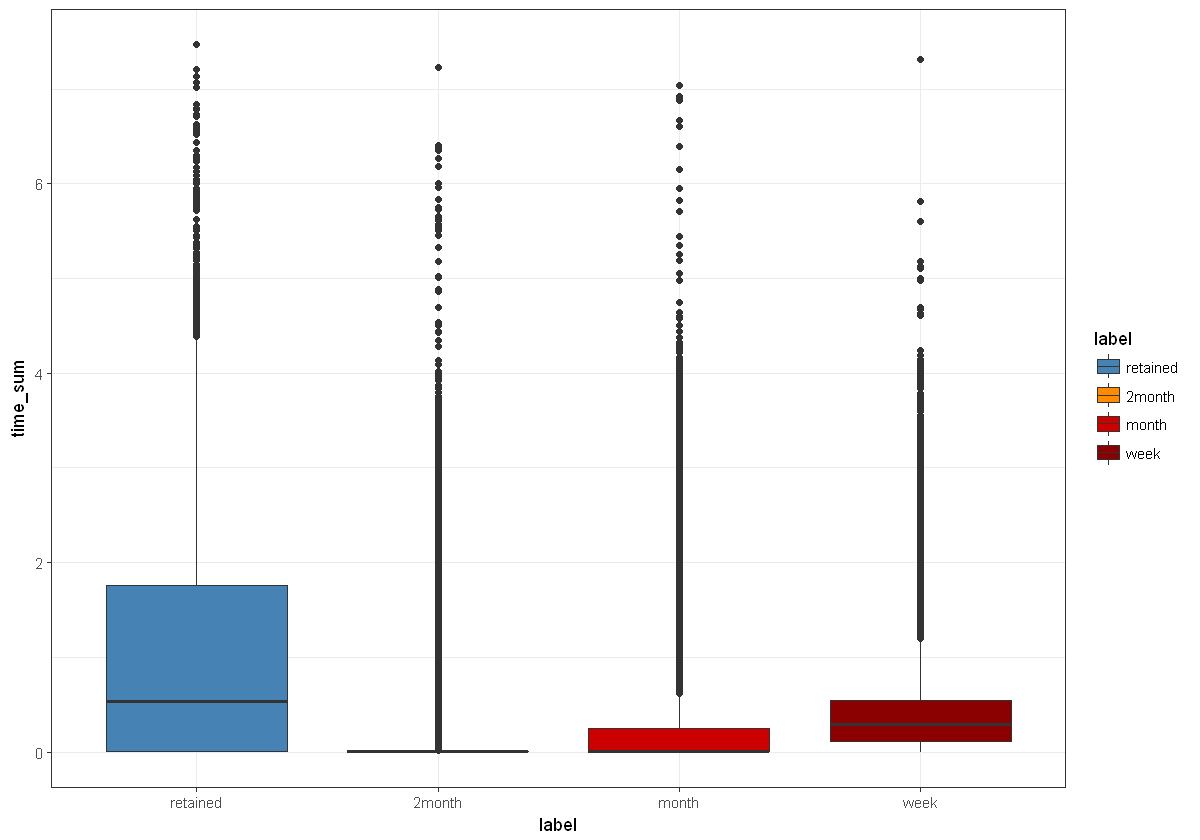

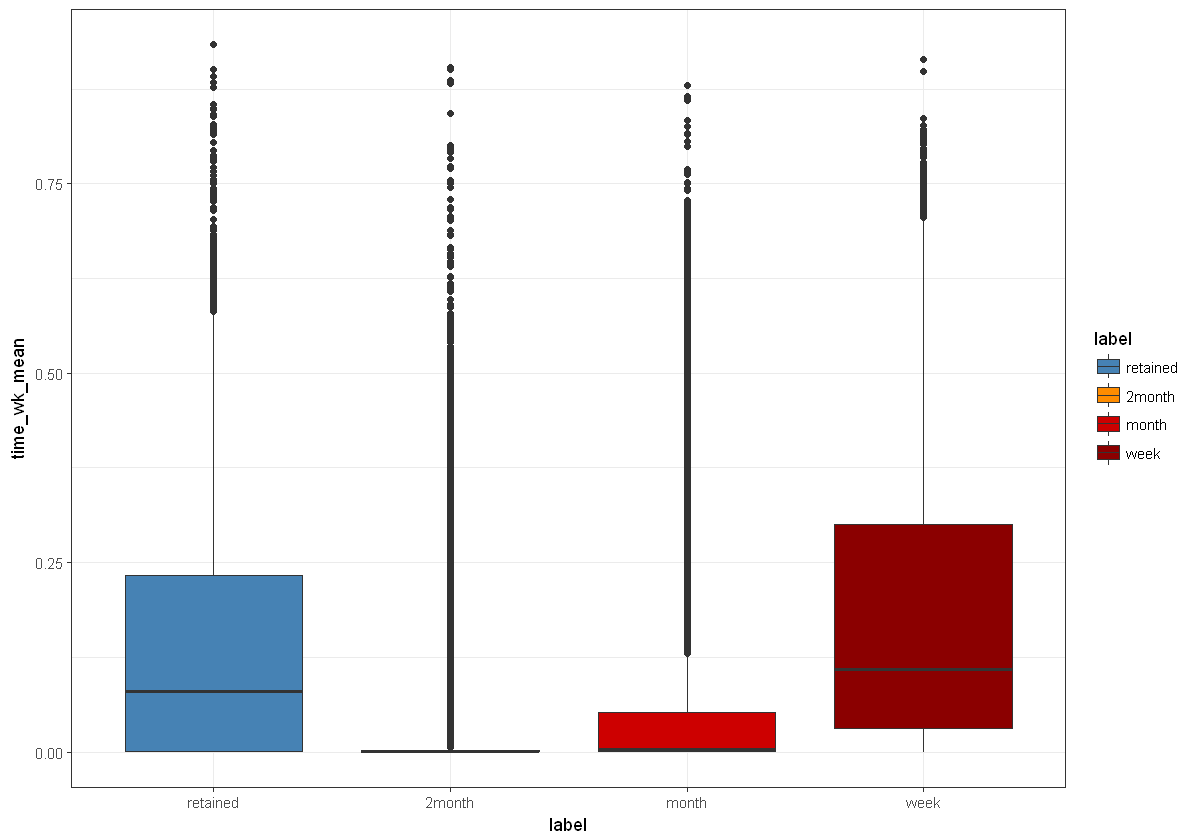

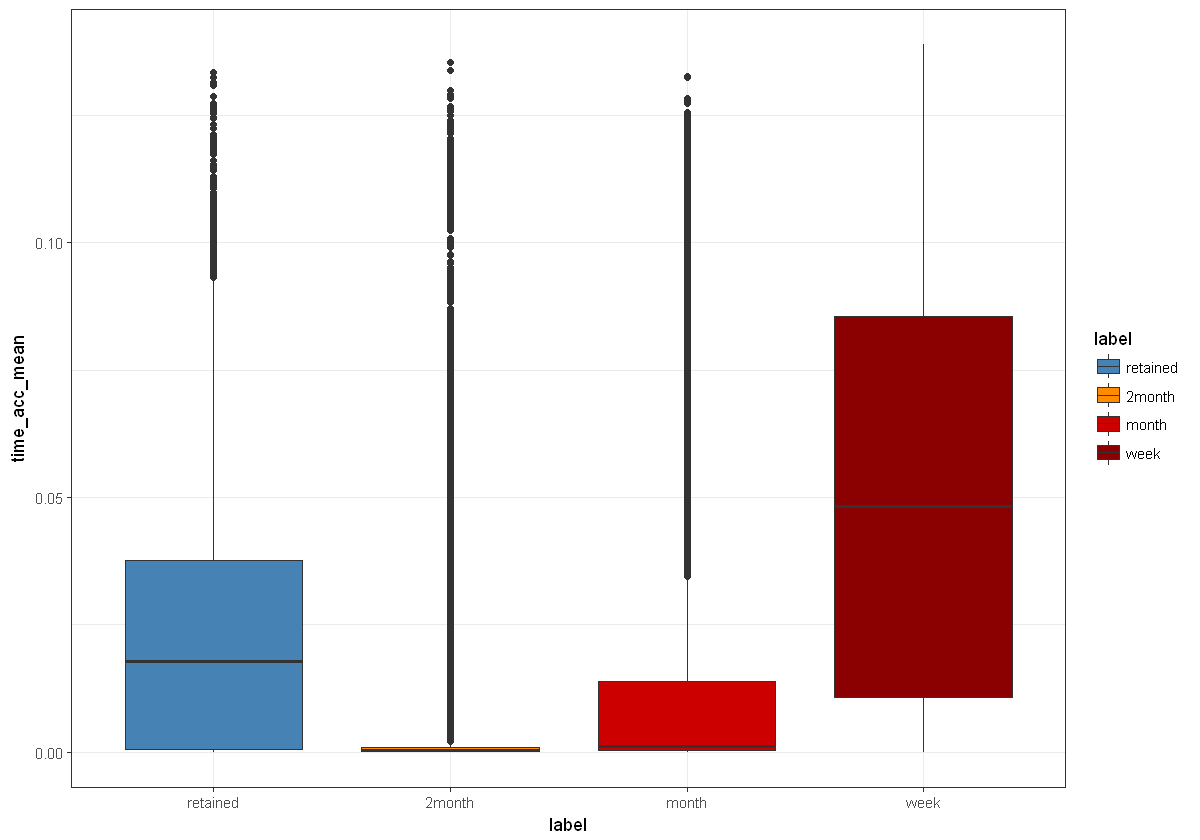

In [16]:
ggplot(time, aes(label, wk_num, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred"))
ggplot(time, aes(label, acc_num, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred"))
ggplot(time, aes(label, acc_mean, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred"))
ggplot(time, aes(label, time_sum, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred"))
ggplot(time, aes(label, time_wk_mean, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred"))
ggplot(time, aes(label, time_acc_mean, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred"))

## 2.3 EXP variables
* npc_exp
* npc_hongmun
* quest_exp
* quest_hongmun
* item_hongmun

    npc_exp          npc_hongmun          quest_exp         quest_hongmun     
 Min.   :-0.23187   Min.   : -0.29080   Min.   :-0.250423   Min.   :-0.48767  
 1st Qu.:-0.23187   1st Qu.: -0.29080   1st Qu.:-0.250423   1st Qu.:-0.48767  
 Median :-0.23187   Median : -0.28259   Median :-0.250423   Median :-0.46057  
 Mean   :-0.00329   Mean   : -0.00330   Mean   :-0.003054   Mean   :-0.00494  
 3rd Qu.:-0.23187   3rd Qu.: -0.00614   3rd Qu.:-0.250423   3rd Qu.: 0.03390  
 Max.   :32.70345   Max.   :135.16662   Max.   :10.566449   Max.   :47.50375  
  item_hongmun     
 Min.   :-0.30635  
 1st Qu.:-0.30635  
 Median :-0.30635  
 Mean   :-0.00341  
 3rd Qu.:-0.11938  
 Max.   :61.82296  

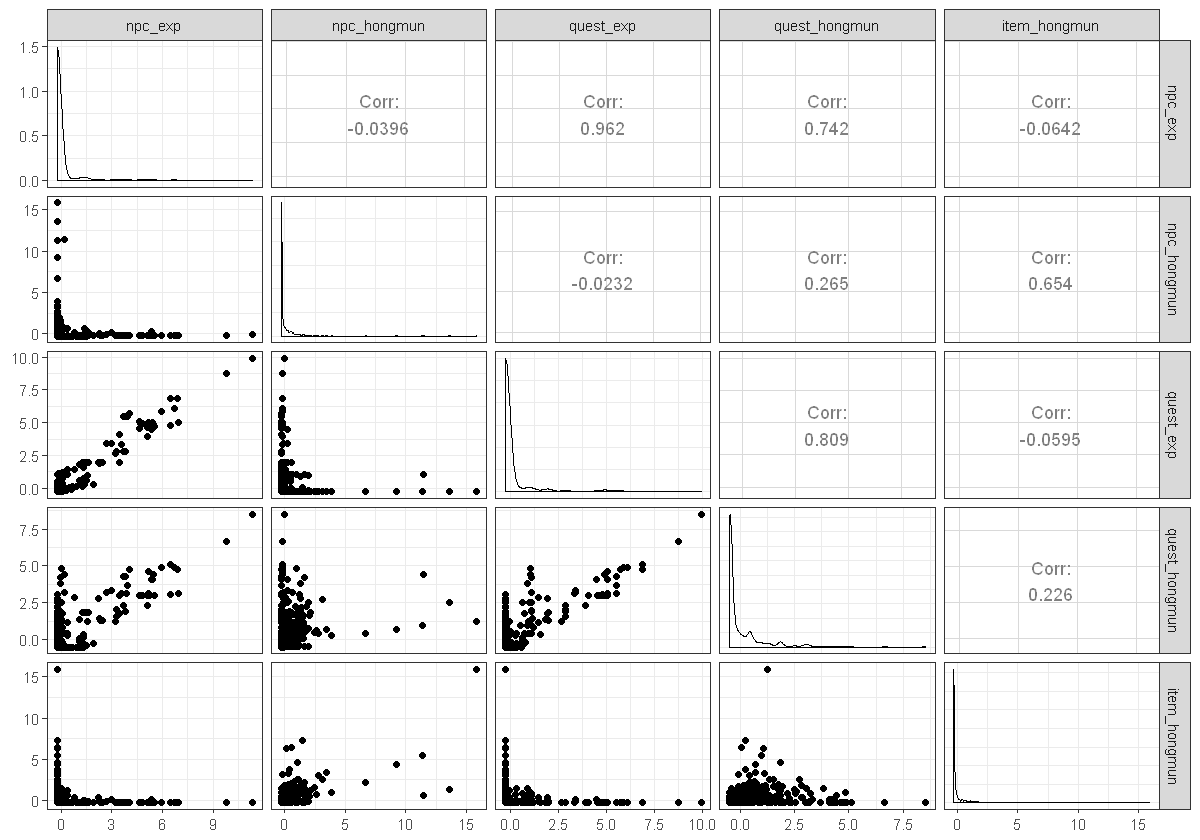

In [17]:
summary(activity %>% select(npc_exp, npc_hongmun, quest_exp, quest_hongmun, item_hongmun))
ggpairs(activity %>% sample_n(1000),
       columns = c("npc_exp", "npc_hongmun", "quest_exp", "quest_hongmun", "item_hongmun"))

* npc_exp와 npc_hongmun의 상관관계가 없음
* QUEST를 수행하면서 NPC 사냥도 같이 하기 때문에 npc_exp와 quest_exp의 상관관계가 높음
* QUEST를 완료하면 퀘스트 일반 경험치와 퀘스트 홍문 경험치를 같이 주기 때문에 npc_exp / quest_exp / quest_hongmun의 상관관계가 높나?

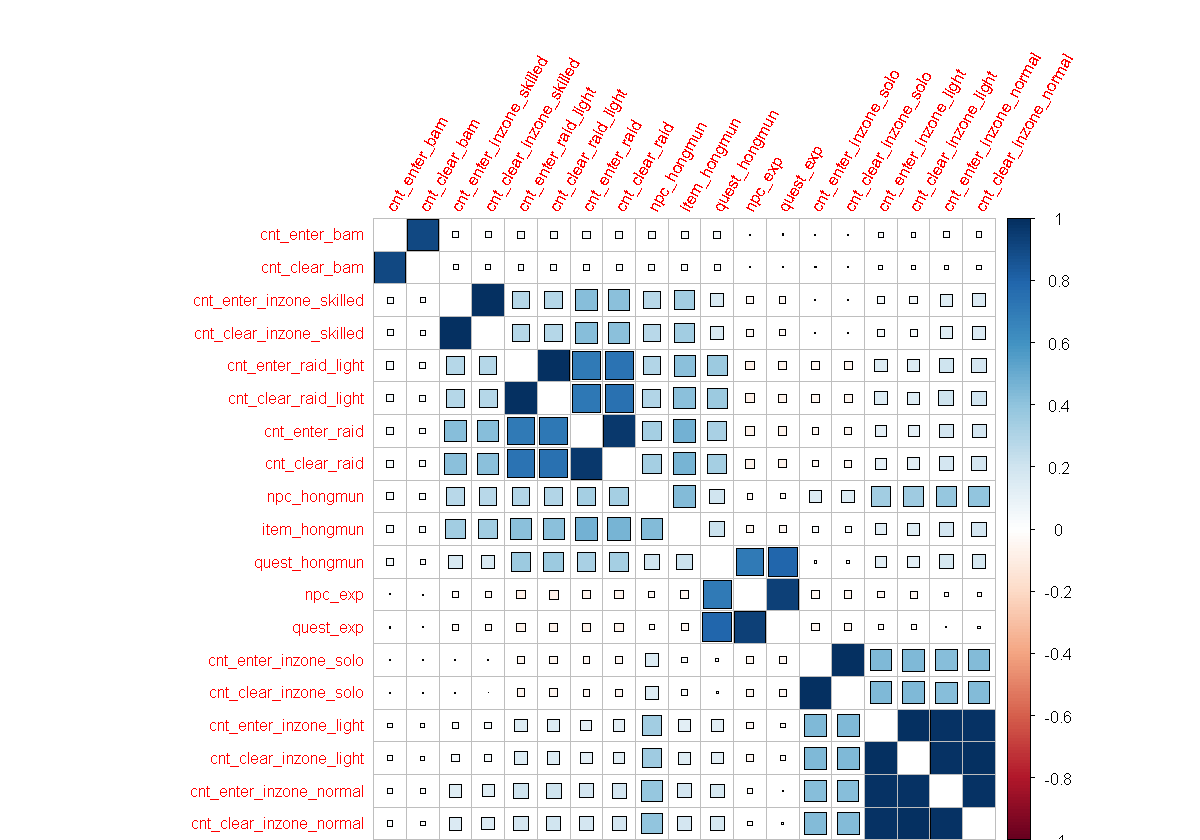

In [23]:
cor.df.temp <- cor(activity[,c(5,6,7,8,9,16:29)])
corrplot(cor.df.temp, method = "square", order = "hclust", tl.cex = 0.8,
         tl.srt = 60, diag = F, outline = T)

* 일반 경험치의 경우 던전 관련 변수들과 상관관계가 매우 낮음
* 홍문 경험치의 경우 던전 관련 변수들과 상관관계가 어느정도 있음

* 초보 : quest와 npc 사냥으로 일반 경험치 획득 => 1레벨 ~ 55레벨
* 중수 : solo/light/normal inzone에서 quest와 npc 사냥으로 홍문 경험치 획득 => 1성 ~ 10성?
* 고수 : skilled inzone / raid / light raid에서 quest와 npc 사냥으로 홍문 경험치 획득 & item 홍문 경험치 획득

In [24]:
exp <- activity %>%
  mutate(npc_exp_new = (npc_exp - min(npc_exp))/(max(npc_exp) - min(npc_exp)),
         npc_hongmun_new = (npc_hongmun - min(npc_hongmun))/(max(npc_hongmun) - min(npc_hongmun)),
         quest_exp_new = (quest_exp - min(quest_exp))/(max(quest_exp) - min(quest_exp)),
         quest_hongmun_new = (quest_hongmun - min(quest_hongmun))/(max(quest_hongmun) - min(quest_hongmun)),
         item_hongmun_new = (item_hongmun - min(item_hongmun))/(max(item_hongmun) - min(item_hongmun))) %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            npc_exp_wk_mean = mean(npc_exp_new),
            npc_exp_sum = sum(npc_exp_new),
            npc_hongmun_wk_mean = mean(npc_hongmun_new),
            npc_hongmun_sum = sum(npc_hongmun_new),
            quest_exp_wk_mean = mean(quest_exp_new),
            quest_exp_sum = sum(quest_exp_new),
            quest_hongmun_wk_mean = mean(quest_hongmun_new),
            quest_hongmun_sum = sum(quest_hongmun_new),
            item_hongmun_wk_mean = mean(item_hongmun_new),
            item_hongmun_sum = sum(item_hongmun_new)) %>%
  mutate(npc_exp_acc_mean = npc_exp_sum / acc_num,
         npc_hongmun_acc_mean = npc_hongmun_sum / acc_num,
         quest_exp_acc_mean = quest_exp_sum / acc_num,
         quest_hongmun_acc_mean = quest_hongmun_sum / acc_num,
         item_hongmun_acc_mean = item_hongmun_sum / acc_num) %>%
  left_join(label, by = "acc_id")
head(exp)

acc_id,acc_num,npc_exp_wk_mean,npc_exp_sum,npc_hongmun_wk_mean,npc_hongmun_sum,quest_exp_wk_mean,quest_exp_sum,quest_hongmun_wk_mean,quest_hongmun_sum,item_hongmun_wk_mean,item_hongmun_sum,npc_exp_acc_mean,npc_hongmun_acc_mean,quest_exp_acc_mean,quest_hongmun_acc_mean,item_hongmun_acc_mean,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,12,1.904897e-01,0.3809793534,0.0003876908,0.0007753815,6.541865e-01,1.3083729123,0.1128244073,0.225648815,0.000000e+00,0.0000000000,3.174828e-02,6.461513e-05,0.1090310760,0.0188040679,0.000000e+00,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,25,0.000000e+00,0.0000000000,0.0000000000,0.0000000000,0.000000e+00,0.0000000000,0.0000000000,0.000000000,0.000000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.0000000000,0.0000000000,0.000000e+00,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,12,5.182939e-06,0.0000259147,0.0000000000,0.0000000000,8.219688e-05,0.0004109844,0.0000000000,0.000000000,0.000000e+00,0.0000000000,2.159558e-06,0.000000e+00,0.0000342487,0.0000000000,0.000000e+00,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,31,1.505212e-03,0.0090312716,0.0000363799,0.0002182794,2.059520e-02,0.1235712206,0.0069964745,0.041978847,4.458414e-05,0.0002675048,2.913313e-04,7.041271e-06,0.0039861684,0.0013541564,8.629189e-06,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,3,1.295735e-05,0.0000259147,0.0000000000,0.0000000000,2.054922e-04,0.0004109844,0.0000000000,0.000000000,0.000000e+00,0.0000000000,8.638232e-06,0.000000e+00,0.0001369948,0.0000000000,0.000000e+00,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,39,0.000000e+00,0.0000000000,0.0002422806,0.0019382450,0.000000e+00,0.0000000000,0.0006883707,0.005506965,3.427406e-04,0.0027419247,0.000000e+00,4.969859e-05,0.0000000000,0.0001412042,7.030576e-05,month


In [25]:
summary(exp)

    acc_id             acc_num      npc_exp_wk_mean      npc_exp_sum       
 Length:100000      Min.   : 1.00   Min.   :0.0000000   Min.   :0.0000000  
 Class :character   1st Qu.: 4.00   1st Qu.:0.0000000   1st Qu.:0.0000000  
 Mode  :character   Median :14.00   Median :0.0000065   Median :0.0000259  
                    Mean   :19.47   Mean   :0.0135222   Mean   :0.0305599  
                    3rd Qu.:30.00   3rd Qu.:0.0021982   3rd Qu.:0.0103717  
                    Max.   :56.00   Max.   :0.4271492   Max.   :2.7555208  
 npc_hongmun_wk_mean npc_hongmun_sum    quest_exp_wk_mean  quest_exp_sum     
 Min.   :0.0000000   Min.   :0.000000   Min.   :0.000000   Min.   :0.000000  
 1st Qu.:0.0000000   1st Qu.:0.000000   1st Qu.:0.000000   1st Qu.:0.000000  
 Median :0.0000141   Median :0.000052   Median :0.000137   Median :0.000411  
 Mean   :0.0014506   Mean   :0.009346   Mean   :0.043711   Mean   :0.100697  
 3rd Qu.:0.0012742   3rd Qu.:0.005317   3rd Qu.:0.024533   3rd Qu.:0.123571  


In [26]:
exp_temp <- exp %>% select(-acc_num) %>% 
  gather(key = "exp", value = "value", -acc_id, -label) %>%
  mutate(type = ifelse(str_detect(exp, "exp"), "normal", "hongmun"))
head(exp_temp)

acc_id,label,exp,value,type
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,week,npc_exp_wk_mean,1.904897e-01,normal
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,retained,npc_exp_wk_mean,0.000000e+00,normal
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,retained,npc_exp_wk_mean,5.182939e-06,normal
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,month,npc_exp_wk_mean,1.505212e-03,normal
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2month,npc_exp_wk_mean,1.295735e-05,normal
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,month,npc_exp_wk_mean,0.000000e+00,normal


Warning message:
"Removed 19213 rows containing non-finite values (stat_boxplot)."

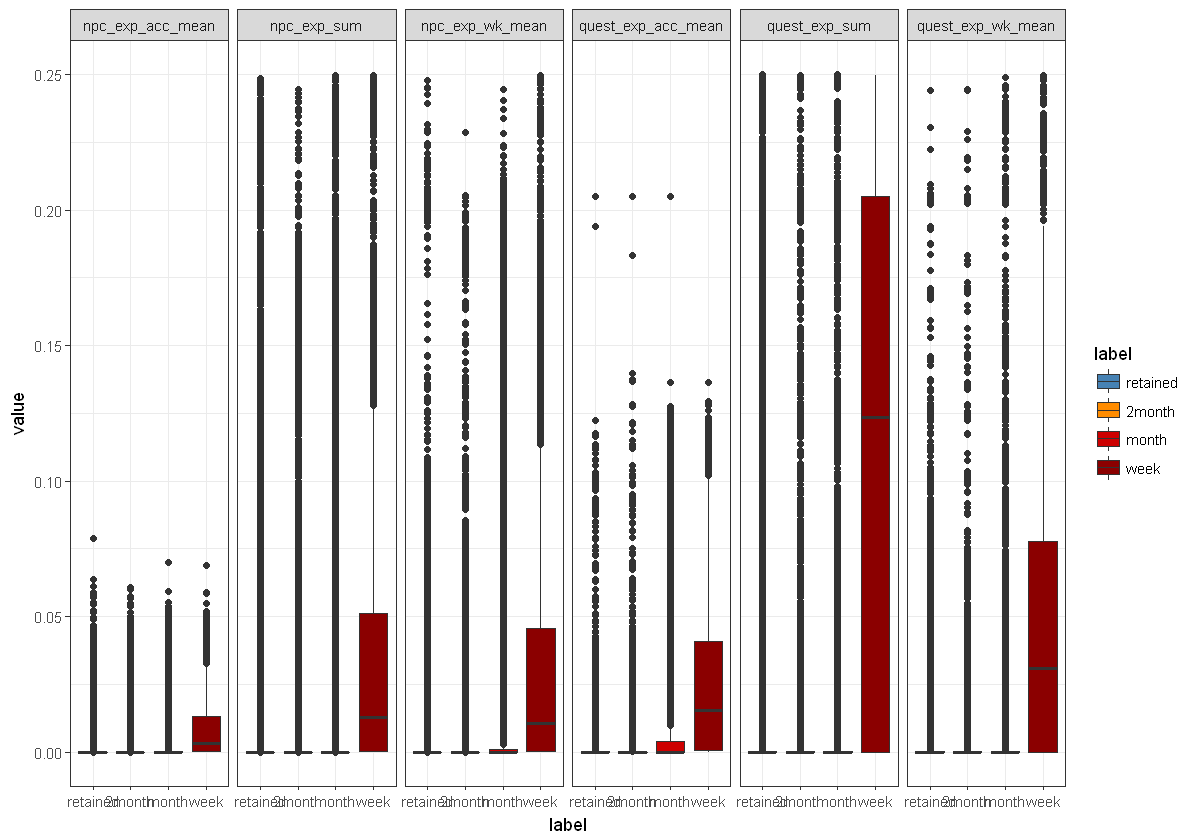

In [27]:
exp_temp %>% filter(type == "normal") %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  ylim(c(0, 0.25)) + 
  facet_grid(. ~ exp, scales = "free")

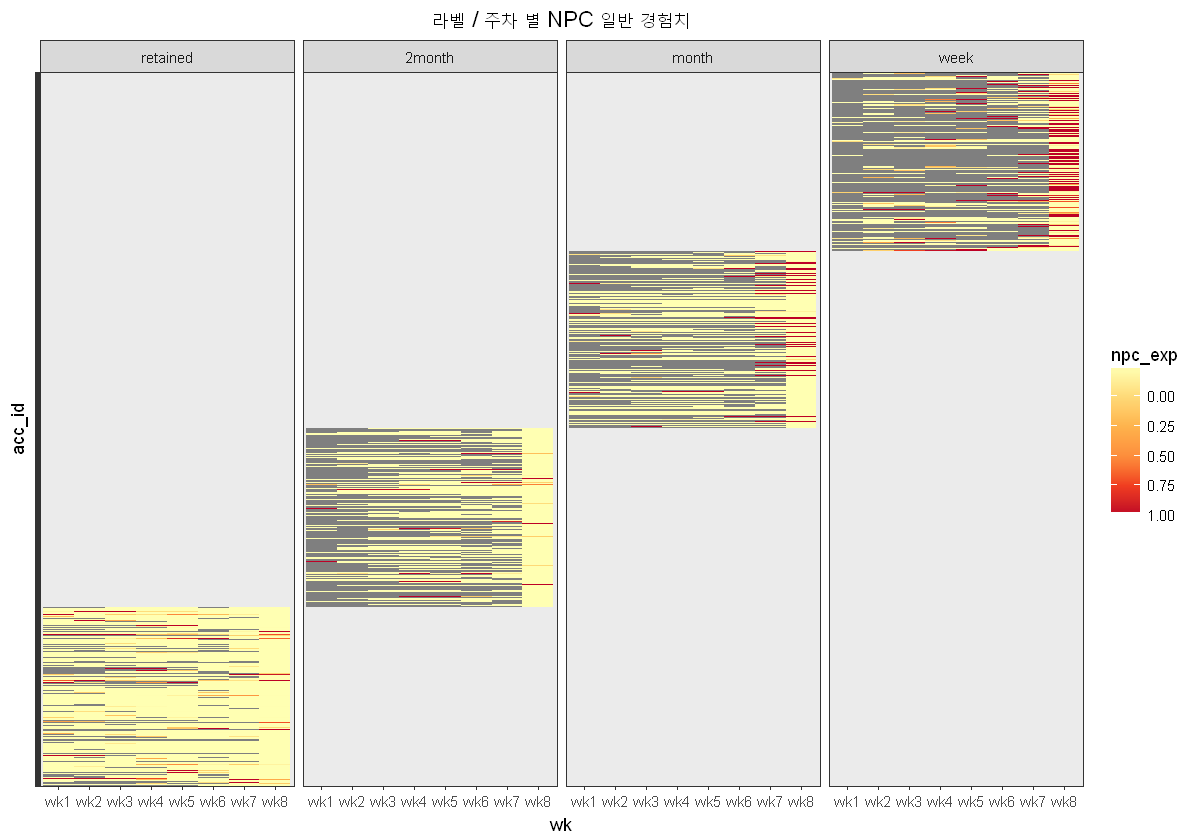

In [28]:
set.seed(6453)
label_week_heatmap(activity, "npc_exp", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 NPC 일반 경험치")

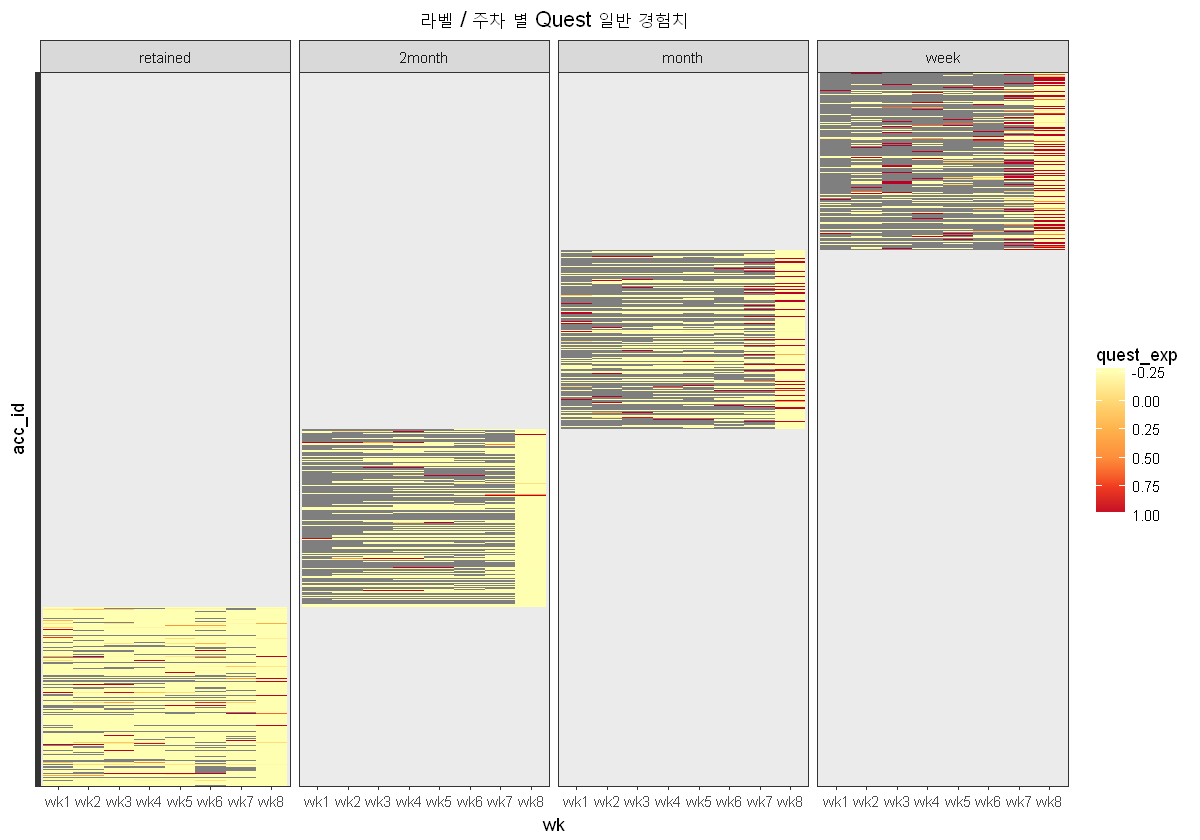

In [29]:
set.seed(6454)
label_week_heatmap(activity, "quest_exp", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 Quest 일반 경험치")

* week는 다른 유형에 비해 일반 경험치(npc_exp, quest_exp)를 많이 얻음 => 초보 유저?

Warning message:
"Removed 2533 rows containing non-finite values (stat_boxplot)."

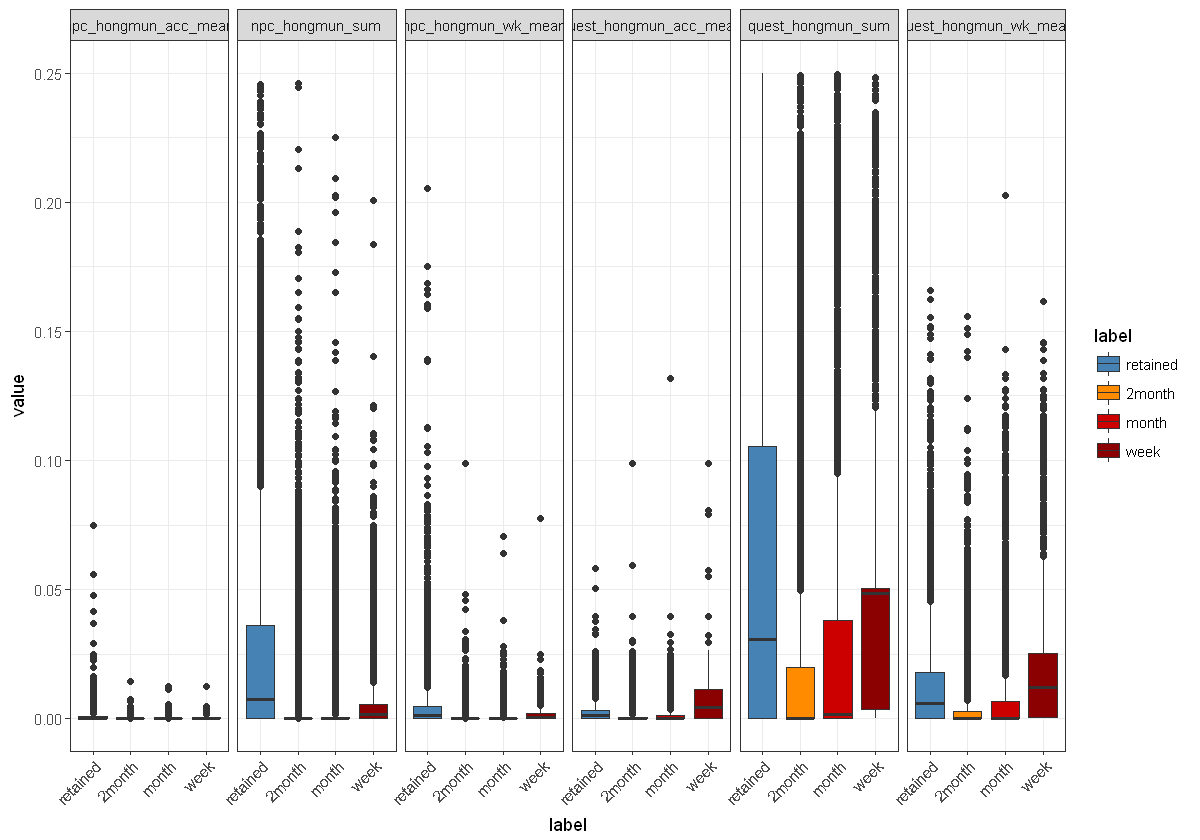

In [30]:
exp_temp %>% filter(type == "hongmun" & !str_detect(exp, "item")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 0.25)) +
  facet_grid(. ~ exp)

Warning message:
"Removed 1452 rows containing non-finite values (stat_boxplot)."

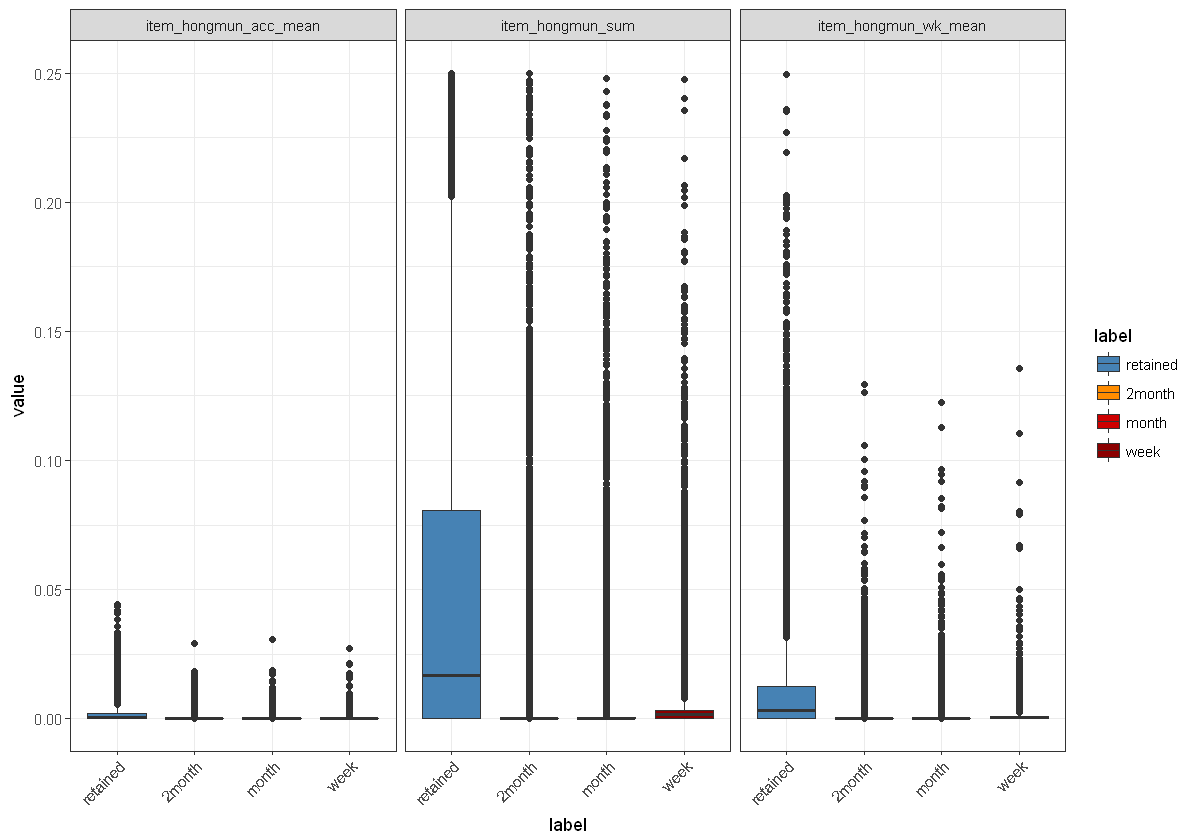

In [31]:
exp_temp %>% filter(type == "hongmun" & str_detect(exp, "item")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 0.25)) +
  facet_grid(. ~ exp)

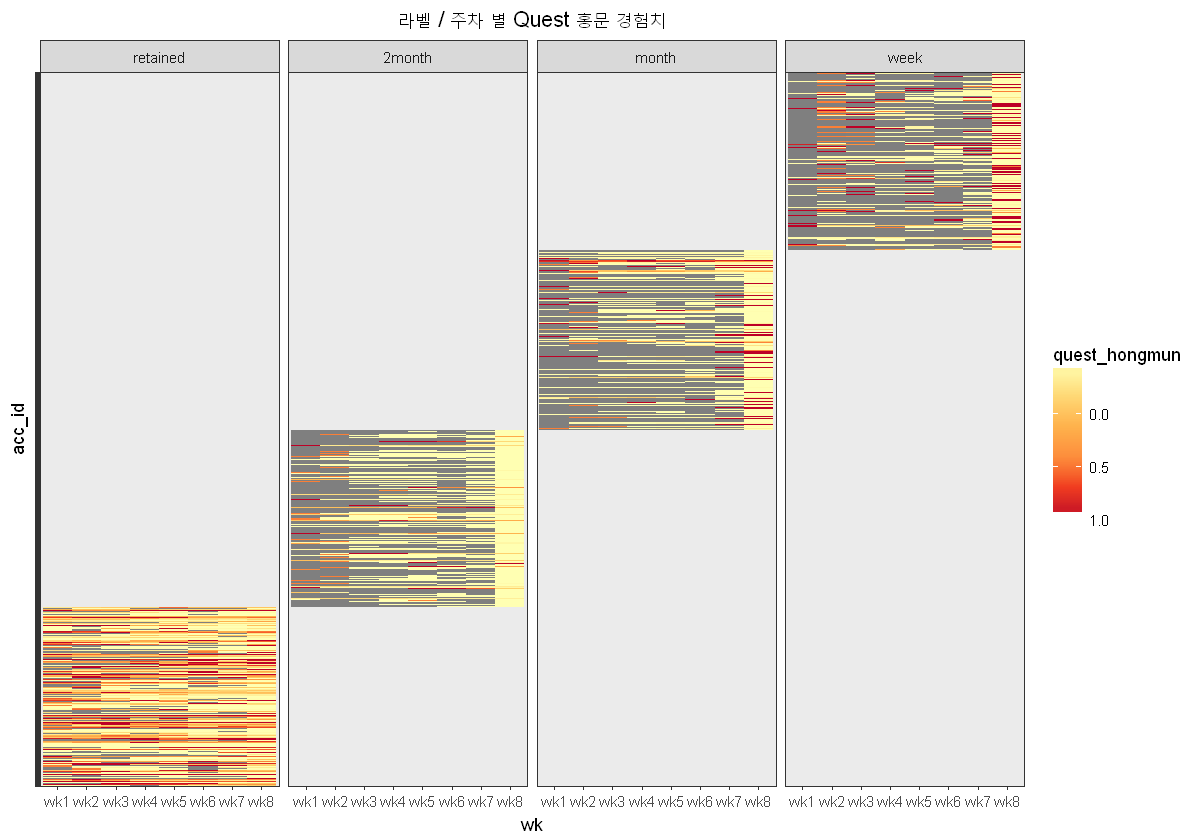

In [32]:
set.seed(6456)
label_week_heatmap(activity, "quest_hongmun", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 Quest 홍문 경험치")

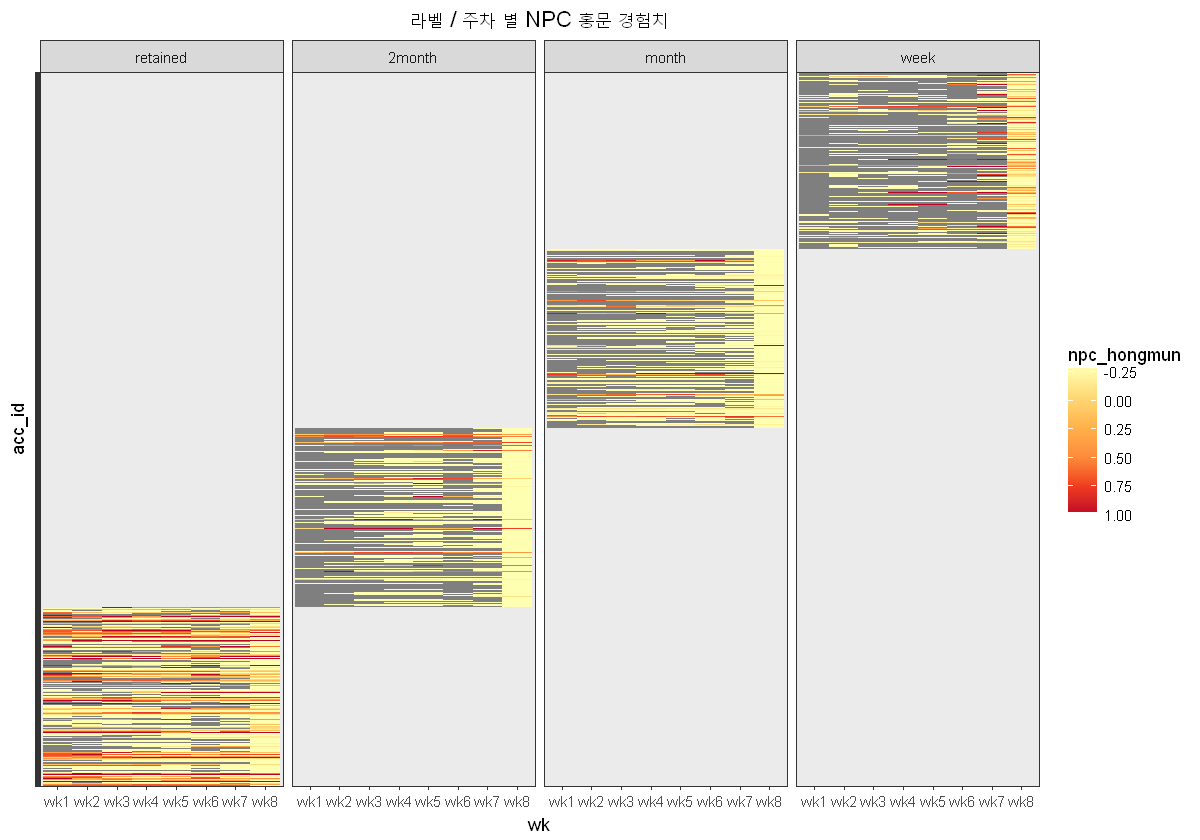

In [33]:
set.seed(6455)
label_week_heatmap(activity, "npc_hongmun", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 NPC 홍문 경험치")

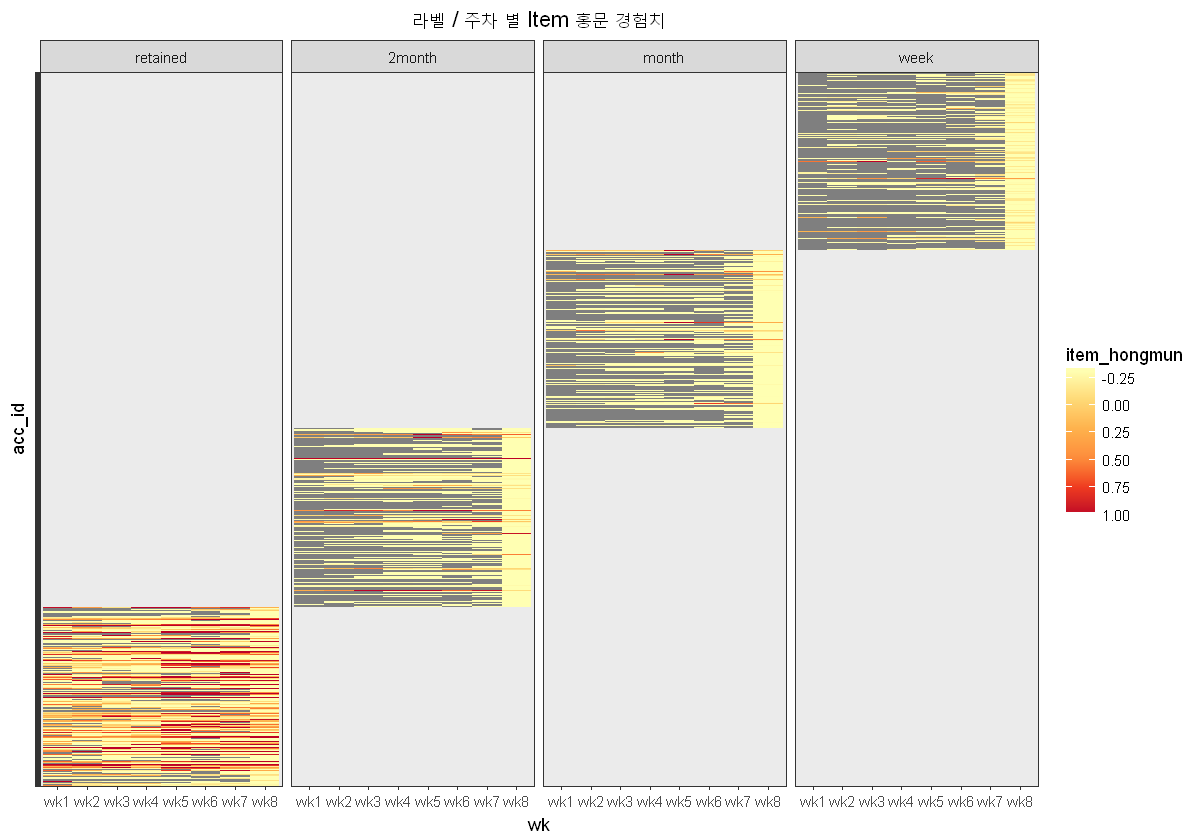

In [34]:
set.seed(6457)
label_week_heatmap(activity, "item_hongmun", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 Item 홍문 경험치")

* retained는 다른 유형에 비해 홍문 경험치를 많이 얻음 => 고수?
* week는 month / 2month에 비해 퀘스트 홍문 경험치를 많이 얻음 => 퀘스트 일반 경험치를 얻으면서 같이 얻어서?

## 2.4 Battle variables
* duel_cnt
* duel_win
* partybattle_cnt
* partybattle_win

In [35]:
summary(activity %>% select(duel_cnt, duel_win, partybattle_cnt, partybattle_win))

    duel_cnt            duel_win         partybattle_cnt    partybattle_win   
 Min.   : -0.03617   Min.   : -0.04133   Min.   :-0.16747   Min.   :-0.15987  
 1st Qu.: -0.03617   1st Qu.: -0.04133   1st Qu.:-0.16747   1st Qu.:-0.15987  
 Median : -0.03617   Median : -0.04133   Median :-0.16747   Median :-0.15987  
 Mean   :  0.00244   Mean   :  0.00227   Mean   :-0.00065   Mean   :-0.00019  
 3rd Qu.: -0.03617   3rd Qu.: -0.04133   3rd Qu.:-0.16747   3rd Qu.:-0.15987  
 Max.   :207.95495   Max.   :224.50809   Max.   :35.92050   Max.   :43.86700  

In [36]:
battle_temp <- apply(activity %>% select(duel_cnt, duel_win, partybattle_cnt, partybattle_win), 2,
                    function(x) {(x - min(x))/(max(x) - min(x))}) %>% as.data.frame() %>%
 cbind(activity[,c(1,2,3)]) %>% select(acc_id, wk, cnt_dt, everything()) %>%
  left_join(label, by = "acc_id")
summary(battle_temp %>% select(duel_cnt, duel_win, partybattle_cnt, partybattle_win))

    duel_cnt            duel_win         partybattle_cnt    partybattle_win   
 Min.   :0.0000000   Min.   :0.0000000   Min.   :0.000000   Min.   :0.000000  
 1st Qu.:0.0000000   1st Qu.:0.0000000   1st Qu.:0.000000   1st Qu.:0.000000  
 Median :0.0000000   Median :0.0000000   Median :0.000000   Median :0.000000  
 Mean   :0.0001856   Mean   :0.0001942   Mean   :0.004623   Mean   :0.003627  
 3rd Qu.:0.0000000   3rd Qu.:0.0000000   3rd Qu.:0.000000   3rd Qu.:0.000000  
 Max.   :1.0000000   Max.   :1.0000000   Max.   :1.000000   Max.   :1.000000  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


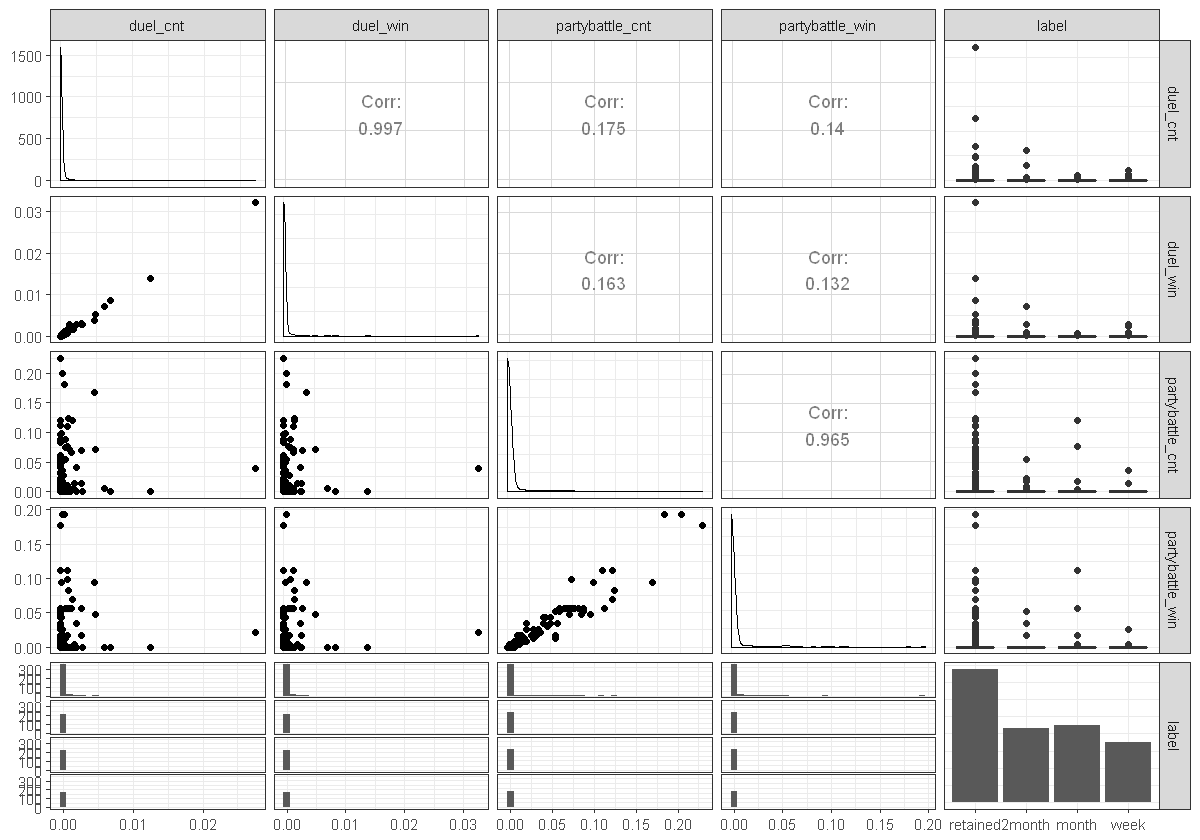

In [37]:
ggpairs(battle_temp %>% sample_n(1000), 
        columns = c("duel_cnt", "duel_win", "partybattle_cnt", "partybattle_win", "label"))

In [38]:
battle <- battle_temp %>% group_by(acc_id) %>%
  summarize(duel_cnt_sum = sum(duel_cnt),
            duel_cnt_wk_mean = mean(duel_cnt),
            duel_win_sum = sum(duel_win),
            duel_win_wk_mean = mean(duel_win),
            partybattle_cnt_sum = sum(partybattle_cnt),
            partybattle_cnt_wk_mean = mean(partybattle_cnt),
            partybattle_win_sum = sum(partybattle_win),
            partybattle_win_wk_mean = mean(partybattle_win)) %>%
  left_join(label, by = "acc_id")
head(battle)

acc_id,duel_cnt_sum,duel_cnt_wk_mean,duel_win_sum,duel_win_wk_mean,partybattle_cnt_sum,partybattle_cnt_wk_mean,partybattle_win_sum,partybattle_win_wk_mean,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0,0,0,0,0,0,0,0,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0,0,0,0,0,0,0,0,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0,0,0,0,0,0,0,0,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0,0,0,0,0,0,0,0,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0,0,0,0,0,0,0,0,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0,0,0,0,0,0,0,0,month


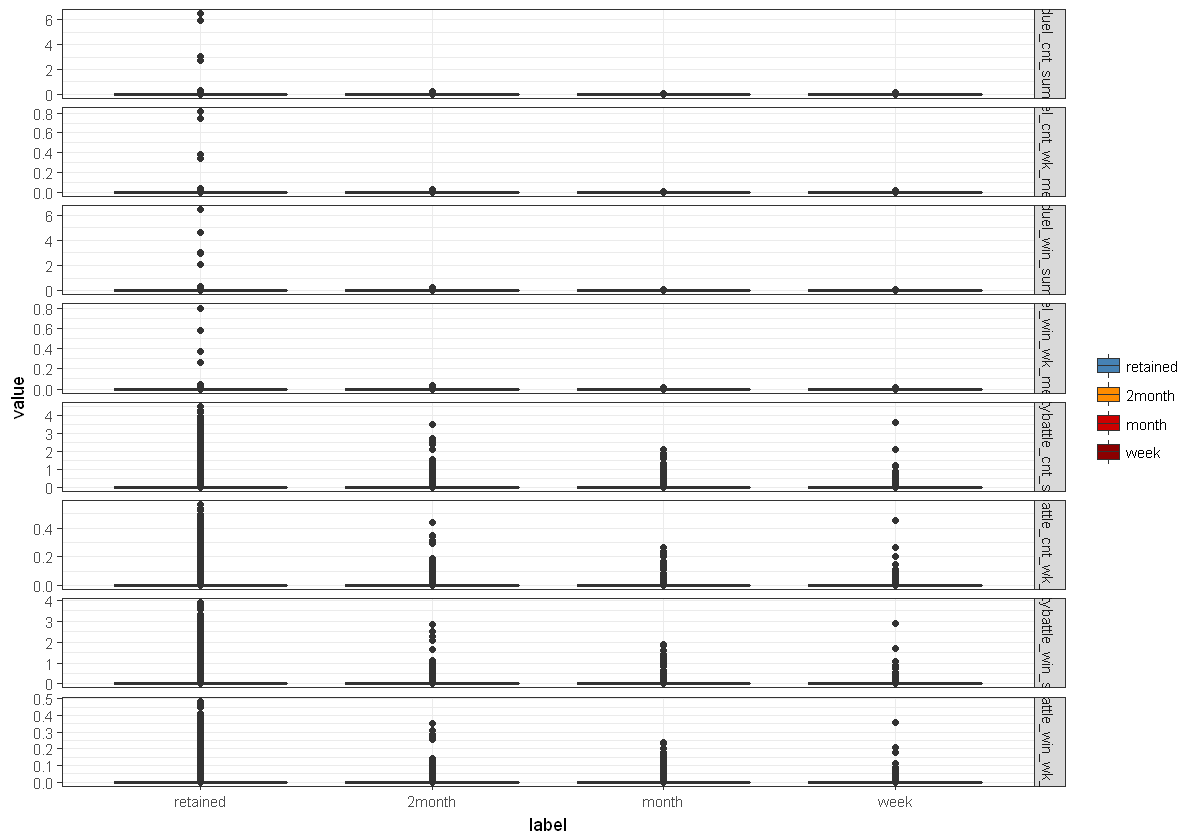

In [39]:
battle %>% gather(key = "type", value = "value", -acc_id, -label) %>% 
  ggplot(aes(label, value, fill = label)) + geom_boxplot() + 
  #ylim(c(0, 1)) +
  scale_fill_manual(name = "", values = c("steelblue", "darkorange", "red3", "darkred")) + 
  facet_grid(type ~ ., scales = "free")

## 2.5 Dungeon variables
* cnt_enter_inzone_solo
* cnt_enter_inzone_light
* cnt_enter_inzone_noraml
* cnt_enter_inzone_skilled
* cnt_enter_raid
* cnt_enter_raid_light
* cnt_enter_bam
* cnt_clear_inzone_solo
* cnt_clear_inzone_light
* cnt_clear_inzone_skilled
* cnt_clear_inzone_noraml
* cnt_clear_raid
* cnt_clear_raid_light
* cnt_clear_bam

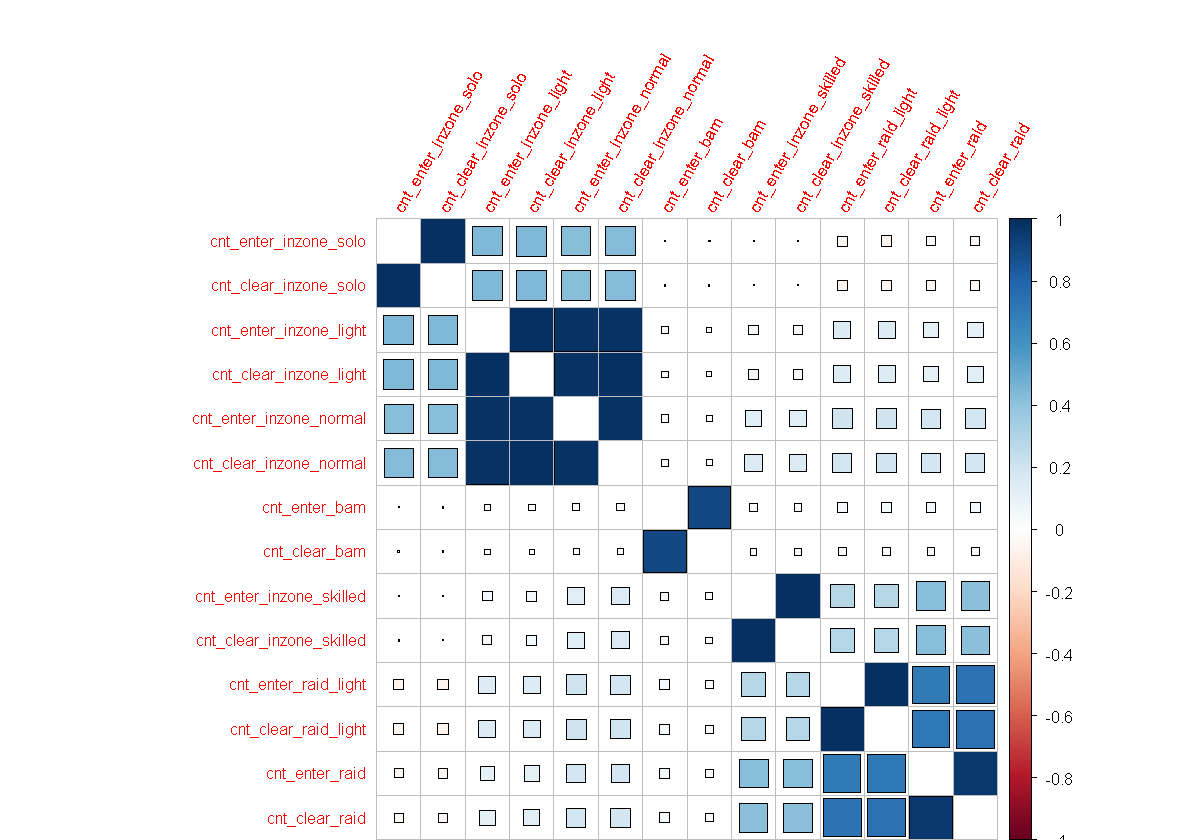

In [40]:
cor.df.temp2 <- cor(activity[,c(16:29)])
corrplot(cor.df.temp2, method = "square", order = "hclust", tl.cex = 0.8,
         tl.srt = 60, diag = F, outline = T)

In [41]:
dungeon_scaled <- apply(activity[,c(16:29)], 2, function(x) { (x - min(x))/(max(x) - min(x)) }) %>% 
  as.data.frame() %>% cbind(activity[,c(1,2,3)]) %>% select(acc_id, wk, cnt_dt, everything())
head(dungeon_scaled)

acc_id,wk,cnt_dt,cnt_enter_inzone_solo,cnt_enter_inzone_light,cnt_enter_inzone_skilled,cnt_enter_inzone_normal,cnt_enter_raid,cnt_enter_raid_light,cnt_enter_bam,cnt_clear_inzone_solo,cnt_clear_inzone_light,cnt_clear_inzone_skilled,cnt_clear_inzone_normal,cnt_clear_raid,cnt_clear_raid_light,cnt_clear_bam
3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,7,4,0,0,0,0.009677419,0,0,0,0,0,0,0.01169591,0,0,0
3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,8,5,0,0,0,0.014516129,0,0,0,0,0,0,0.01754386,0,0,0
b8856358ff62e596fa07e3e40b8e7fd4b7729263c72b442803c4f22e41d6198b,3,2,0,0,0,0.000000000,0,0,0,0,0,0,0.00000000,0,0,0
b8856358ff62e596fa07e3e40b8e7fd4b7729263c72b442803c4f22e41d6198b,4,2,0,0,0,0.000000000,0,0,0,0,0,0,0.00000000,0,0,0
b8856358ff62e596fa07e3e40b8e7fd4b7729263c72b442803c4f22e41d6198b,5,4,0,0,0,0.000000000,0,0,0,0,0,0,0.00000000,0,0,0
b8856358ff62e596fa07e3e40b8e7fd4b7729263c72b442803c4f22e41d6198b,7,2,0,0,0,0.000000000,0,0,0,0,0,0,0.00000000,0,0,0


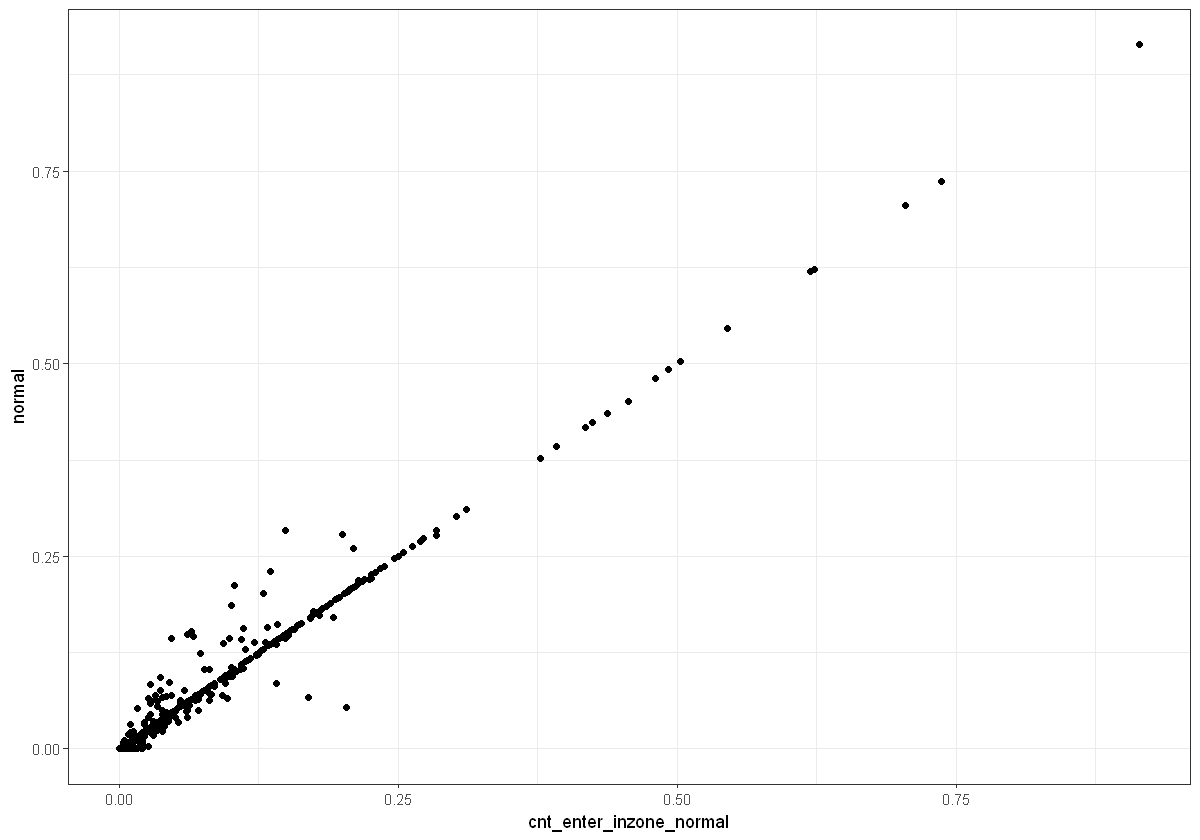

In [42]:
dungeon_scaled %>%
  mutate(normal = cnt_enter_inzone_light + cnt_enter_inzone_skilled) %>% sample_n(1000) %>%
  ggplot() + geom_point(aes(cnt_enter_inzone_normal, normal))

In [43]:
dungeon <- dungeon_scaled %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            enter_inzone_solo_sum = sum(cnt_enter_inzone_solo),
            enter_inzone_solo_wk_mean = mean(cnt_enter_inzone_solo),
            enter_inzone_normal_sum = sum(cnt_enter_inzone_normal),
            enter_inzone_normal_wk_mean = mean(cnt_enter_inzone_normal),
            enter_inzone_light_sum = sum(cnt_enter_inzone_light),
            enter_inzone_light_wk_mean = mean(cnt_enter_inzone_light),
            enter_inzone_skilled_sum = sum(cnt_enter_inzone_skilled),
            enter_inzone_skilled_wk_mean = mean(cnt_enter_inzone_skilled),
            enter_raid_sum = sum(cnt_enter_raid),
            enter_raid_wk_mean = mean(cnt_enter_raid),
            enter_raid_light_sum = sum(cnt_enter_raid_light),
            enter_raid_light_wk_mean = mean(cnt_enter_raid_light),
            enter_bam_sum = sum(cnt_enter_bam),
            enter_bam_wk_mean = mean(cnt_enter_bam),
            clear_inzone_solo_sum = sum(cnt_clear_inzone_solo),
            clear_inzone_solo_wk_mean = mean(cnt_clear_inzone_solo),
            clear_inzone_normal_sum = sum(cnt_clear_inzone_normal),
            clear_inzone_normal_wk_mean = mean(cnt_clear_inzone_normal),
            clear_inzone_light_sum = sum(cnt_clear_inzone_light),
            clear_inzone_light_wk_mean = mean(cnt_clear_inzone_light),
            clear_inzone_skilled_sum = sum(cnt_clear_inzone_skilled),
            clear_inzone_skilled_wk_mean = mean(cnt_clear_inzone_skilled),
            clear_raid_sum = sum(cnt_clear_raid),
            clear_raid_wk_mean = mean(cnt_clear_raid),
            clear_raid_light_sum = sum(cnt_clear_raid_light),
            clear_raid_light_wk_mean = mean(cnt_clear_raid_light),
            clear_bam_sum = sum(cnt_clear_bam),
            clear_bam_wk_mean = mean(cnt_clear_bam)) %>%
  left_join(label, by = "acc_id")
  
head(dungeon)

acc_id,acc_num,enter_inzone_solo_sum,enter_inzone_solo_wk_mean,enter_inzone_normal_sum,enter_inzone_normal_wk_mean,enter_inzone_light_sum,enter_inzone_light_wk_mean,enter_inzone_skilled_sum,enter_inzone_skilled_wk_mean,...,clear_inzone_light_wk_mean,clear_inzone_skilled_sum,clear_inzone_skilled_wk_mean,clear_raid_sum,clear_raid_wk_mean,clear_raid_light_sum,clear_raid_light_wk_mean,clear_bam_sum,clear_bam_wk_mean,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,12,0.0000000,0.00000000,0.032258065,0.016129032,0.000000000,0.000000000,0,0,...,0.000000000,0,0,0,0,0,0,0,0,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,25,0.0000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0,0,...,0.000000000,0,0,0,0,0,0,0,0,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,12,0.0000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0,0,...,0.000000000,0,0,0,0,0,0,0,0,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,31,0.1723202,0.02872004,0.006451613,0.001075269,0.006451613,0.001075269,0,0,...,0.001312336,0,0,0,0,0,0,0,0,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,3,0.0000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0,0,...,0.000000000,0,0,0,0,0,0,0,0,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,39,0.2398236,0.02997795,0.050000000,0.006250000,0.050000000,0.006250000,0,0,...,0.006889764,0,0,0,0,0,0,0,0,month


In [44]:
dungeon_temp <- dungeon %>% select(-acc_num) %>% 
  gather(key = "dungeon", value = "value", -acc_id, -label)
head(dungeon_temp)

acc_id,label,dungeon,value
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,week,enter_inzone_solo_sum,0.0000000
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,retained,enter_inzone_solo_sum,0.0000000
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,retained,enter_inzone_solo_sum,0.0000000
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,month,enter_inzone_solo_sum,0.1723202
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2month,enter_inzone_solo_sum,0.0000000
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,month,enter_inzone_solo_sum,0.2398236


Warning message:
"Removed 9538 rows containing non-finite values (stat_boxplot)."

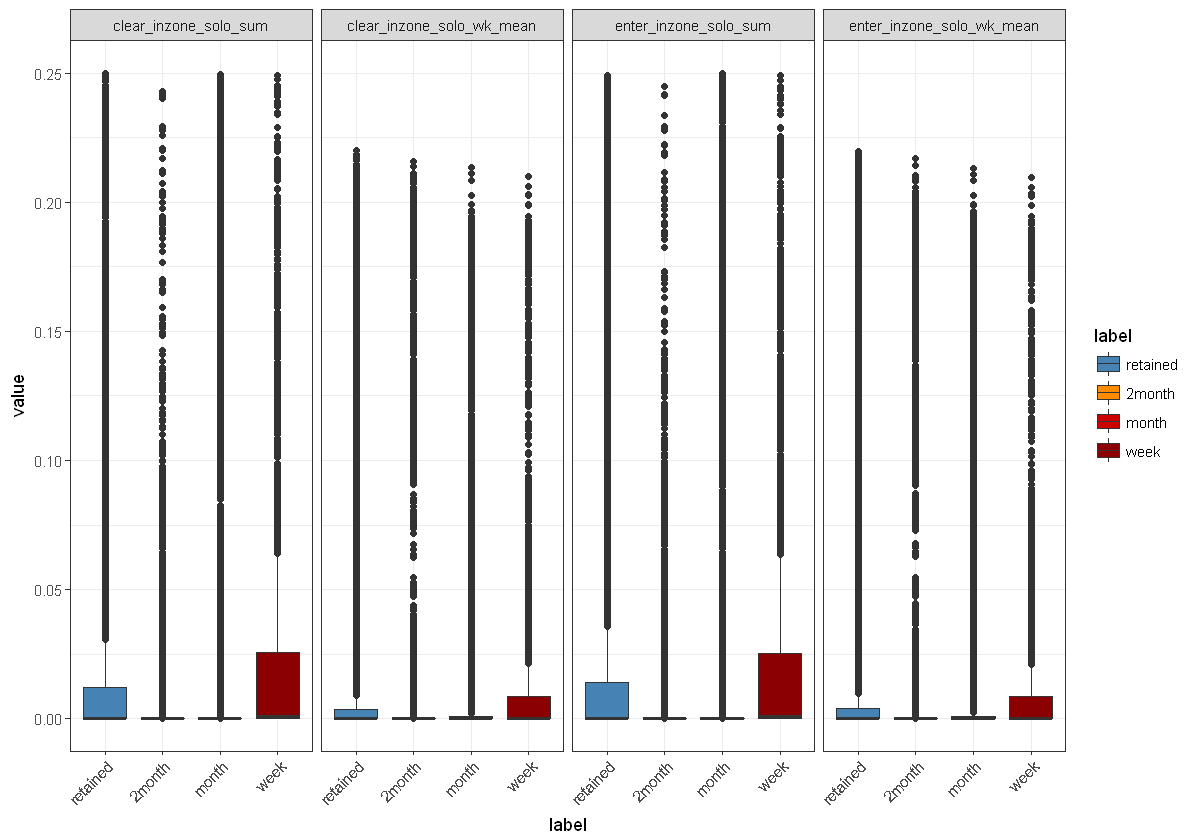

In [45]:
dungeon_temp %>% filter(str_detect(dungeon, "solo")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 0.25)) +
  facet_grid(. ~ dungeon)

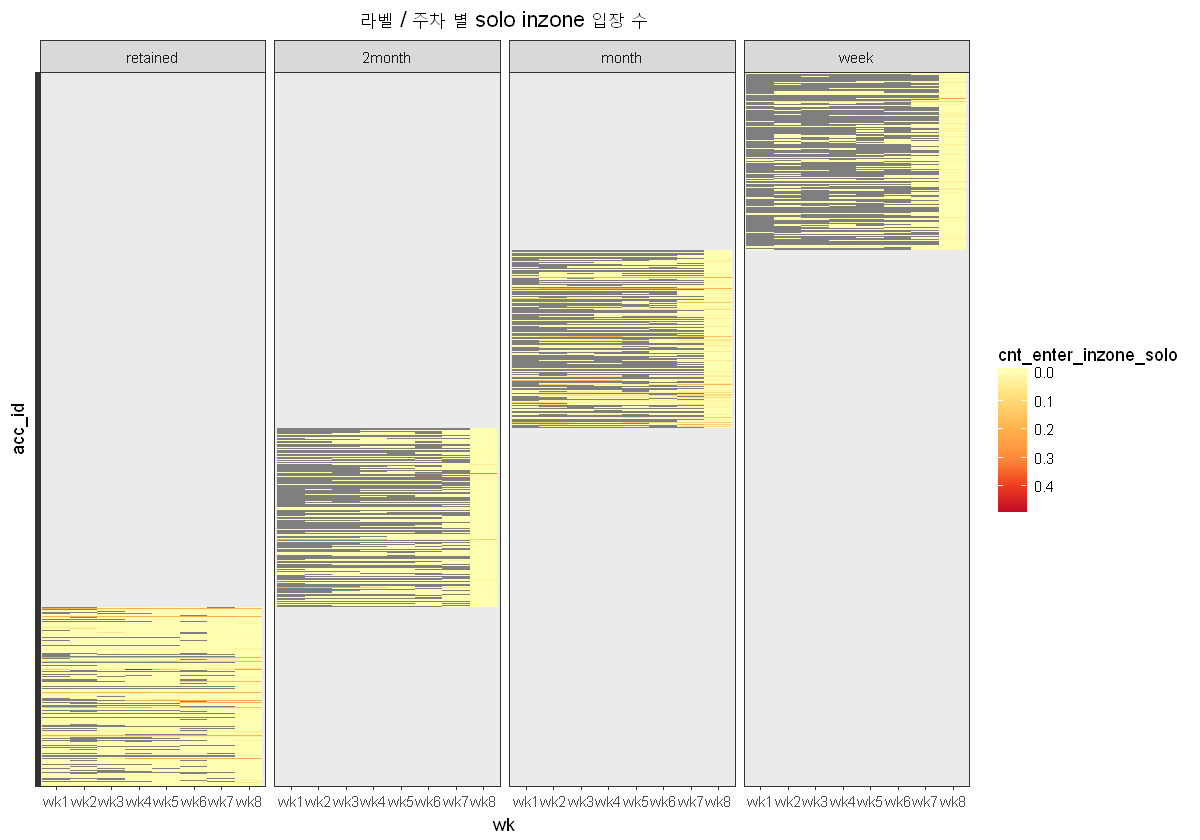

In [46]:
set.seed(9735)
label_week_heatmap(dungeon_scaled, "cnt_enter_inzone_solo", is_normalized = T, sample_num = 2500) + 
labs(title = "라벨 / 주차 별 solo inzone 입장 수")

Warning message:
"Removed 42790 rows containing non-finite values (stat_boxplot)."

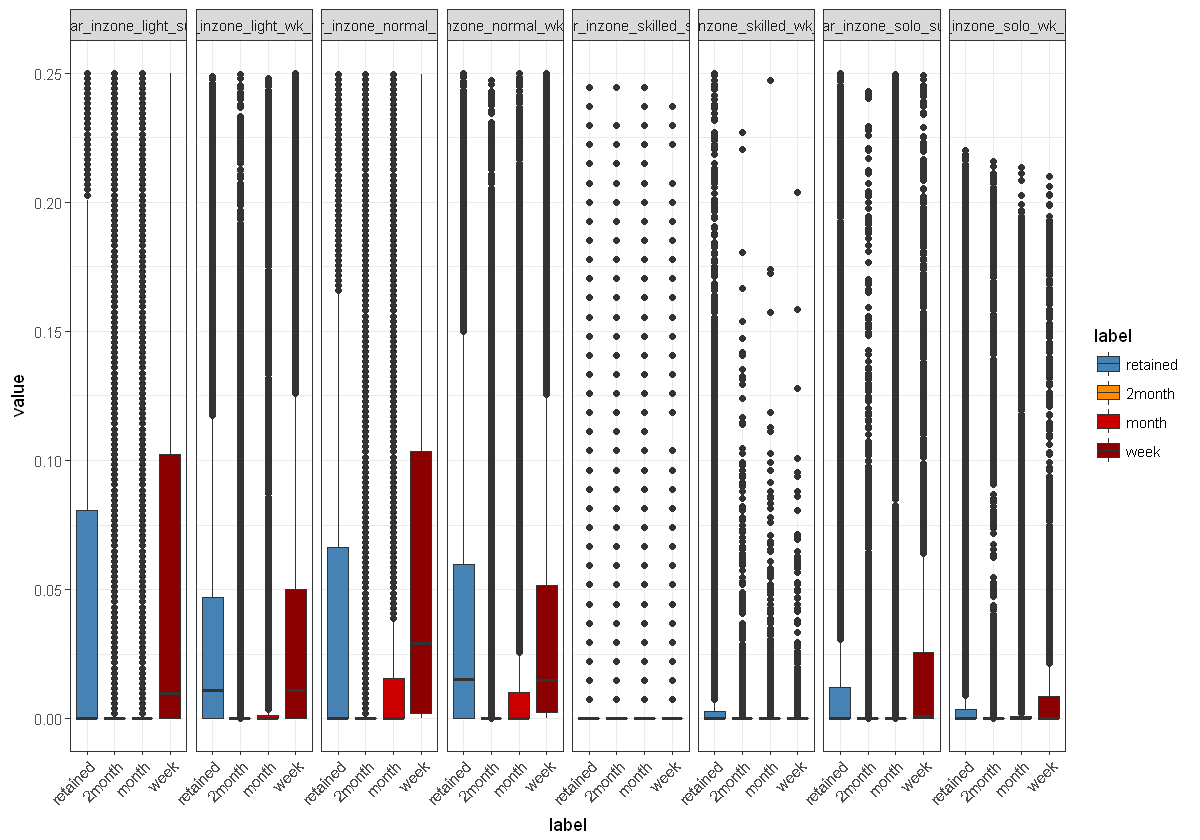

In [47]:
dungeon_temp %>% filter(str_detect(dungeon, "clear_inzone")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 0.25)) +
  facet_grid(. ~ dungeon)

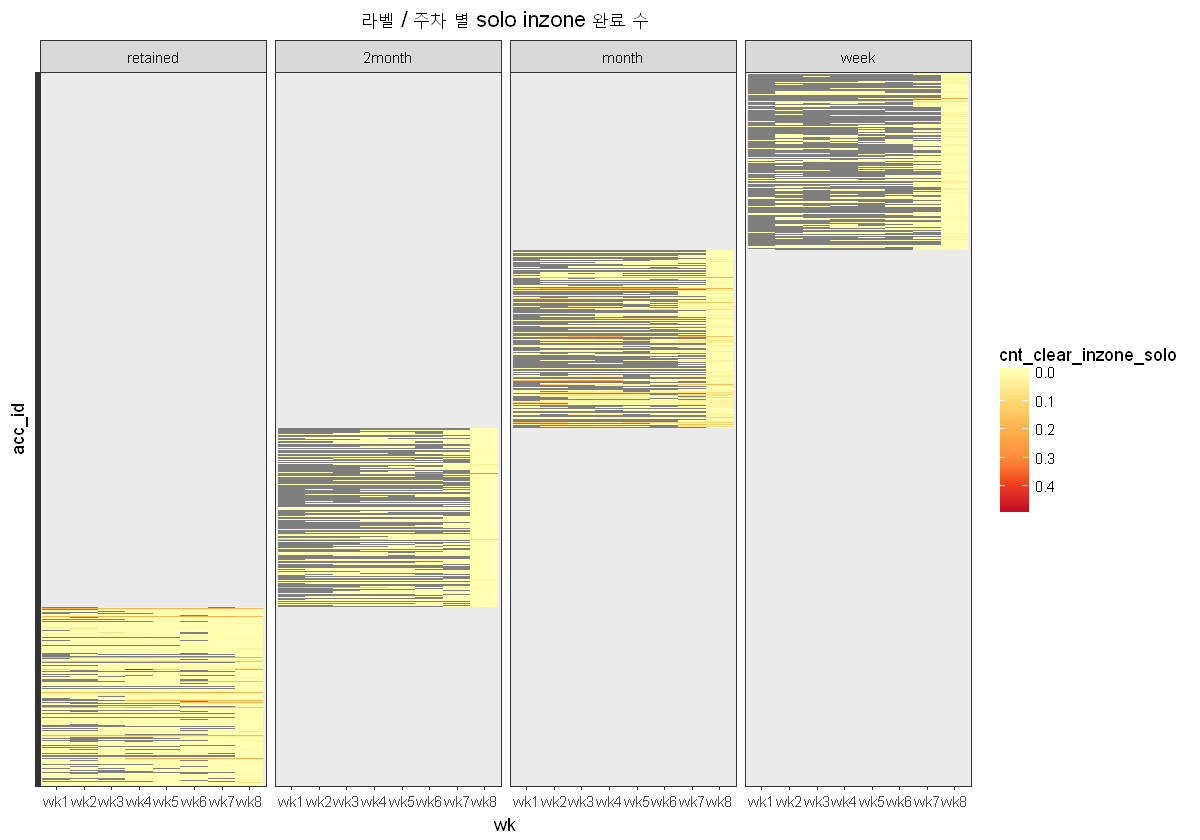

In [48]:
set.seed(9735)
label_week_heatmap(dungeon_scaled, "cnt_clear_inzone_solo", is_normalized = T, sample_num = 2500) + 
labs(title = "라벨 / 주차 별 solo inzone 완료 수")

Warning message:
"Removed 40500 rows containing non-finite values (stat_boxplot)."

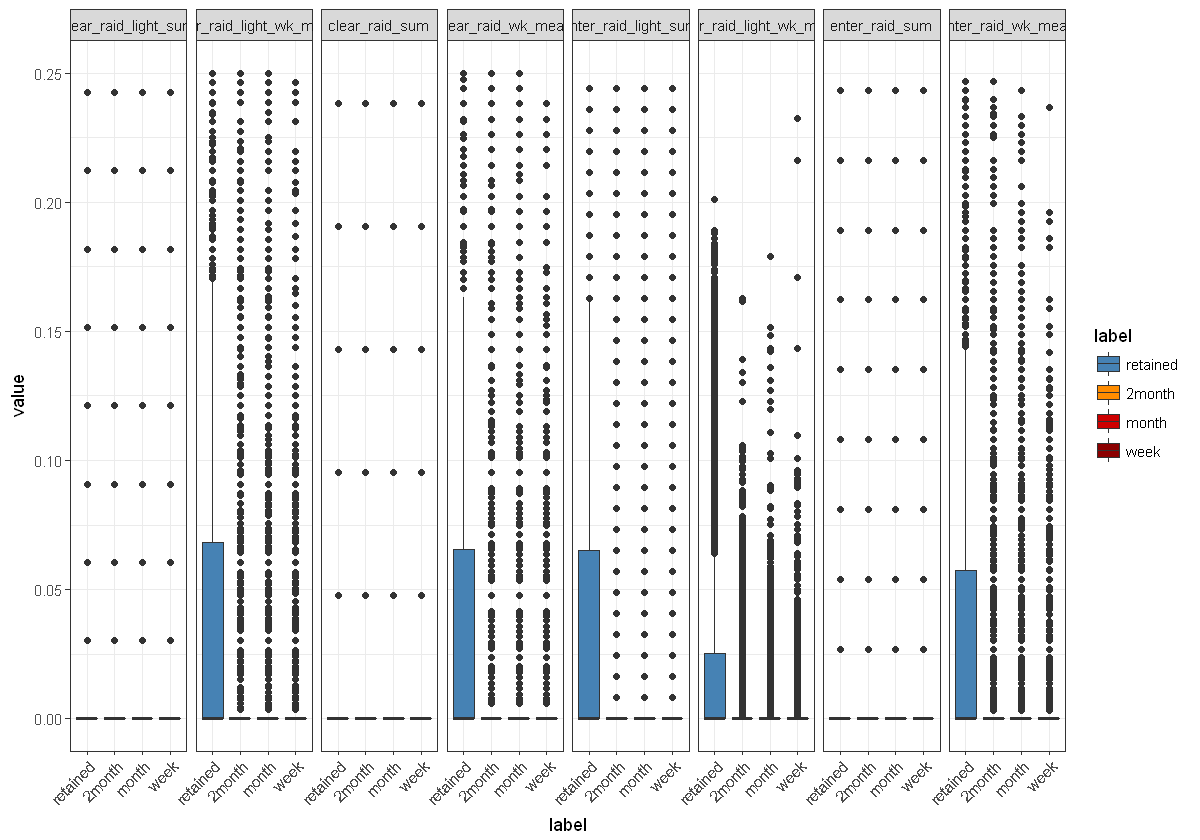

In [49]:
dungeon_temp %>% filter(str_detect(dungeon, "raid")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 0.25)) +
  facet_grid(. ~ dungeon)

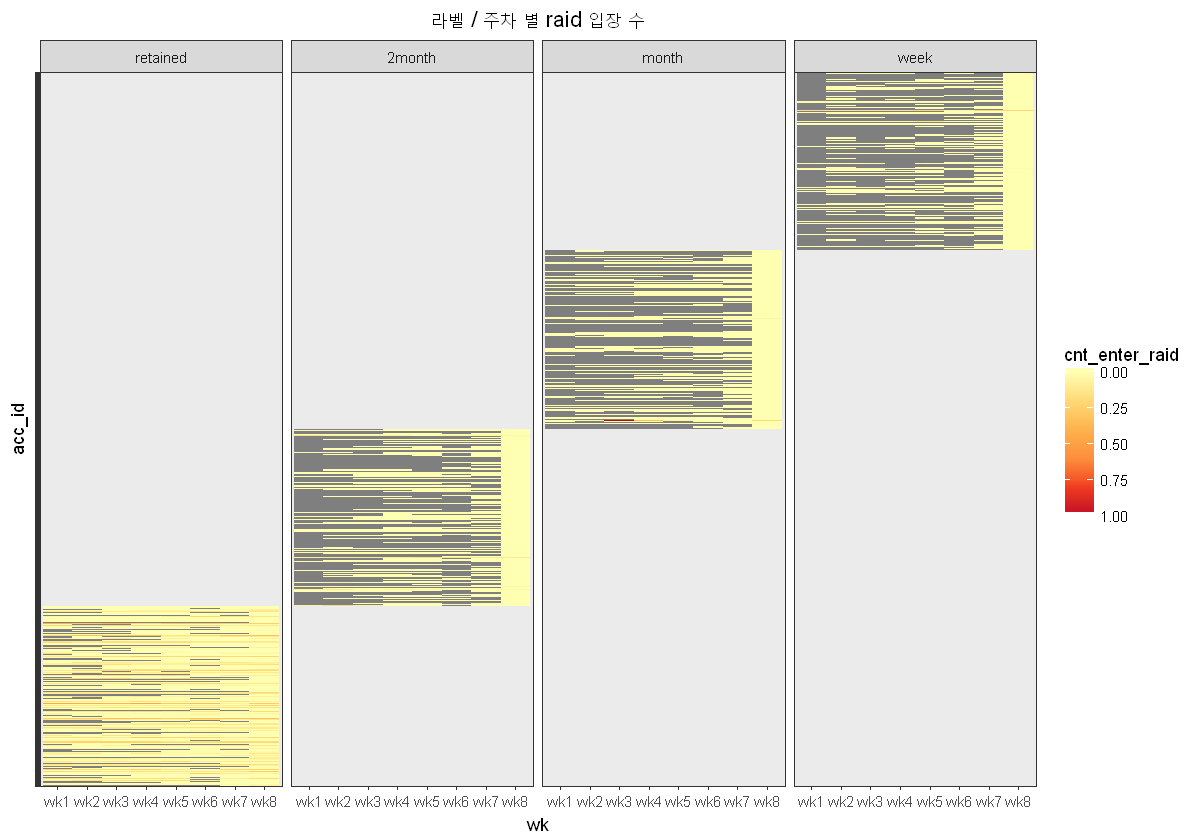

In [50]:
set.seed(7521)
label_week_heatmap(dungeon_scaled, "cnt_enter_raid", is_normalized = T, sample_num = 2500) + 
labs(title = "라벨 / 주차 별 raid 입장 수")

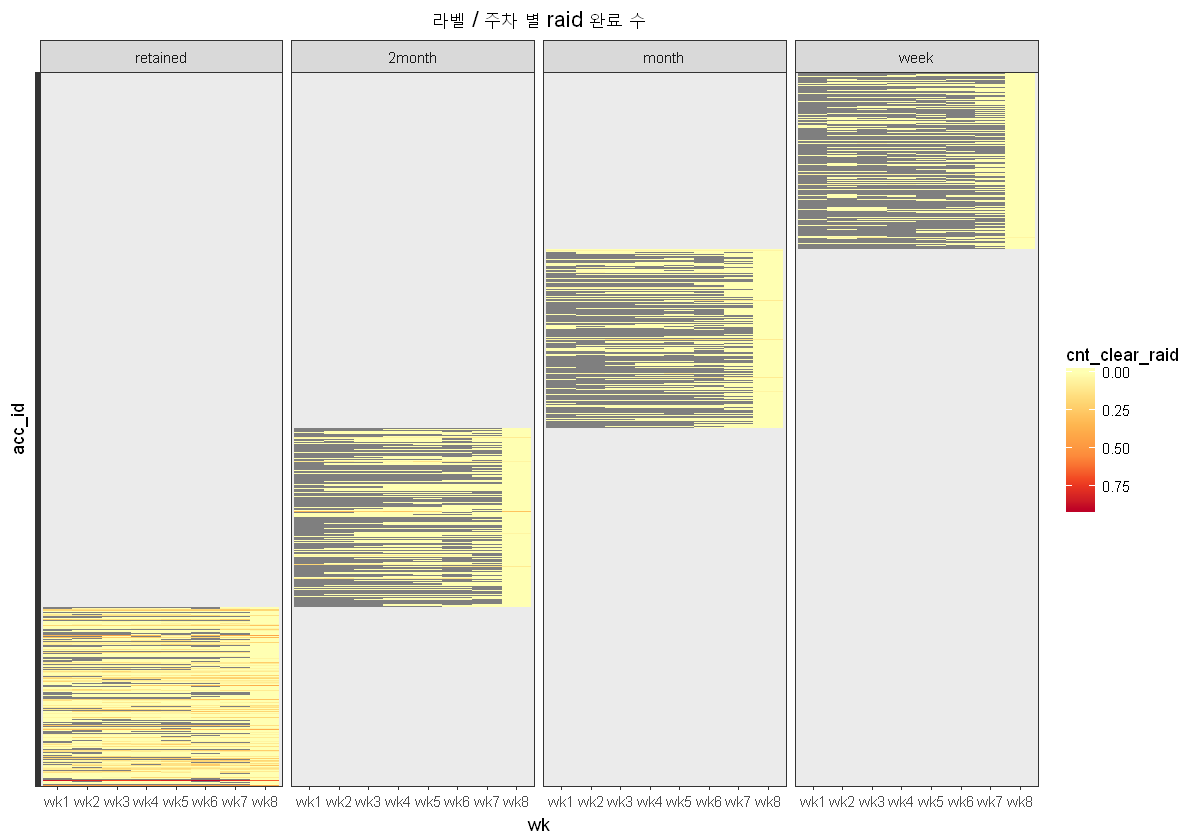

In [51]:
set.seed(5863)
label_week_heatmap(dungeon_scaled, "cnt_clear_raid", is_normalized = T, sample_num = 2500) + 
labs(title = "라벨 / 주차 별 raid 완료 수")

# Merge Dungeon
* inzone - solo / light
* inzone_skilled
* raid - light / raid
* bam

In [52]:
dungeon_merged <- dungeon_scaled %>%
  mutate(enter_inzone = cnt_enter_inzone_solo + cnt_enter_inzone_normal,
         enter_skilled = cnt_enter_inzone_skilled,
         enter_raid = cnt_enter_raid + cnt_enter_raid_light,
         enter_bam = cnt_enter_bam,
         clear_inzone = cnt_clear_inzone_solo + cnt_clear_inzone_normal,
         clear_skilled = cnt_clear_inzone_skilled,
         clear_raid = cnt_clear_raid + cnt_clear_raid_light,
         clear_bam = cnt_clear_bam) %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            enter_inzone_sum = sum(enter_inzone),
            enter_inzone_wk_mean = mean(enter_inzone),
            enter_skilled_sum = sum(enter_skilled),
            enter_skilled_wk_mean = mean(enter_skilled),
            enter_raid_sum = sum(enter_raid),
            enter_raid_wk_mean = mean(enter_raid),
            enter_bam_sum = sum(enter_bam),
            enter_bam_wk_mean = mean(enter_bam),
            clear_inzone_sum = sum(clear_inzone),
            clear_inzone_wk_mean = mean(clear_inzone),
            clear_skilled_sum = sum(clear_skilled),
            clear_skilled_wk_mean = mean(clear_skilled),
            clear_raid_sum = sum(clear_raid),
            clear_raid_wk_mean = mean(clear_raid),
            clear_bam_sum = sum(clear_bam),
            clear_bam_wk_mean = mean(clear_bam)) %>%
  mutate(enter_inzone_acc_mean = enter_inzone_sum / acc_num,
         enter_skilled_acc_mean = enter_skilled_sum / acc_num,
         enter_raid_acc_mean = enter_raid_sum / acc_num,
         enter_bam_acc_mean = enter_bam_sum / acc_num,
         clear_inzone_acc_mean = clear_inzone_sum / acc_num,
         clear_skilled_acc_mean = clear_skilled_sum / acc_num,
         clear_raid_acc_mean = clear_raid_sum / acc_num,
         clear_bam_acc_mean = clear_bam_sum / acc_num) %>%
  select(-acc_num) %>%
  left_join(label, by = "acc_id")
head(dungeon_merged)

acc_id,enter_inzone_sum,enter_inzone_wk_mean,enter_skilled_sum,enter_skilled_wk_mean,enter_raid_sum,enter_raid_wk_mean,enter_bam_sum,enter_bam_wk_mean,clear_inzone_sum,...,clear_bam_wk_mean,enter_inzone_acc_mean,enter_skilled_acc_mean,enter_raid_acc_mean,enter_bam_acc_mean,clear_inzone_acc_mean,clear_skilled_acc_mean,clear_raid_acc_mean,clear_bam_acc_mean,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.03225806,0.01612903,0,0,0,0,0,0,0.03898635,...,0,0.002688172,0,0,0,0.003248863,0,0,0,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.00000000,0.00000000,0,0,0,0,0,0,0.00000000,...,0,0.000000000,0,0,0,0.000000000,0,0,0,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.00000000,0.00000000,0,0,0,0,0,0,0.00000000,...,0,0.000000000,0,0,0,0.000000000,0,0,0,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.17877183,0.02979530,0,0,0,0,0,0,0.17894392,...,0,0.005766833,0,0,0,0.005772384,0,0,0,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.00000000,0.00000000,0,0,0,0,0,0,0.00000000,...,0,0.000000000,0,0,0,0.000000000,0,0,0,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.28982361,0.03622795,0,0,0,0,0,0,0.29173639,...,0,0.007431375,0,0,0,0.007480420,0,0,0,month


In [53]:
dungeon_temp2 <- dungeon_merged %>% 
  gather(key = "dungeon", value = "value", -acc_id, -label)

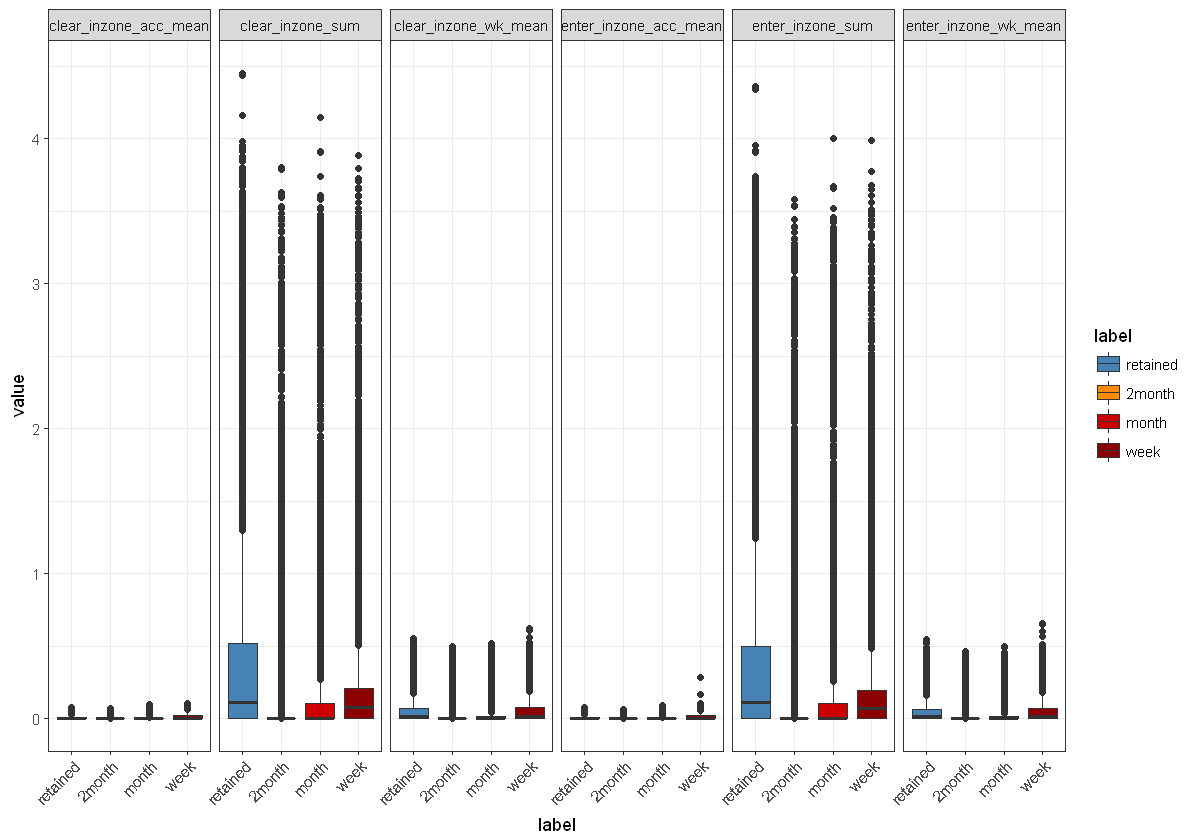

In [54]:
dungeon_temp2 %>% filter(str_detect(dungeon, "inzone")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  facet_grid(. ~ dungeon)

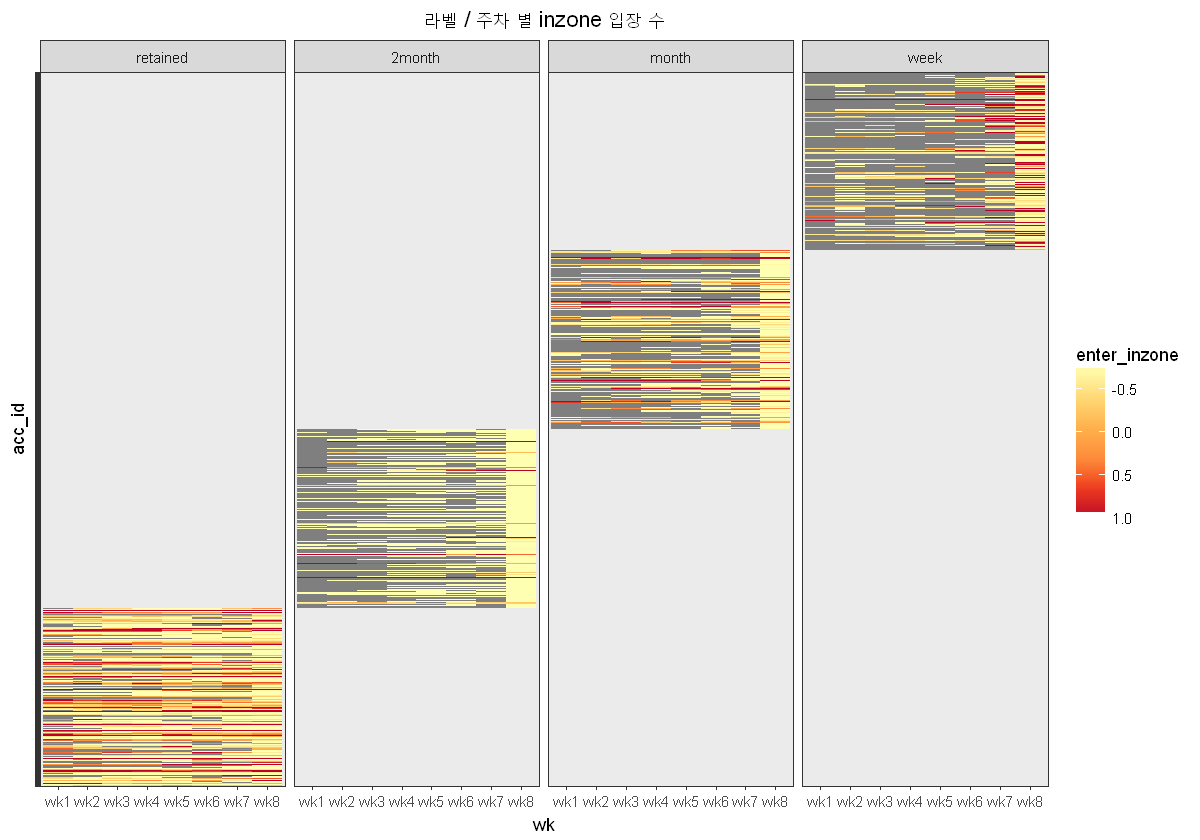

In [55]:
set.seed(2233)
activity %>% 
  mutate(enter_inzone = cnt_enter_inzone_solo + cnt_enter_inzone_normal) %>%
  label_week_heatmap("enter_inzone", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 inzone 입장 수")

Warning message:
"Removed 411915 rows containing non-finite values (stat_boxplot)."

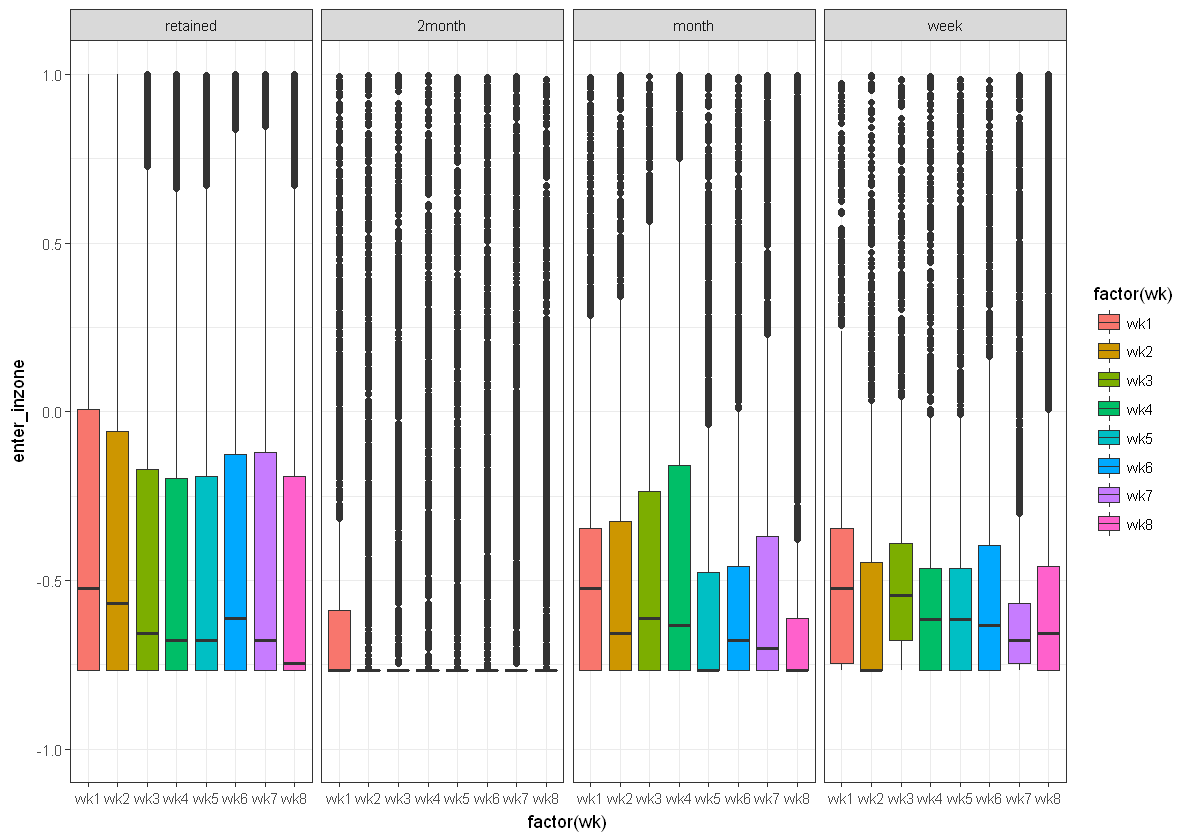

In [56]:
temp <- activity %>%
  mutate(enter_inzone = cnt_enter_inzone_solo + cnt_enter_inzone_normal) %>%
  select(acc_id, wk, enter_inzone) %>%
  spread(key = "wk", value = "enter_inzone")
names(temp)[2:9] <- paste0("wk", 1:8)

temp %>% gather(key = "wk", value = "enter_inzone", -acc_id) %>% 
  left_join(label, by = "acc_id") %>%
  ggplot(aes(factor(wk), enter_inzone, fill = factor(wk))) + 
  geom_boxplot() + ylim(c(-1, 1)) + facet_grid(. ~ label)

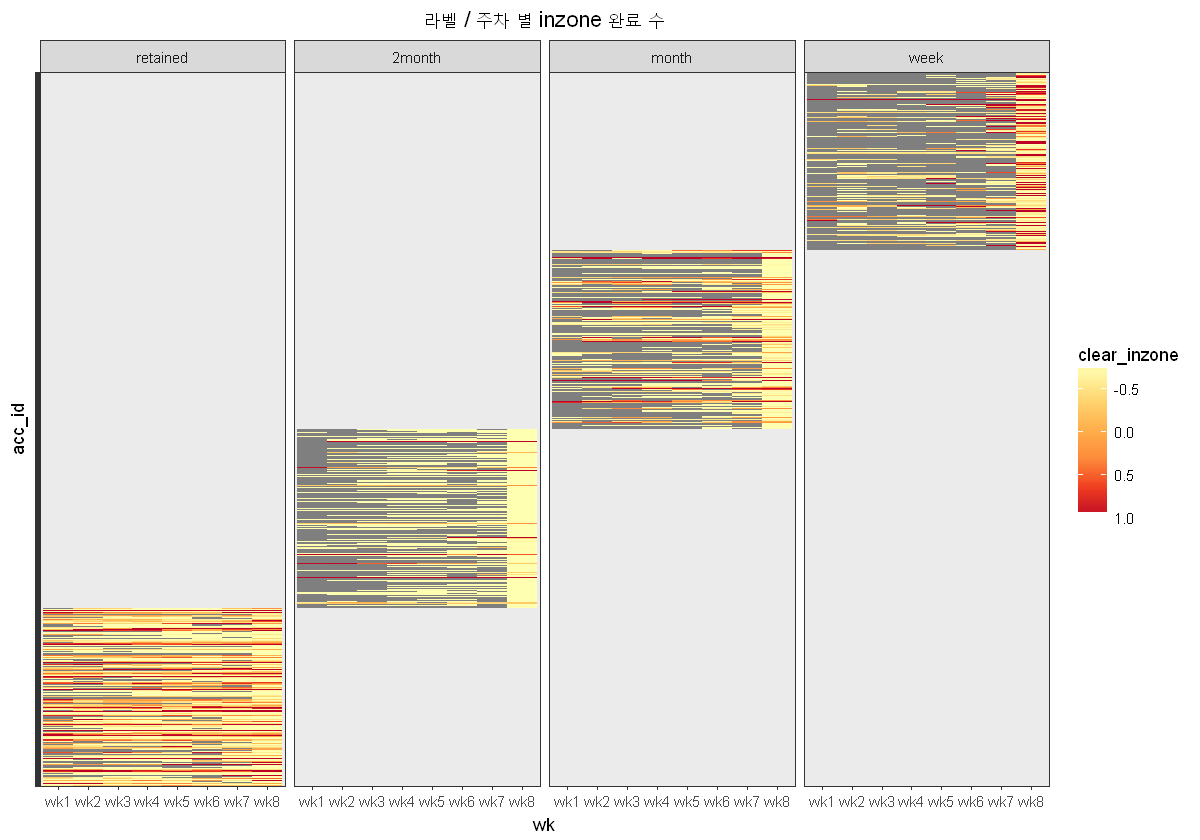

In [57]:
set.seed(2233)
activity %>% 
  mutate(clear_inzone = cnt_clear_inzone_solo + cnt_clear_inzone_normal) %>%
  label_week_heatmap("clear_inzone", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 inzone 완료 수")

Warning message:
"Removed 5119 rows containing non-finite values (stat_boxplot)."

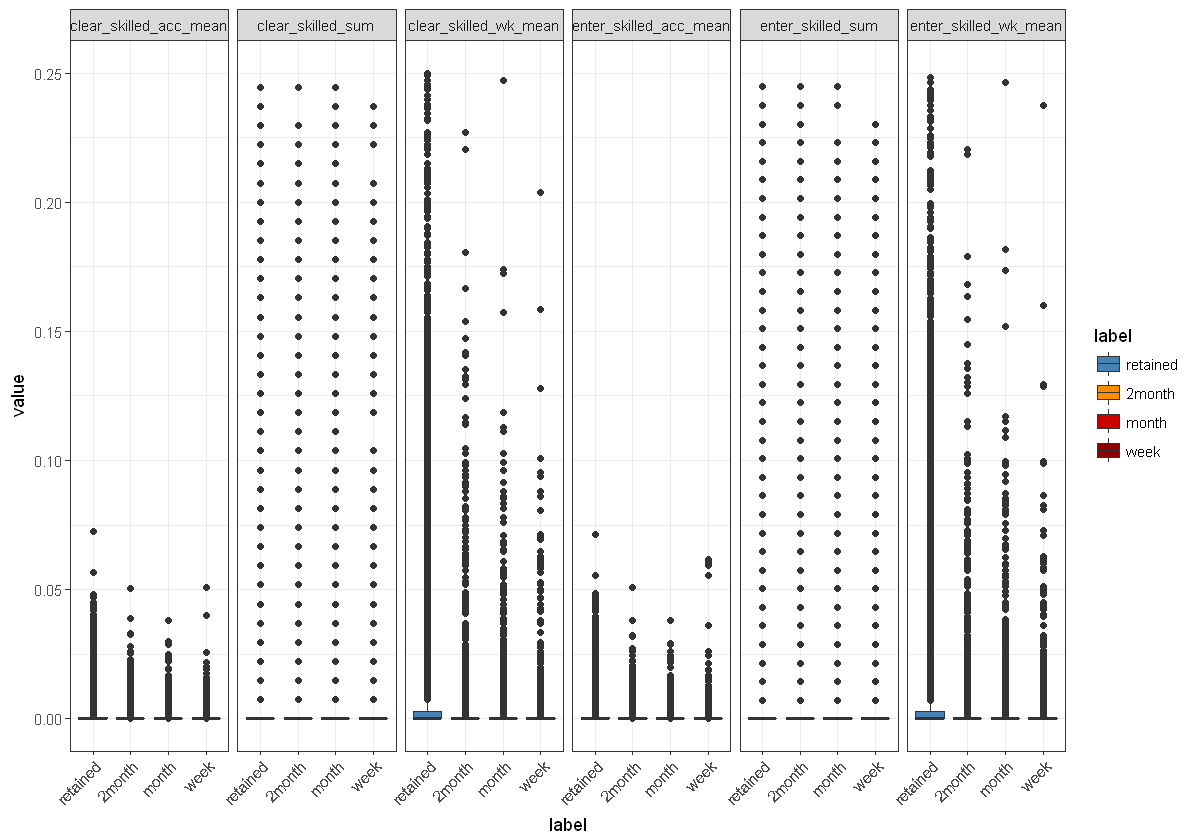

In [58]:
dungeon_temp2 %>% filter(str_detect(dungeon, "skilled")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 0.25)) +
  facet_grid(. ~ dungeon)

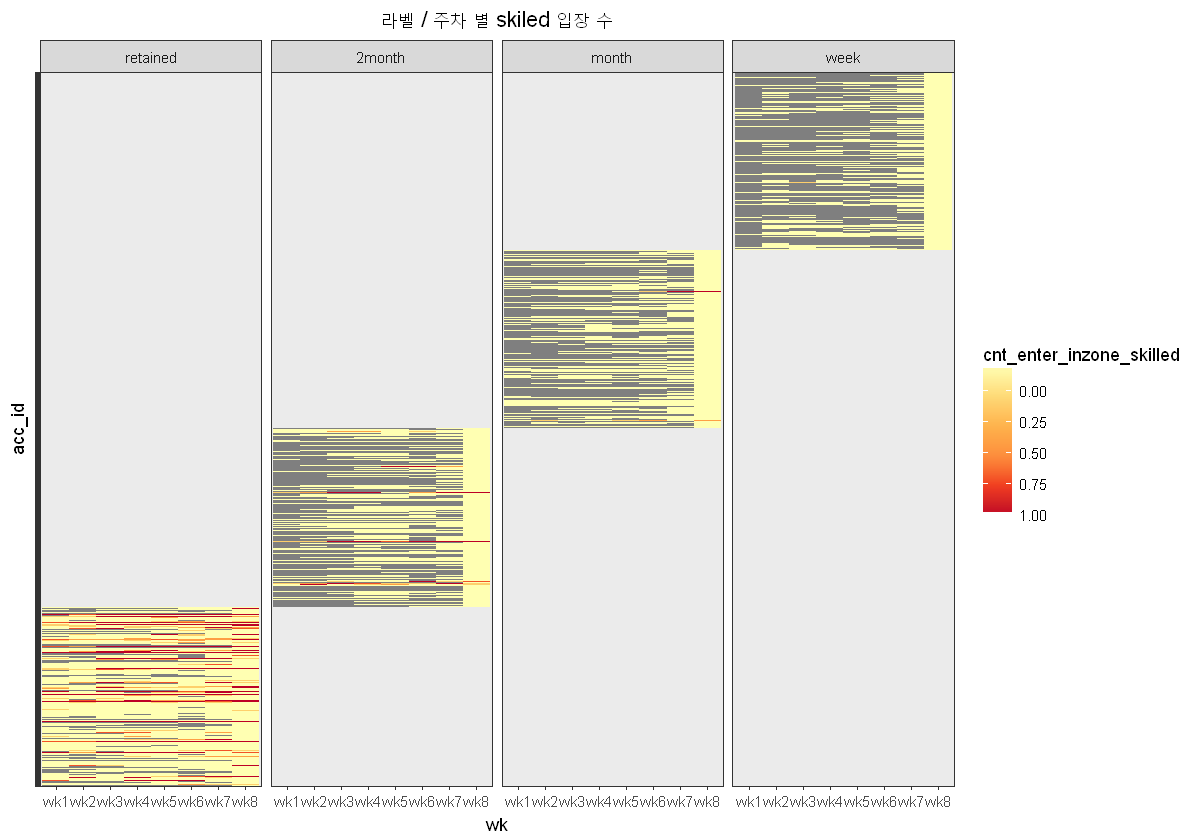

In [59]:
set.seed(7654)
activity %>% 
  label_week_heatmap("cnt_enter_inzone_skilled", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 skiled 입장 수")

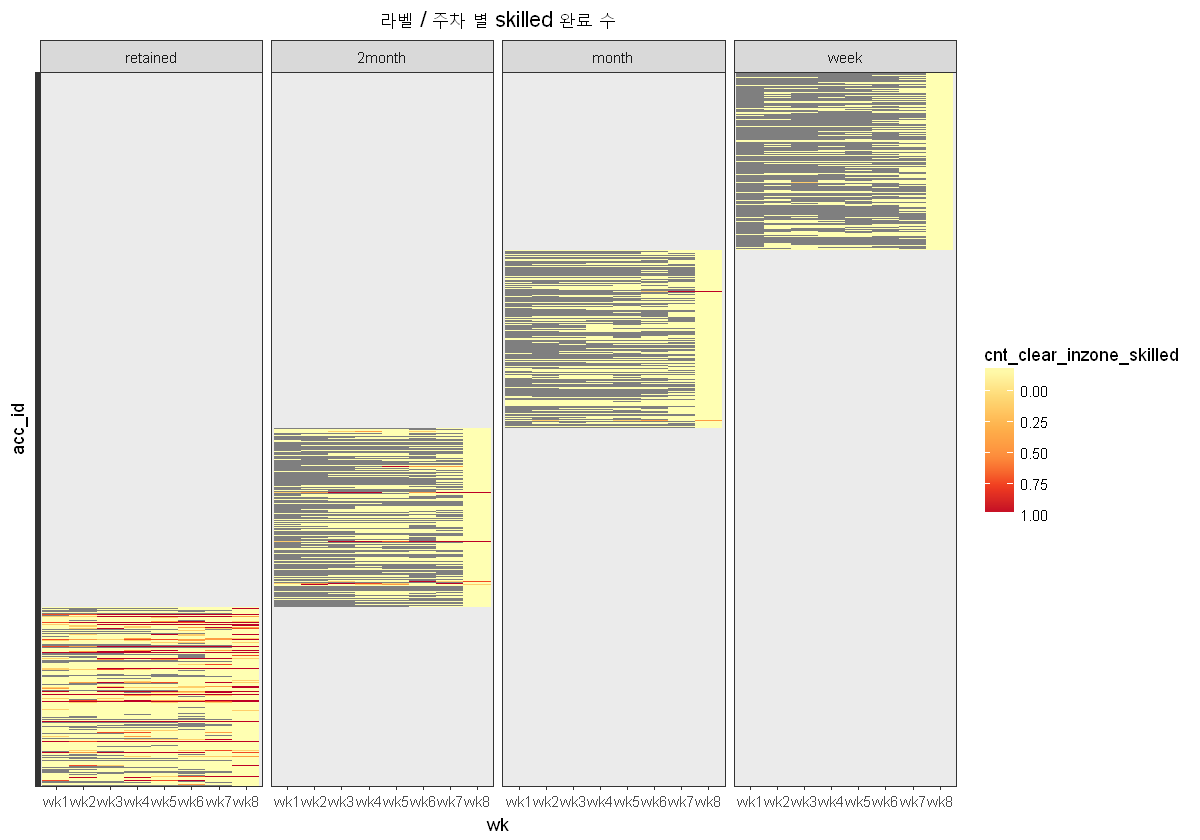

In [60]:
set.seed(7654)
activity %>% 
  label_week_heatmap("cnt_clear_inzone_skilled", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 skilled 완료 수")

Warning message:
"Removed 5954 rows containing non-finite values (stat_boxplot)."

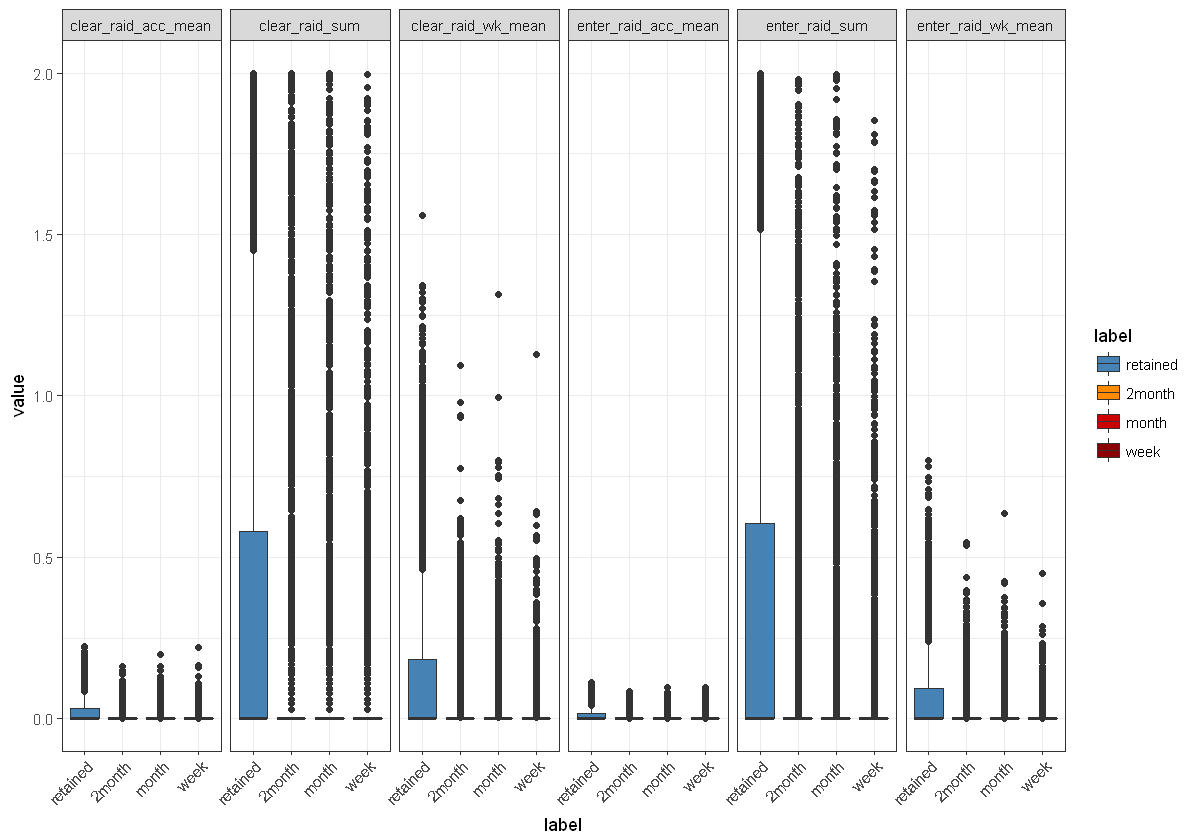

In [61]:
dungeon_temp2 %>% filter(str_detect(dungeon, "raid")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 2)) +
  facet_grid(. ~ dungeon)

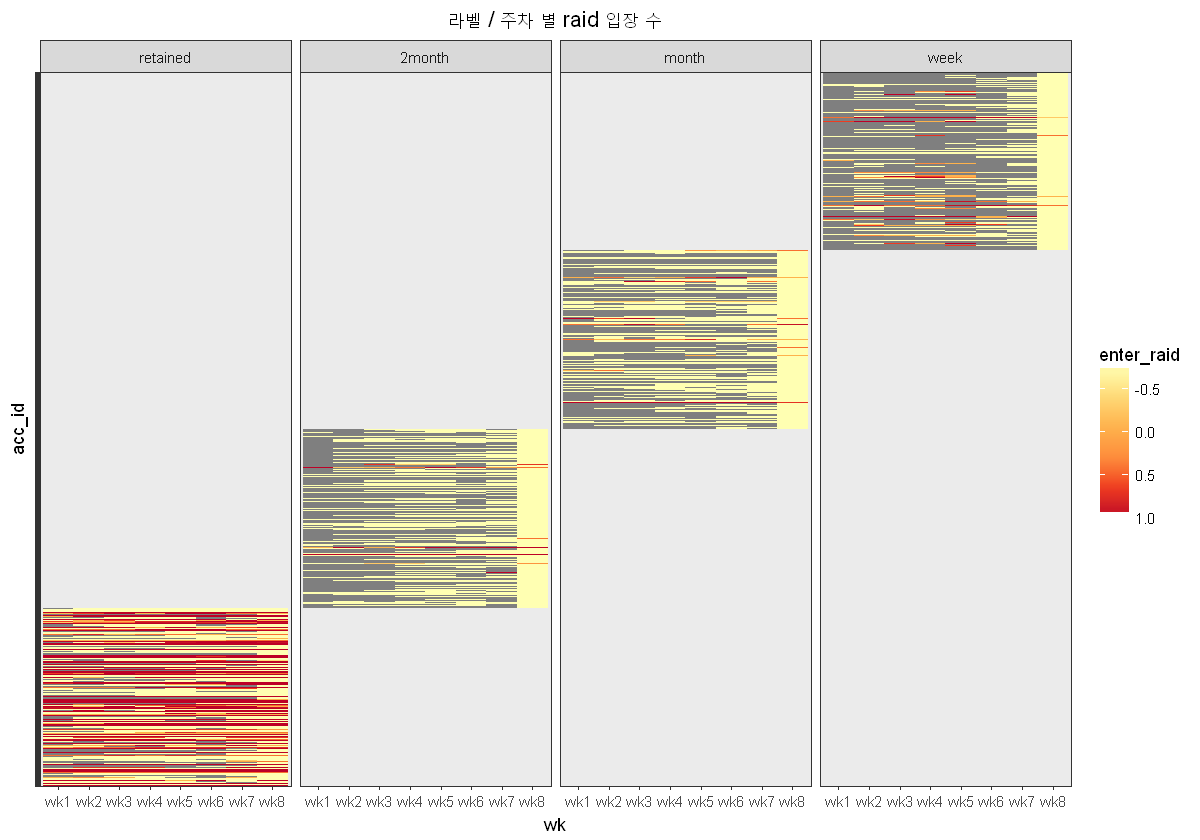

In [62]:
set.seed(2233)
activity %>% 
  mutate(enter_raid = cnt_enter_raid + cnt_enter_raid_light) %>%
  label_week_heatmap("enter_raid", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 raid 입장 수")

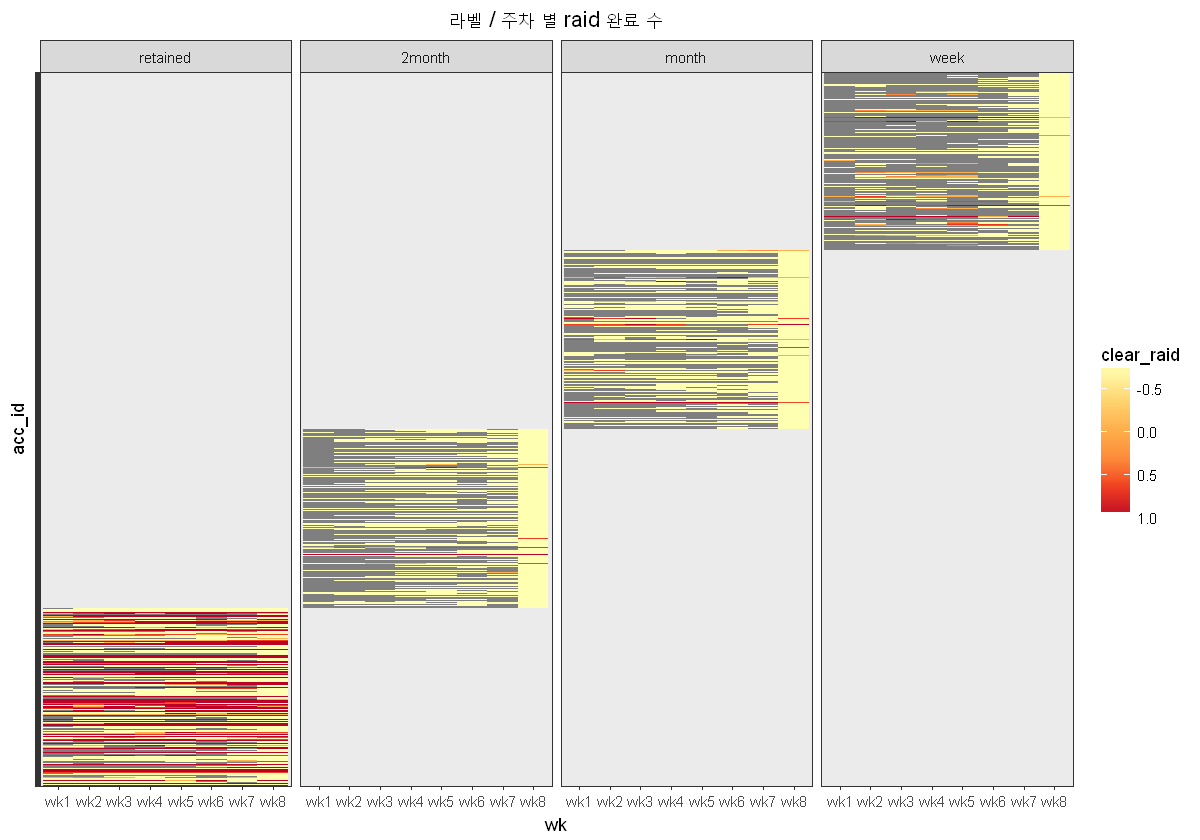

In [63]:
set.seed(2233)
activity %>% 
  mutate(clear_raid = cnt_clear_raid + cnt_clear_raid_light) %>%
  label_week_heatmap("clear_raid", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 raid 완료 수")

Warning message:
"Removed 52 rows containing non-finite values (stat_boxplot)."

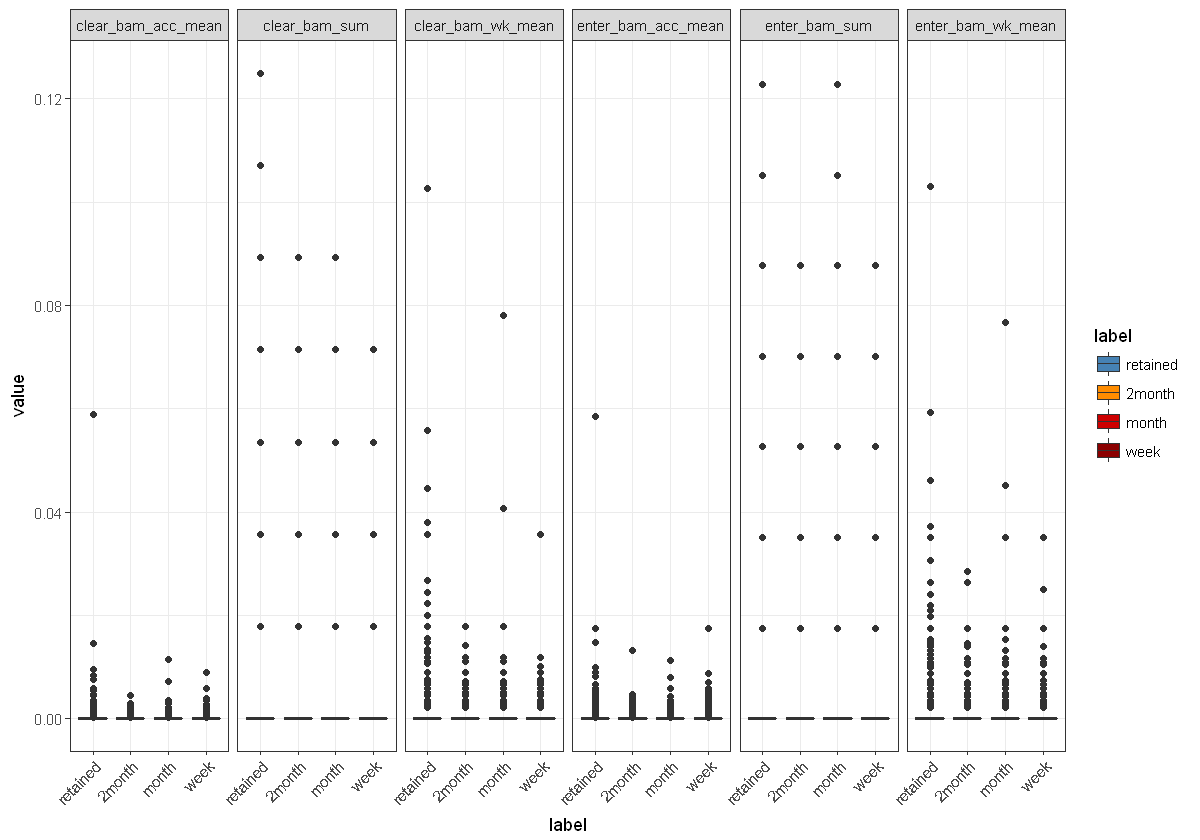

In [64]:
dungeon_temp2 %>% filter(str_detect(dungeon, "bam")) %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(0, 0.125)) +
  facet_grid(. ~ dungeon)

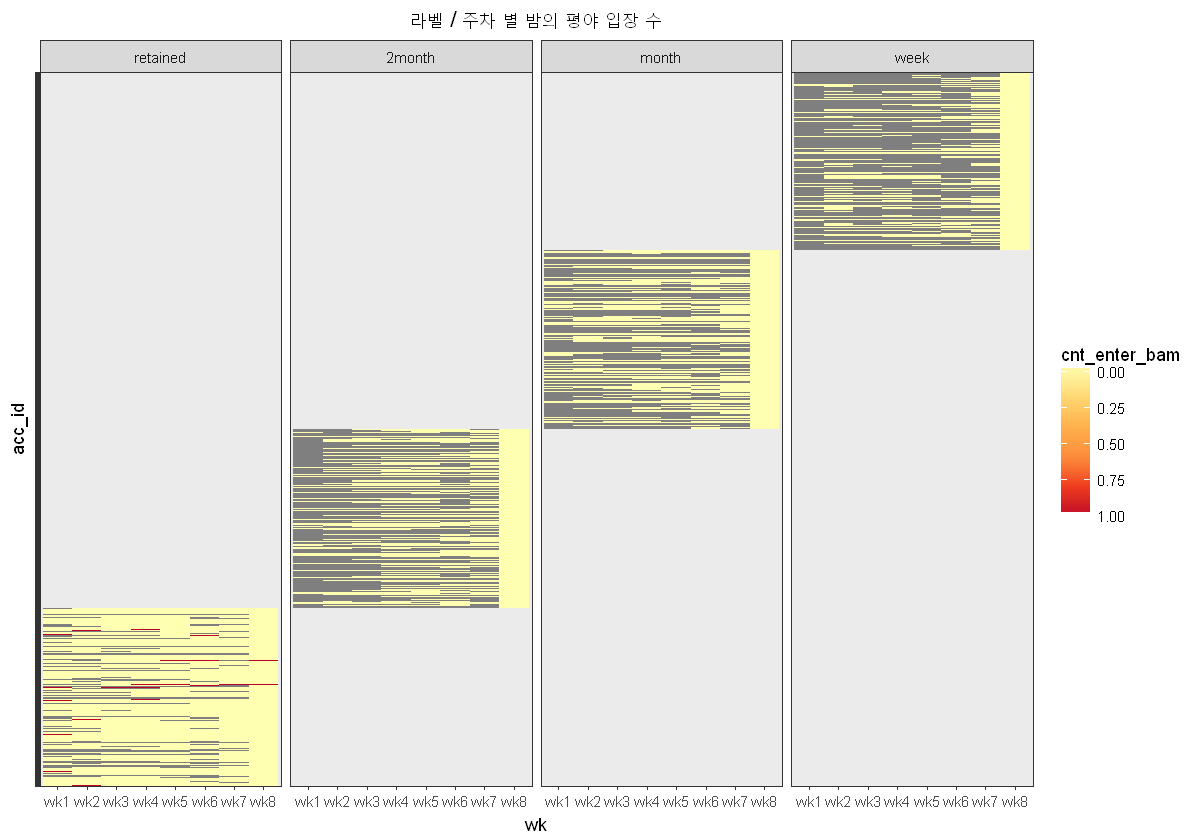

In [65]:
set.seed(2233)
label_week_heatmap(activity, "cnt_enter_bam", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 밤의 평야 입장 수")

## 2.6 Chat Variables

In [66]:
summary(activity %>% select(normal_chat, whisper_chat, district_chat, party_chat, guild_chat, faction_chat))

  normal_chat         whisper_chat      district_chat         party_chat      
 Min.   : -0.03404   Min.   :-0.23183   Min.   : -0.01657   Min.   :-0.27517  
 1st Qu.: -0.03404   1st Qu.:-0.23183   1st Qu.: -0.01657   1st Qu.:-0.27517  
 Median : -0.03404   Median :-0.23183   Median : -0.01657   Median :-0.27517  
 Mean   :  0.00132   Mean   :-0.00076   Mean   :  0.00204   Mean   :-0.00152  
 3rd Qu.: -0.03050   3rd Qu.:-0.14557   3rd Qu.: -0.01657   3rd Qu.:-0.20172  
 Max.   :286.35227   Max.   :88.71364   Max.   :187.89585   Max.   :55.24059  
   guild_chat         faction_chat      
 Min.   :-0.343293   Min.   : -0.02403  
 1st Qu.:-0.343293   1st Qu.: -0.02403  
 Median :-0.343293   Median : -0.02403  
 Mean   :-0.002359   Mean   : -0.00176  
 3rd Qu.:-0.343293   3rd Qu.: -0.02403  
 Max.   :26.279808   Max.   :127.74117  

In [67]:
chat <- activity %>% select(acc_id, normal_chat, whisper_chat, district_chat, party_chat, guild_chat, faction_chat) %>%
  mutate(normal_chat_new = (normal_chat - min(normal_chat))/(max(normal_chat) - min(normal_chat)),
         whisper_chat_new = (whisper_chat - min(whisper_chat))/(max(whisper_chat) - min(whisper_chat)),
         district_chat_new = (district_chat - min(district_chat))/(max(district_chat) - min(district_chat)),
         party_chat_new = (party_chat - min(party_chat))/(max(party_chat) - min(party_chat)),
         guild_chat_new = (guild_chat - min(guild_chat))/(max(guild_chat) - min(guild_chat)),
         faction_chat_new = (faction_chat - min(faction_chat))/(max(faction_chat) - min(faction_chat))) %>%
  group_by(acc_id) %>%
  summarize(normal_chat_sum = sum(normal_chat_new),
            whisper_chat_sum = sum(whisper_chat_new),
            district_chat_sum = sum(district_chat_new),
            party_chat_sum = sum(party_chat_new),
            guild_chat_sum = sum(guild_chat_new),
            faction_chat_sum = sum(faction_chat_new)) %>%
  left_join(label, by = "acc_id")
head(chat)

acc_id,normal_chat_sum,whisper_chat_sum,district_chat_sum,party_chat_sum,guild_chat_sum,faction_chat_sum,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.000000e+00,0.000000000,0,0.0000000000,0,0,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.000000e+00,0.000000000,0,0.0000000000,0,0,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.000000e+00,0.000000000,0,0.0000000000,0,0,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,2.469837e-05,0.004710446,0,0.0005447895,0,0,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.000000e+00,0.000000000,0,0.0000000000,0,0,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.000000e+00,0.004710446,0,0.0000000000,0,0,month


In [68]:
summary(chat)

    acc_id          normal_chat_sum    whisper_chat_sum   district_chat_sum 
 Length:100000      Min.   :0.000000   Min.   :0.000000   Min.   :0.000000  
 Class :character   1st Qu.:0.000000   1st Qu.:0.000000   1st Qu.:0.000000  
 Mode  :character   Median :0.000000   Median :0.000000   Median :0.000000  
                    Mean   :0.000544   Mean   :0.011439   Mean   :0.000436  
                    3rd Qu.:0.000148   3rd Qu.:0.002494   3rd Qu.:0.000000  
                    Max.   :5.776369   Max.   :3.179135   Max.   :6.939203  
 party_chat_sum     guild_chat_sum    faction_chat_sum        label      
 Min.   :0.000000   Min.   :0.00000   Min.   :0.000000   retained:25000  
 1st Qu.:0.000000   1st Qu.:0.00000   1st Qu.:0.000000   2month  :25000  
 Median :0.000000   Median :0.00000   Median :0.000000   month   :25000  
 Mean   :0.021705   Mean   :0.05639   Mean   :0.000767   week    :25000  
 3rd Qu.:0.003347   3rd Qu.:0.00000   3rd Qu.:0.000000                   
 Max.   :4.930967

Warning message:
"Removed 1340 rows containing non-finite values (stat_boxplot)."

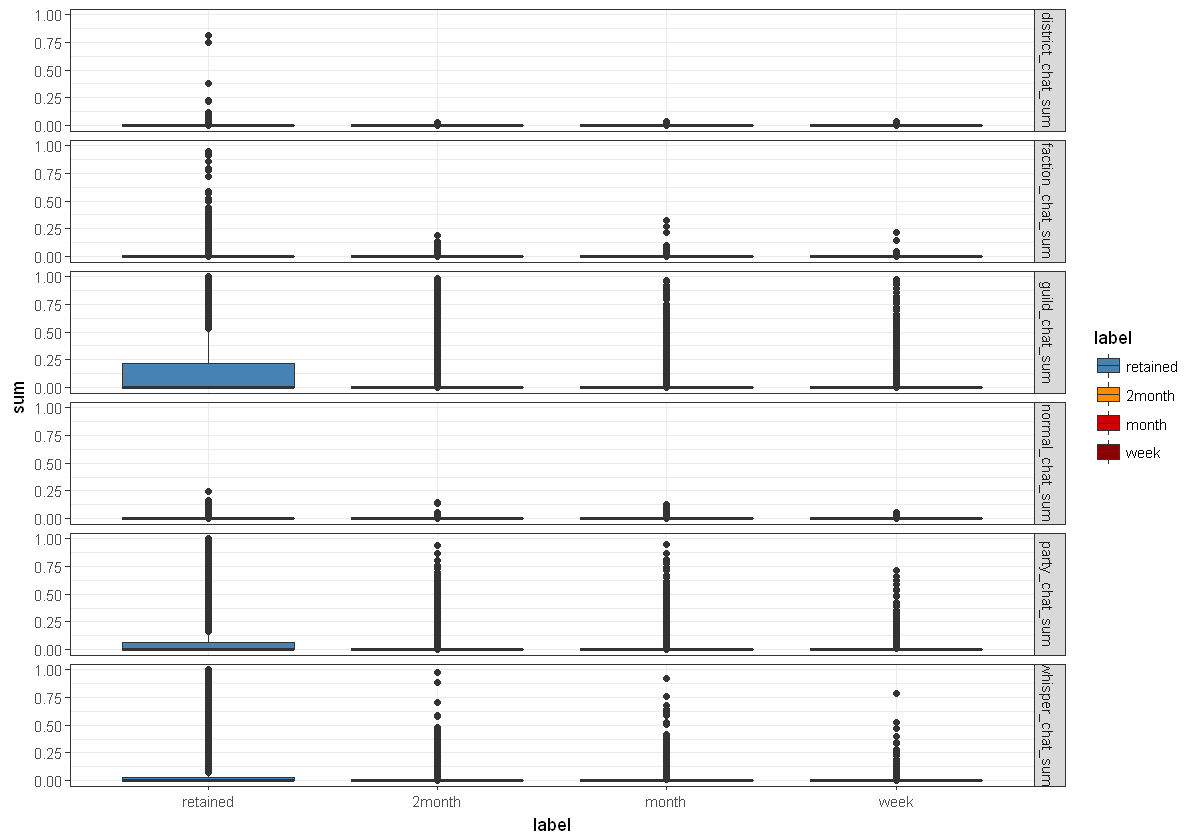

In [69]:
chat %>% gather(key = "type", value = "sum", -acc_id, -label) %>%
  ggplot(aes(x = label, y = sum, fill = label)) + geom_boxplot() + 
  ylim(c(0, 1)) + 
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) + 
  facet_grid(type ~ ., scales = "free")

## 2.7 ETC Variables

In [70]:
summary(activity %>% select(cnt_use_buffitem, gathering_cnt, making_cnt, game_combat_time, get_money))

 cnt_use_buffitem    gathering_cnt         making_cnt       game_combat_time  
 Min.   :-0.503692   Min.   : -0.02776   Min.   :-0.36554   Min.   :-0.56984  
 1st Qu.:-0.503692   1st Qu.: -0.02776   1st Qu.:-0.36554   1st Qu.:-0.56984  
 Median :-0.449522   Median : -0.02776   Median :-0.36554   Median :-0.48112  
 Mean   :-0.003231   Mean   :  0.00034   Mean   :-0.00264   Mean   :-0.00445  
 3rd Qu.:-0.043251   3rd Qu.: -0.02776   3rd Qu.:-0.36554   3rd Qu.: 0.09709  
 Max.   :19.371130   Max.   :135.57972   Max.   :39.06432   Max.   :10.86520  
   get_money        
 Min.   : -0.02354  
 1st Qu.: -0.02354  
 Median : -0.02353  
 Mean   : -0.00042  
 3rd Qu.: -0.02329  
 Max.   :208.03210  

In [71]:
etc <- activity %>% select(acc_id, cnt_use_buffitem, gathering_cnt, making_cnt, game_combat_time, get_money) %>%
  mutate(cnt_use_buffitem_new = (cnt_use_buffitem - min(cnt_use_buffitem))/(max(cnt_use_buffitem) - min(cnt_use_buffitem)),
         gathering_cnt_new = (gathering_cnt - min(gathering_cnt))/(max(gathering_cnt) - min(gathering_cnt)),
         making_cnt_new = (making_cnt - min(making_cnt))/(max(making_cnt) - min(making_cnt)),
         game_combat_time_new = (game_combat_time - min(game_combat_time))/(max(game_combat_time) - min(game_combat_time)),
         get_money_new = (get_money - min(get_money))/(max(get_money) - min(get_money))) %>%
  group_by(acc_id) %>%
  summarize(cnt_use_buffitem_sum = sum(cnt_use_buffitem_new),
            gathering_cnt_sum = sum(gathering_cnt_new),
            making_cnt_sum = sum(making_cnt_new),
            game_combat_time_sum = sum(game_combat_time_new),
            get_money_sum = sum(get_money_new)) %>%
  left_join(label, by = "acc_id")
head(etc)

acc_id,cnt_use_buffitem_sum,gathering_cnt_sum,making_cnt_sum,game_combat_time_sum,get_money_sum,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.3186154265,0,0,0.5465439427,1.186224e-06,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.0000000000,0,0,0.0000000000,0.000000e+00,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.0002725538,0,0,0.0003112564,0.000000e+00,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.0223494140,0,0,0.0455323595,7.524995e-07,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.0002725538,0,0,0.0002890238,0.000000e+00,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.1117470700,0,0,0.1632539630,1.201576e-06,month


Warning message:
"Removed 20515 rows containing non-finite values (stat_boxplot)."

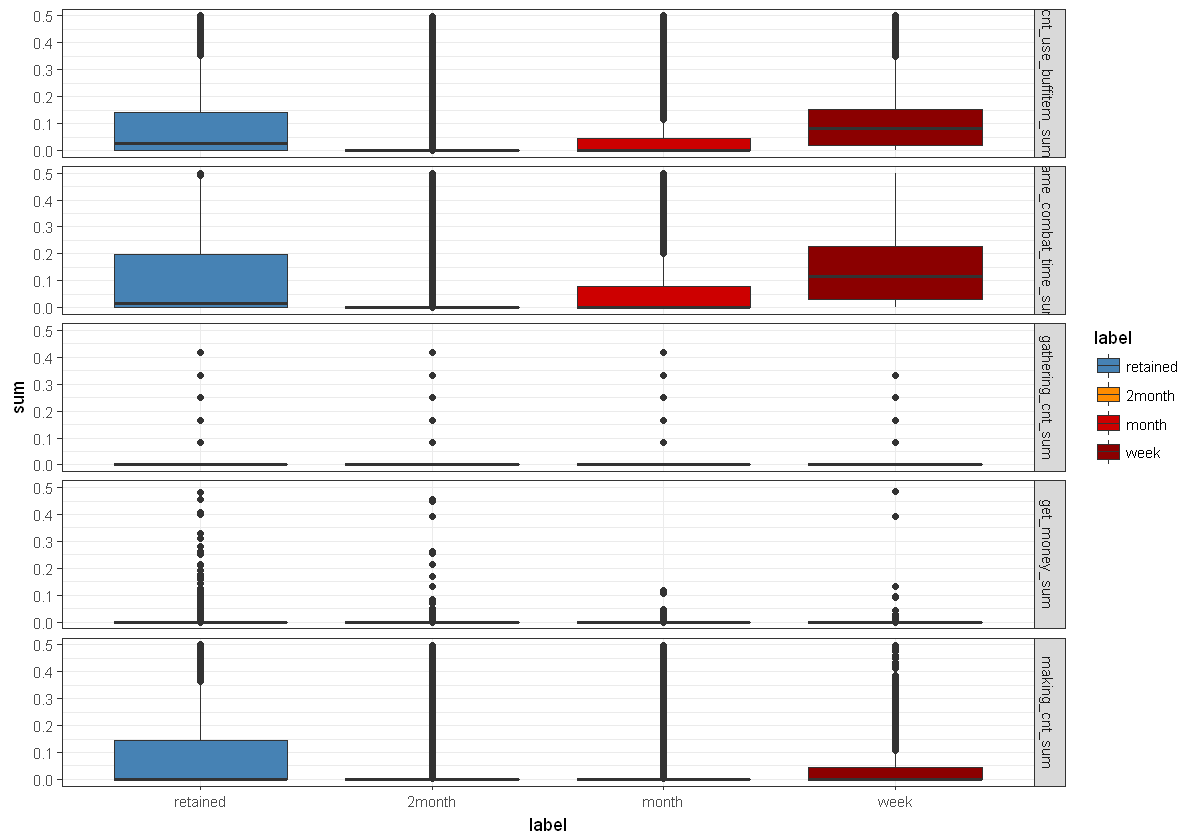

In [72]:
etc %>% gather(key = "type", value = "sum", -acc_id, -label) %>%
  ggplot(aes(label, sum, fill = label)) + geom_boxplot() + 
  ylim(c(0, 0.5)) + 
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  facet_grid(type ~ ., scales = "free")

# 3. EDA - Guild

In [73]:
head(guild)

guild_id,acc_id
000b682e9e50904b317c6f4afe17d8ee38b8c339f08bf960ccf67efc5f914f07,ba86804424a9a3708b1564a7726783612a75a5b881095ee635798c21b860dfea
000f26195f92ca13ec8683a6961a6c31ad07efde0d7b8061018a38207ac51dfe,ddea37c9b636c4b1650414052f6ede370481e9e236b19341682552ed6177883f
0015cb37aef2cef211f106244519ea8031c04091c9ac348507c571d1a9c43952,9eee6b10b87dce56b7b1eae9d591e16ec128d0c8376c28d75cd128540f21d652
0015cb37aef2cef211f106244519ea8031c04091c9ac348507c571d1a9c43952,a767abcfbd2303eb3e641f9425a5ecd83201b4c59f89f4cb813e42300a0c3371
0015cb37aef2cef211f106244519ea8031c04091c9ac348507c571d1a9c43952,b178c21c7e3a1a404dc6b8048d719f1e33873ab8b05a419664ac7f58aaf7bb00
001cbf66fa9c3e0ccead23d1c9cc444cb5a2ea3d5ab8740b659b886186a10b30,25810af9e9cff193561a77da73684a3113c3c1539168b11db9829c1aad67ebad


In [74]:
guild_new <- guild %>% group_by(acc_id) %>% summarize(guild_num = n()) %>% right_join(label, by = "acc_id")
guild_new[is.na(guild_new)] <- 0
head(guild_new)

acc_id,guild_num,label
b8fbf3f6a70e3f36843bffc70c18ff51a0d755a87616eca21b17b94d2ee2a734,0,week
ed500c4957956b3e99dc3985666850b582f812405eefb6ee731c3cf90f339b72,0,week
acc6afa23a6bf15e18151e4794c7789225ef9d682f473c243fd6d6b4b456e1ae,0,week
34095a3c9a2937ced3ea3fd75e22ce177dc5879d2a53f7d88842c604510a7ae5,0,week
26f3db6e8817a93c4ceda9a16f0832945e43d950b95882f0e5a54ab7ed01bebe,0,week
aaf2fb67be2d51bf75b973df5587dda57aa147c123c2a4307827f3b023ff0f96,0,week


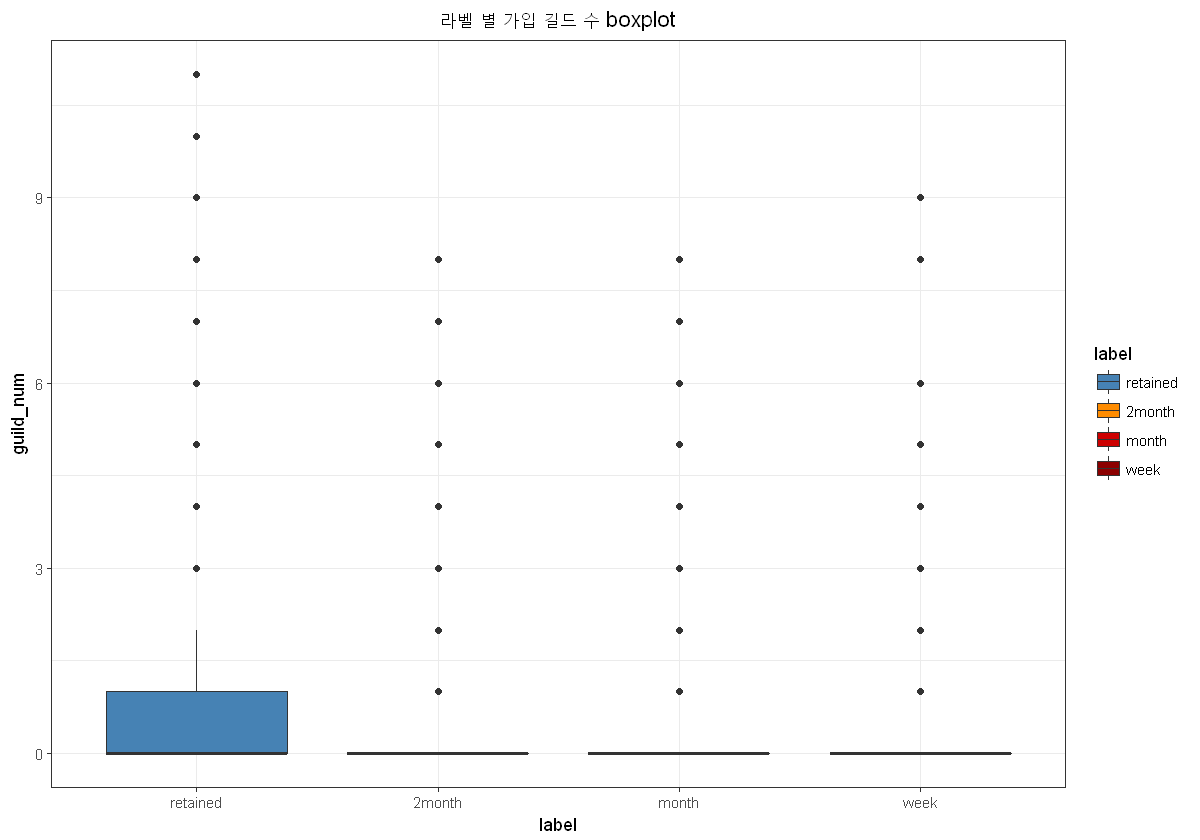

In [75]:
ggplot(guild_new, aes(label, guild_num, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  labs(title = "라벨 별 가입 길드 수 boxplot") +
  theme(plot.title = element_text(hjust = 0.5))

# 4. EDA - Payment

In [76]:
head(payment)

payment_week,acc_id,payment_amount
1,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
2,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
3,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
4,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
5,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
6,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985


In [77]:
payment_new <- payment %>% 
  mutate(payment_amount_new = (payment_amount - min(payment_amount))/(max(payment_amount) - min(payment_amount))) %>%
  group_by(acc_id) %>% summarize(sum_payment = sum(payment_amount),
                                 mean_payment = mean(payment_amount))

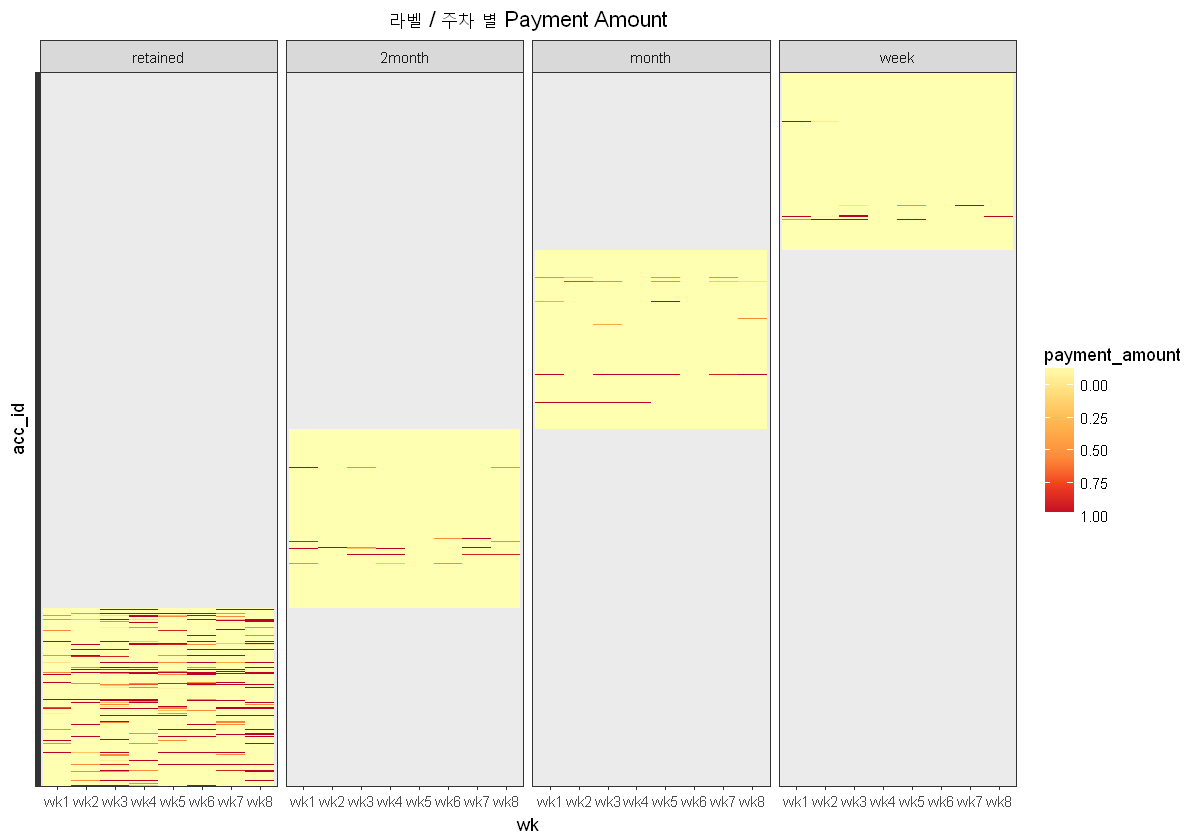

In [78]:
set.seed(2233)
payment %>% rename(wk = payment_week) %>%
label_week_heatmap("payment_amount", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 Payment Amount")

Warning message:
"Removed 761982 rows containing non-finite values (stat_boxplot)."

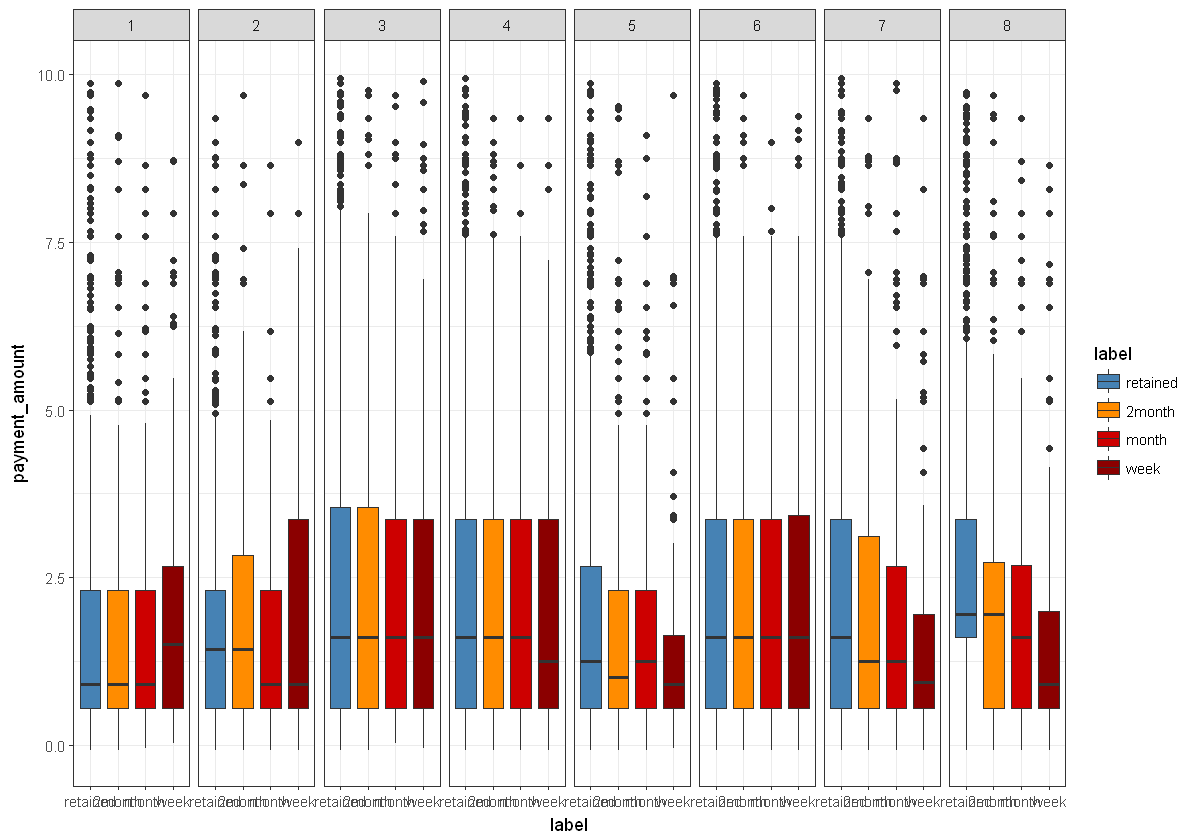

In [79]:
payment %>% left_join(label, by = "acc_id") %>%
  ggplot(aes(label, payment_amount, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  ylim(c(-0.1, 10)) +
  facet_grid(. ~ payment_week)

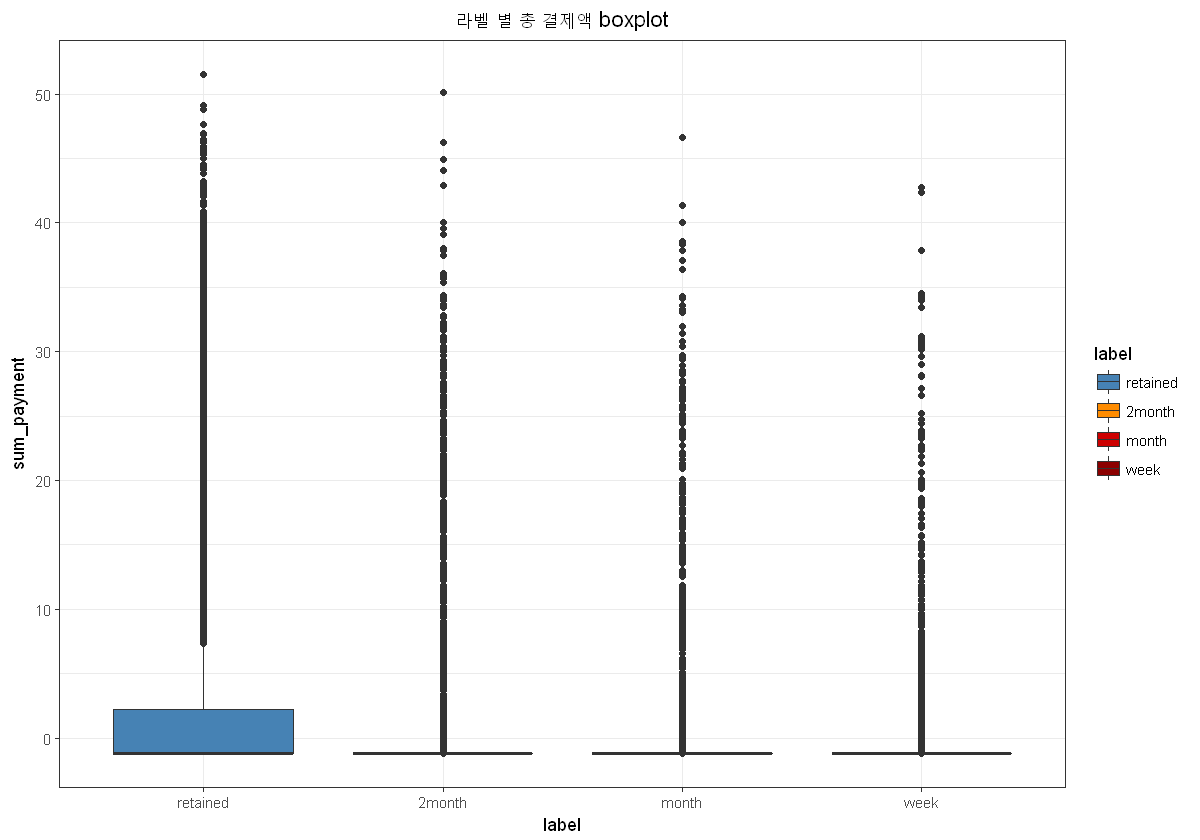

In [80]:
payment_new %>%
  left_join(label, by = "acc_id") %>%
  ggplot(aes(label, sum_payment, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  labs(title = "라벨 별 총 결제액 boxplot") +
  theme(plot.title = element_text(hjust = 0.5))

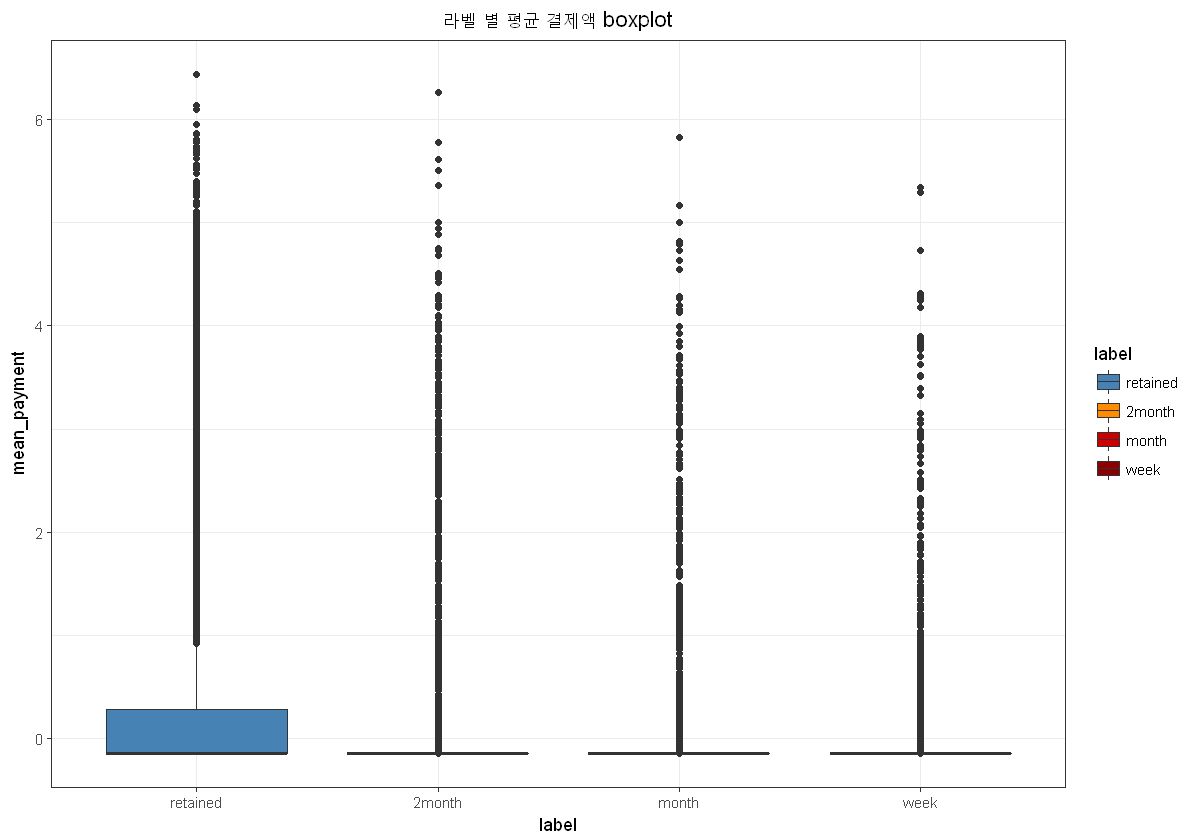

In [81]:
payment_new %>%
  left_join(label, by = "acc_id") %>%
  ggplot(aes(label, mean_payment, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  labs(title = "라벨 별 평균 결제액 boxplot") +
  theme(plot.title = element_text(hjust = 0.5))

# 5. EDA - Trade

In [82]:
trade_new <- trade %>%
  gather(key = "role", value = "acc_id", source_acc_id, target_acc_id) %>%
  mutate(role = ifelse(role == "source_acc_id", "sell", "buy"),
         item_amount_new = (item_amount - min(item_amount))/(max(item_amount) - min(item_amount)))
head(trade_new)

trade_week,trade_day,trade_time,item_type,item_amount,role,acc_id,item_amount_new
8,2,23:32:06,grocery,-0.05634402,sell,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,1.090001e-08
7,6,05:06:31,grocery,-0.05634330,sell,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,1.505001e-08
1,2,20:05:18,grocery,-0.05634568,sell,6ac252acf5ce113d2eb251d62ee2713c269655be3f8bec0eee11bb0ddb03bdf2,1.300001e-09
1,2,22:18:09,grocery,-0.05634555,sell,6ac252acf5ce113d2eb251d62ee2713c269655be3f8bec0eee11bb0ddb03bdf2,2.050001e-09
1,3,00:31:10,grocery,-0.05634567,sell,6ac252acf5ce113d2eb251d62ee2713c269655be3f8bec0eee11bb0ddb03bdf2,1.400001e-09
1,3,23:58:36,grocery,-0.05634569,sell,6ac252acf5ce113d2eb251d62ee2713c269655be3f8bec0eee11bb0ddb03bdf2,1.250001e-09


## 아이템 구매 및 판매량

Warning message:
"Removed 187 rows containing non-finite values (stat_boxplot)."

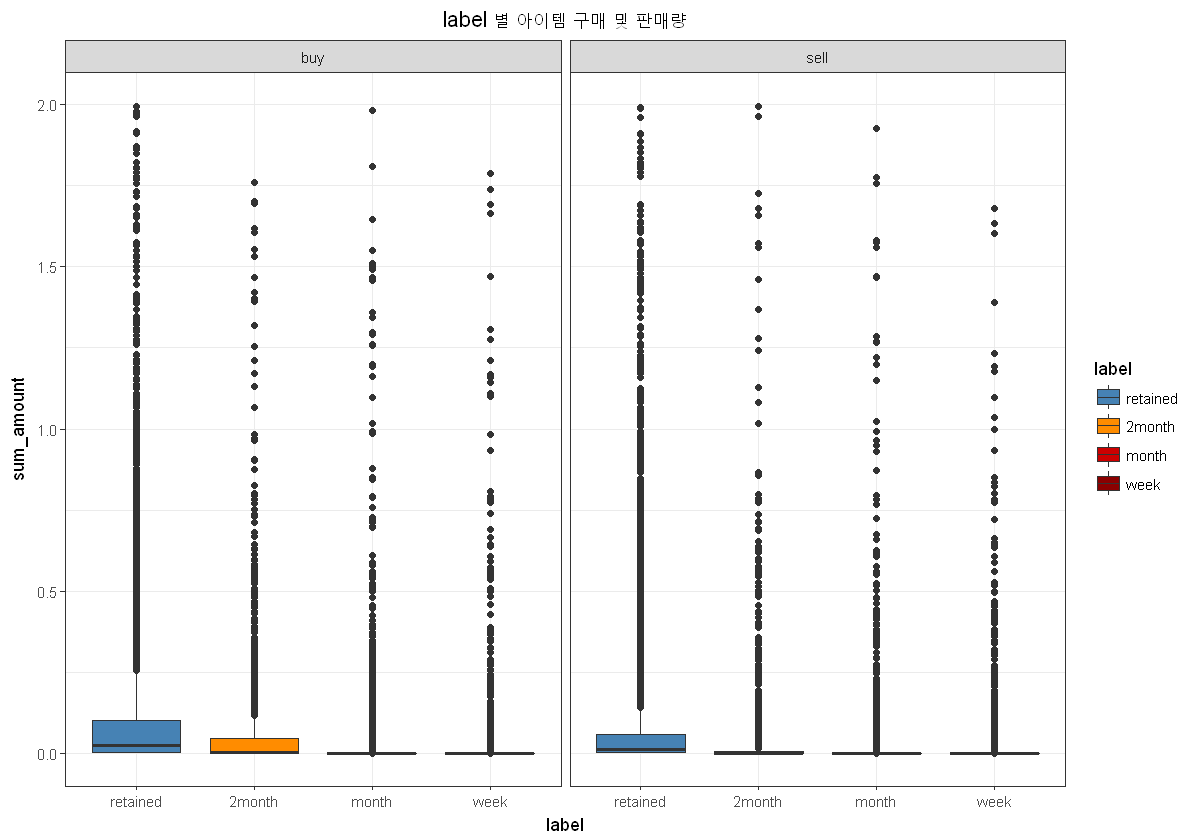

In [83]:
trade_new %>% group_by(acc_id, role) %>%
  summarize(sum_amount = sum(item_amount_new)) %>% 
  inner_join(label, by = "acc_id") %>%
  ggplot(aes(label, sum_amount, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  ylim(c(0, 2)) + 
  facet_grid(. ~ role, scales = "free") +
  labs(title = "label 별 아이템 구매 및 판매량") +
  theme(plot.title = element_text(hjust = 0.5))

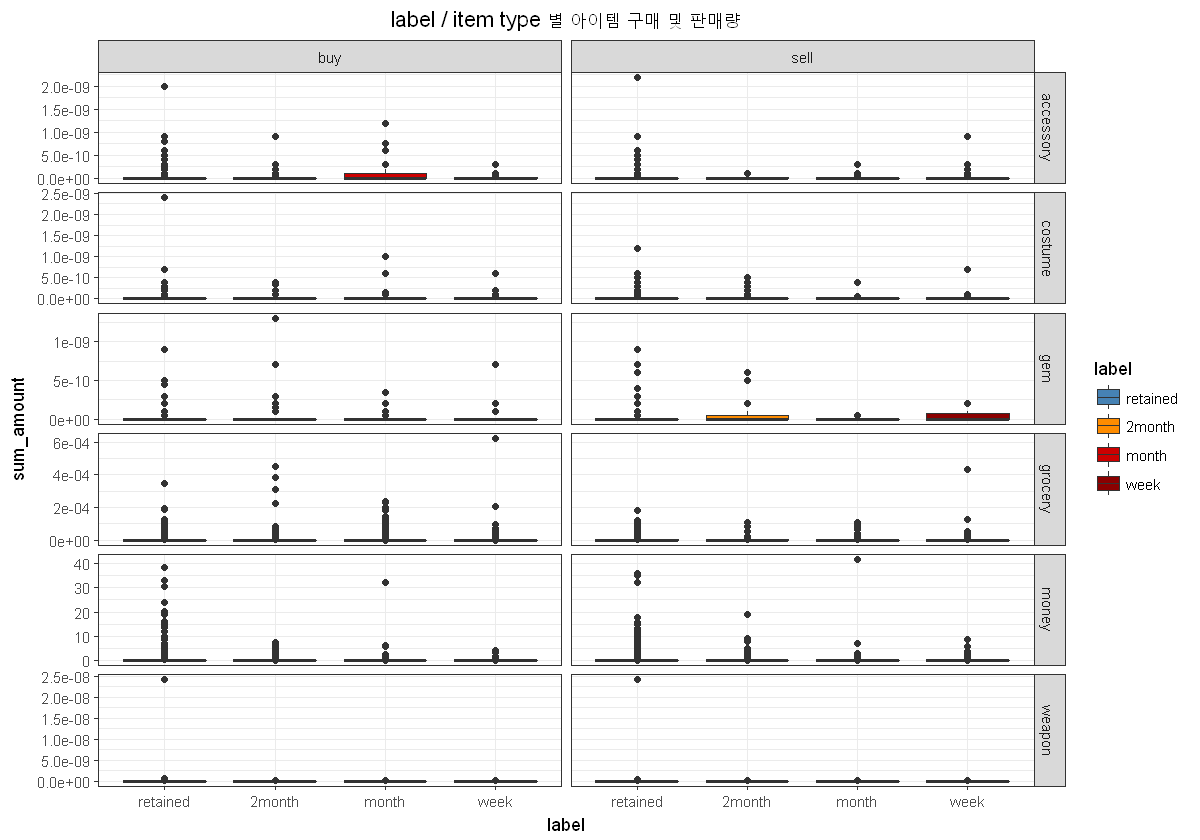

In [84]:
trade_new %>% group_by(acc_id, role, item_type) %>%
  summarize(sum_amount = sum(item_amount_new)) %>% 
  inner_join(label, by = "acc_id") %>%
  ggplot(aes(label, sum_amount, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  facet_grid(item_type ~ role, scales = "free") +
  labs(title = "label / item type 별 아이템 구매 및 판매량") +
  theme(plot.title = element_text(hjust = 0.5))

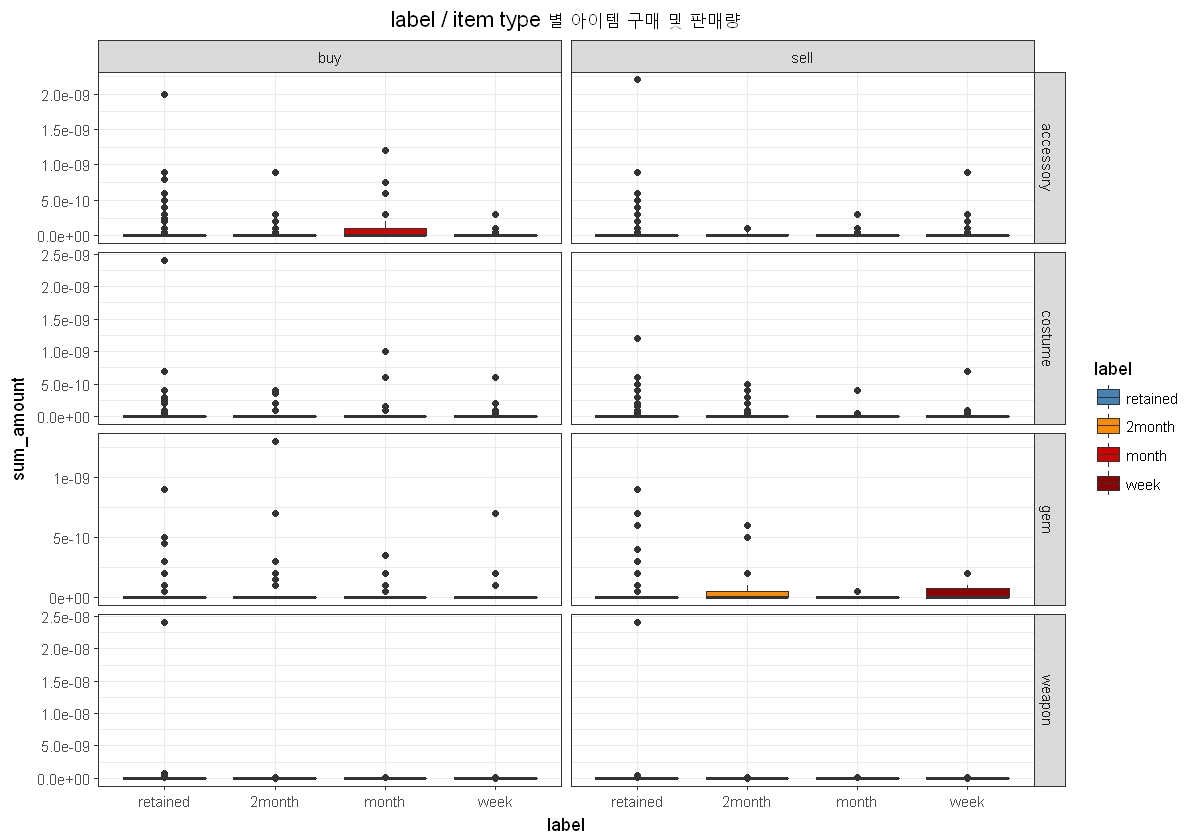

In [85]:
trade_new %>% group_by(acc_id, role, item_type) %>%
  summarize(sum_amount = sum(item_amount_new)) %>% 
  inner_join(label, by = "acc_id") %>%
  filter(item_type %in% c("accessory", "costume", "gem", "weapon")) %>%
  ggplot(aes(label, sum_amount, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  #ylim(c(0, 5)) + 
  facet_grid(item_type ~ role, scales = "free") +
  labs(title = "label / item type 별 아이템 구매 및 판매량") +
  theme(plot.title = element_text(hjust = 0.5))

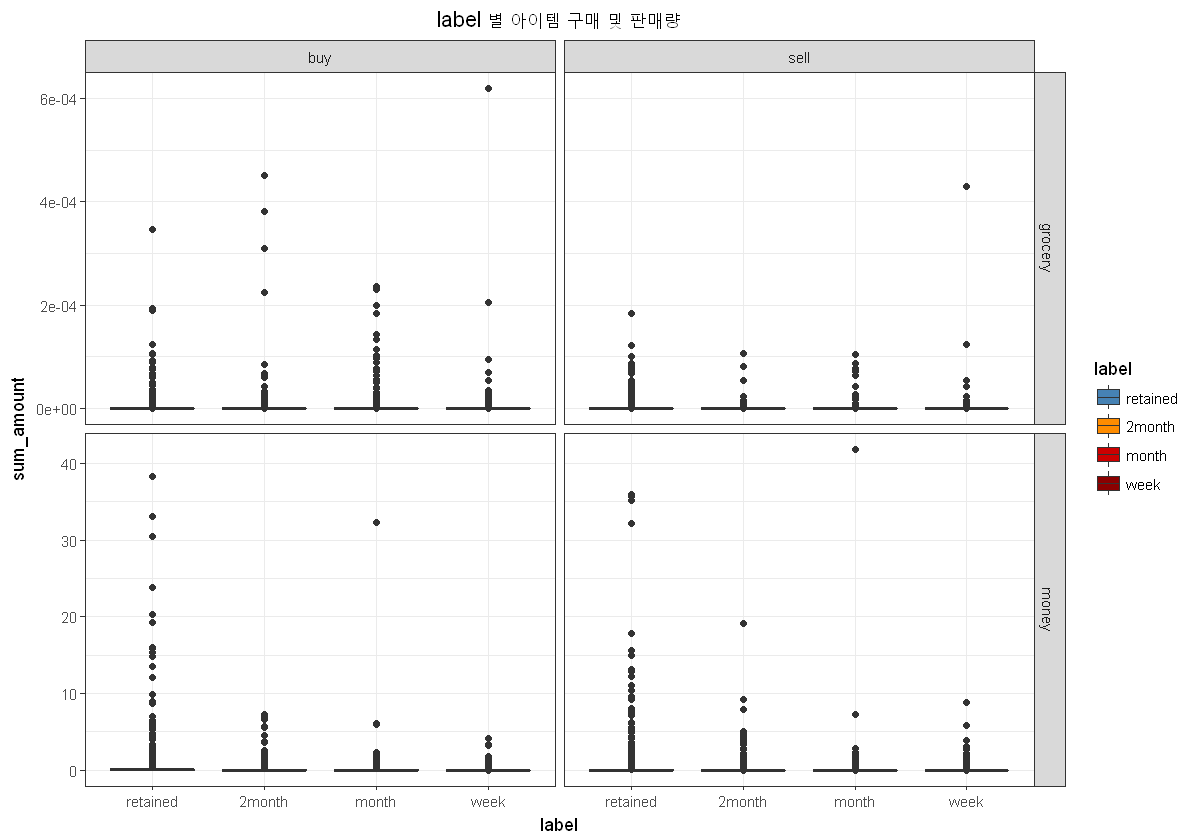

In [86]:
trade_new %>% group_by(acc_id, role, item_type) %>%
  summarize(sum_amount = sum(item_amount_new)) %>% 
  inner_join(label, by = "acc_id") %>%
  filter(item_type %in% c("grocery", "money")) %>%
  ggplot(aes(label, sum_amount, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  #ylim(c(0, 5)) + 
  facet_grid(item_type ~ role, scales = "free") +
  labs(title = "label 별 아이템 구매 및 판매량") +
  theme(plot.title = element_text(hjust = 0.5))

## 아이템 구매 및 판매 건수

Warning message:
"Removed 1675 rows containing non-finite values (stat_boxplot)."

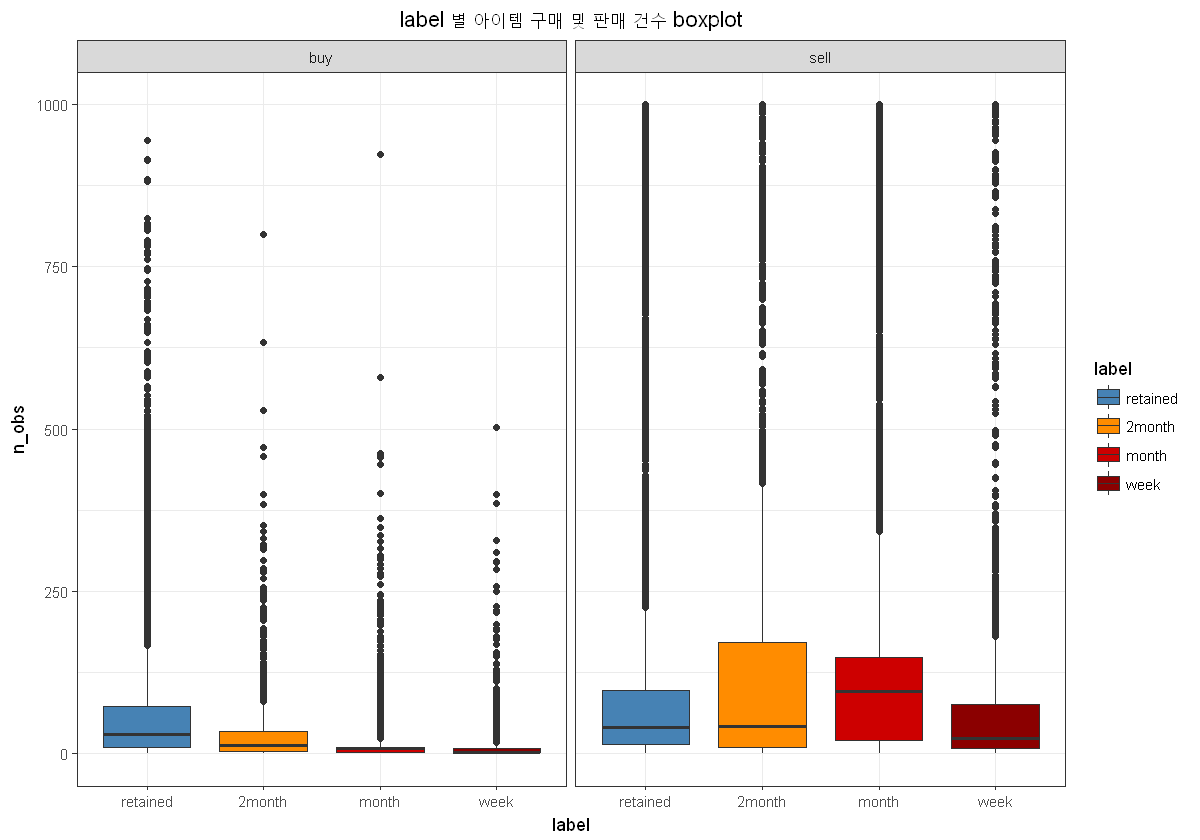

In [87]:
trade_new %>% group_by(acc_id, role) %>%
  summarize(n_obs = n()) %>% 
  inner_join(label, by = "acc_id") %>%
  ggplot(aes(label, n_obs, fill = label)) + geom_boxplot() +
  ylim(c(0, 1000)) +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) + 
  facet_grid(. ~ role, scales = "free") +
  labs(title = "label 별 아이템 구매 및 판매 건수 boxplot") +
  theme(plot.title = element_text(hjust = 0.5))

Warning message:
"Removed 19 rows containing non-finite values (stat_boxplot)."

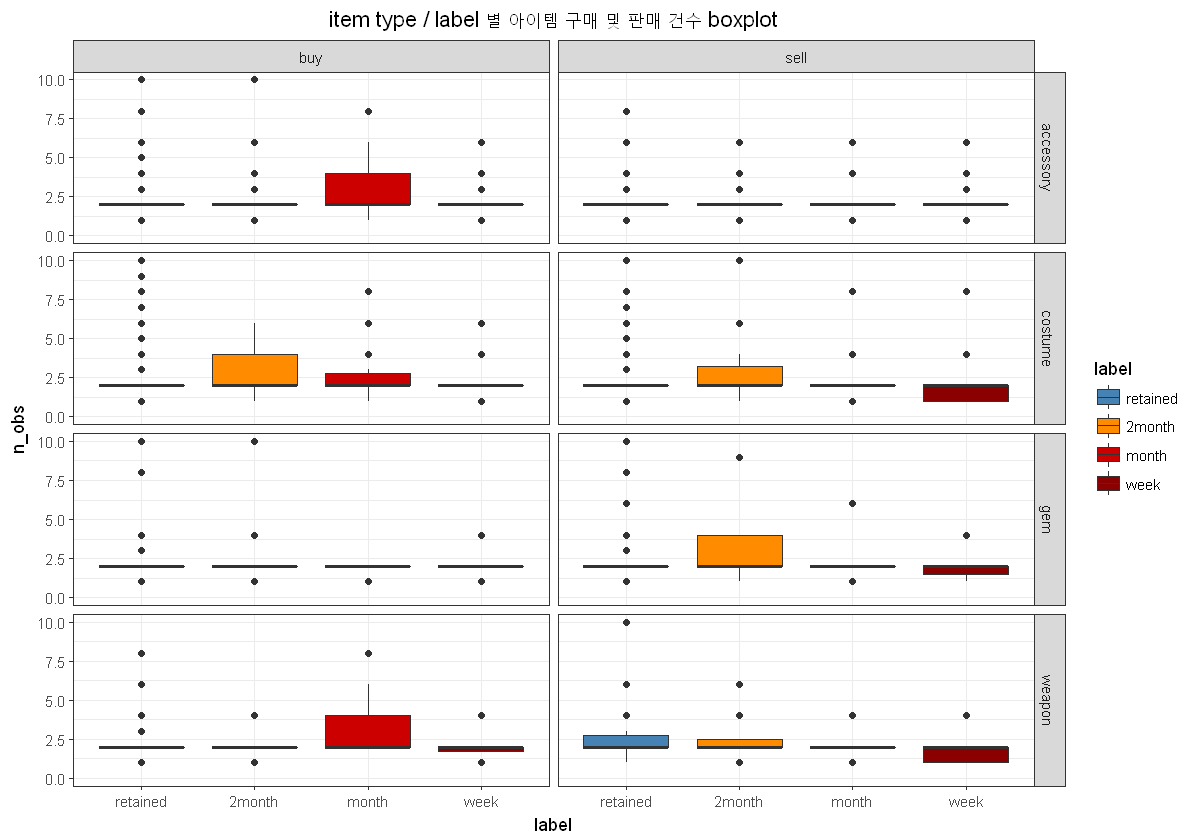

In [88]:
trade_new %>% group_by(acc_id, role, item_type) %>%
  summarize(n_obs = n()) %>% 
  filter(item_type %in% c("accessory", "costume", "gem", "weapon")) %>%
  inner_join(label, by = "acc_id") %>%
  ggplot(aes(label, n_obs, fill = label)) + geom_boxplot() +
  ylim(c(0, 10)) + 
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) + 
  facet_grid(item_type ~ role, scales = "free") +
  labs(title = "item type / label 별 아이템 구매 및 판매 건수 boxplot") +
  theme(plot.title = element_text(hjust = 0.5))

Warning message:
"Removed 3444 rows containing non-finite values (stat_boxplot)."

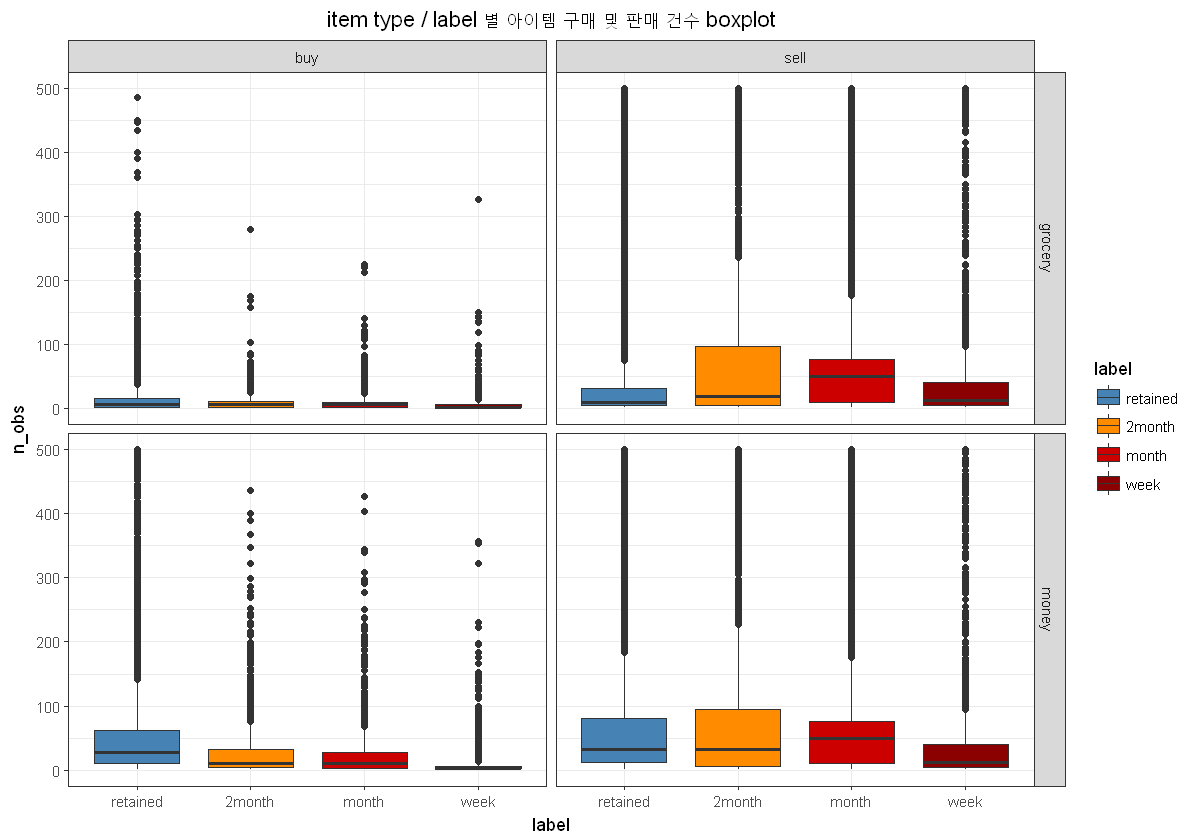

In [89]:
trade_new %>% group_by(acc_id, role, item_type) %>%
  summarize(n_obs = n()) %>% 
  filter(item_type %in% c("grocery", "money")) %>%
  inner_join(label, by = "acc_id") %>%
  ggplot(aes(label, n_obs, fill = label)) + geom_boxplot() +
  ylim(c(0, 500)) + 
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) + 
  facet_grid(item_type ~ role, scales = "free") +
  labs(title = "item type / label 별 아이템 구매 및 판매 건수 boxplot") +
  theme(plot.title = element_text(hjust = 0.5))

# 6. EDA - Party